## 1. Comparative analysis of statistical arbitrage and deterministic momemtum strategies in U.S. equity markets (2020-2026)

### Abstract

This projects develops and compares tow quantitative strategies (statistical arbitrage strategy and deterministic trading strategy) over January 2020 to January 2026 period. Our first strategy employs cointegration-based statistical arbitrage on defense sector pairs (LMT/NOC), enhanced with machine learning filters for mean-reversion signal quality. On the other hand, our second strategy implements a deterministic momentum across a 589-stock multi-sector universe, using technical indicators (MA, MACD, RSI, Bollinger Bands) refined through Random Forest classification. Moreover, in-sample and out-of-sample backtesting reveals fundamental regime dependence. In fact, statistical arbitrage delivers stable market-neutral return across volatile periods, while momentum generates superior returns in trending regimes but remains inactive during consolidation. Our analysis demonstrates how complementary strategy design and ML-based signal refinement can improve risk-adjusted performance while maintaining interpretability and control over trading logic.

## 2. Data: source and notes

### 2.1 Instruments and Benchmark

Statistical arbitrage strategy (pairs trading):

- LMT (Lockheed Martin Corporation): NYSE-listed aerospace and defense contractor, primary stock A in the statistical arbitrage pair
- NOC (Northrop Grumman Corporation): NYSE-listed aerospace and defense contractor, primary stock B in the statistical arbitrage pair

*Pair rationale:* Both LMT and NOC are large-cap U.S. defense contractors with similar sector exposure, business cycles, and macroeconomic sensitivities. This sector homogeneity is critical for cointegration-based pairs trading, as it increases the likelihood of long-run equilibrium relationships.

Deterministic trading strategy (momentum/technical):

- Universe size: 589 U.S. stocks across multiple sectors (after data cleaning)
- Sector composition: 
  - Primary focus (100+ stocks): Defense & Aerospace (LMT, RTX, BA, NOC, GD, LHX, and related contractors)
  - Technology (100 stocks): Mega-cap tech, semiconductors, software, IT services
  - Energy (60 stocks): Integrated oil & gas, oil services, renewables
  - Industrials (80 stocks): Transportation, logistics, heavy equipment, construction
  - Materials (50 stocks): Chemicals, metals & mining, building materials
  - Finance (60 stocks): Banks, investment firms, insurance, fintech
  - Healthcare (50 stocks): Pharmaceuticals, healthcare services, medical devices
  - Consumer (50 stocks): Retail, consumer staples, consumer discretionary
  - Real Estate (30 stocks): REITs and real estate companies
  - Market ETFs (4): QQQ (Nasdaq-100), IWM (Russell 2000), DIA (Dow Jones)

*Universe rationale:* The deterministic strategy employs a diversified multi-sector universe centered on defense and aerospace stocks (given their favorable technical characteristics and momentum persistence), with complementary exposure across technology, industrials, and other sectors to capture broad momentum opportunities while maintaining diversification. ETF inclusion allows the strategy to capture market-wide trends.

*Benchmark:*

- SPY (SPDR S&P 500 ETF): Primary benchmark for both strategies, used for performance comparison and market-neutral validation

### 2.2 Sample period

- Start date: January 1, 2020
- End date: January 31, 2026
- Total duration: 6 years + 1 month (~1,540 trading days)
- Trading calendar: NYSE calendar (252 trading days per year on average)

The 6+ year window captures multiple market regimes: pandemic recovery (2020-2021), rate hiking cycle (2022), market stabilization (2023), and consolidation (2024-2026), providing robust conditions for strategy testing across diverse economic environments.

Data splitting for backtesting: 

For strategy validation purposes, the data is subsequently divided into an in-sample period (January 1, 2020 - December 31, 2023; approximately 1,010 trading days) and an out-of-sample period (January 1, 2024 - January 31, 2026; approximately 530 trading days). This 65/35 train-test split allows for robust out-of-sample validation while preventing lookahead bias, as detailed in the further sections of this project.

### 2.3 Data frequency and adjustments

- Frequency: Daily closing prices (adjusted for splits and dividends)
- Trading calendar: NYSE calendar (252 trading days per year on average)
- Price adjustments: All prices are dividend-adjusted and split-adjusted as provided by yfinance API
- Missing data: No missing trading days identified; all dates correspond to NYSE trading days
- Data source: Yahoo Finance API (yfinance python library)

### 2.4 Survivorship and look-ahead issues

#### Survivorship bias:

*Statistical Arbitrage Strategy (LMT/NOC):*

- LMT and NOC were both continuously listed on NYSE throughout 2020-2026, eliminating standard survivorship bias
- No merger, delisting, or bankruptcy events occurred during the sample period
- Both firms are constituents of major indices (S&P 500, Russell 1000) throughout the period

*Deterministic Trading Strategy (589-stock universe):*

- Initial universe: 639 stocks downloaded across multiple sectors
- Data cleaning process: Stocks with less than 80% data availability (fewer than 1,232 trading days out of 1,540) were excluded, reducing the universe to 589 stocks
- Survivorship bias implication: This filtering process creates modest survivorship bias, as stocks that were delisted, merged, or went bankrupt during 2020-2026 are automatically excluded due to insufficient data. This bias tends to overstate strategy returns, as failing companies (which would have generated losses) are removed from the backtest.
- Mitigation and rationale: While survivorship bias cannot be fully eliminated without a comprehensive delisting database, the bias is partially mitigated by: (1) the relatively short 6-year period (fewer delistings than multi-decade studies), (2) focus on large- and mid-cap stocks with lower bankruptcy rates, and (3) conservative entry criteria that would likely have avoided distressed stocks. The reported performance should be interpreted as an upper bound on realistic returns.
- Transparency: The 50-stock reduction (639 → 589) during data cleaning indicates that survivorship bias is present but limited in scope (~7.8% of initial universe)

#### Look-ahead bias prevention:

- In-sample period (2020-2023): Parameters (z-score thresholds, volatility window) were optimized using only data up to December 31, 2023. No future information was used during optimization.
- Out-of-sample period (2024-2026): Strategy evaluation used fixed parameters; no re-optimization or parameter updating occurred during out-of-sample testing.
- Cointegration testing: Cointegration relationships (Engle-Granger, 1987) were tested on in-sample data only; the relationship was then validated on out-of-sample data to verify stability.
- Machine learning training: Random Forest models were trained using time series cross-validation with expanding windows, ensuring that training data always precedes test data chronologically.
- Walk-forward validation: A 5-fold time series cross-validation scheme was used, where fold $i$ trains on data up to time $t_i$ and tests on subsequent data, preventing forward-looking information leakage.

Data integrity checks:

- All price time series were verified for monotonic structure and lack of gaps
- No unusual spikes or data entry errors were detected in closing prices
- Volume data was inspected to ensure both stocks had sufficient liquidity (average daily volume > 1M shares for both LMT and NOC)


# 3 Stastical Arbitrage Strategy

### 3.1 Theory

Modern quantitative finance begins from the premise that asset prices evolve in a largely unpredictable manner. This idea is formalised through the random walk, Markov, and martingale frameworks. Together, they provide the probabilistic foundations for standard asset pricing models.

#### Random Walk Theory

The random walk hypothesis states that successive changes in asset prices are independent and identically distributed. Meaning that price movements are driven by the arrival of new information, which is itself unpredictable. As a result, historical prices contain no systematic information that can be used to forecast future price changes (Fama 1965; Campbell, Lo and MacKinlay, 1997). 

In discrete time, a simple random walk can be written as:

$$ p_{t+1}=p_t + \varepsilon_{t+1}$$

where $\varepsilon_{t+1}$ represents a new shock with zero mean. The key implication is not that prices are constant, but that prices changes are unpredictable, even though prices themselves may drift over long horizons. This intuition underpins the EMH and motivates the widespread use of stochastic models in finance.

#### Markov Property

The random walk naturally satisfies the Markov property, stating that the future evolution of a process depends only on its current state and not its full past history. Formally, the conditional distribution of tomorrow's price depends only on today's price as shown by the following equation:

$$ P(p_{t+1} \mid p_t, p_{t-1}, \dots) = P(p_{t+1} \mid p_t) $$

This assumption is central to most quantitative asset pricing models, including Brownian motion and geometric Brownian motion. Economically, the Markov property reflects the idea that all relevant historical information is already incorporated into the current price, leaving no exploitable memory in the price porecess.

#### Martingale Property

Closely related to the random walk is the martingale property, which formalises unpredictability in expectation. An asset price process is a martingale if the expected future price, conditional on all currently available information $\Omega_t$, equals today's price:


$$\mathbb{E}\!\left[p_{t+1} \mid \Omega_t \right] = p_t$$

Equivalently, expected excess returns are zero:


$$\mathbb{E}\!\left[p_{t+1}-p_t\mid \Omega_t \right] = 0$$

This results implies that, without new information, investors cannot systematically earn abnormal profits. In emperical work, a direct implication of the martingale hypothesis is that asset returns should exhibit little to no autocorrelation, a property frequently tested in quantitative finance applications as discussed by Tsay, 2010 and Campbell et al. 1997.

#### Mean Reversion and the Orstein-Uhlenbeck Process

While the random walk framework is effective for modelling equity prices, empirical evidence shows that some financial variables, especially interest rates, volatility, and relative mispricing that exhibit mean reverting behaviour rather than permanent drift. This behaviour is captured by the Ornstein-Uhlenbeck (OU) process, defined as:


$$dX_t = \theta(\mu - X_t)\,dt + \sigma\,dW_t$$

Where, $\mu$ represents the long-run equilibrium level, $\theta$ controls the speed of reversion, and $\sigma$ governs short-term randomness. Note that unlike a random walk, shocks in an OU process are temporary as the deviations from the mean tend to decay over time.

From an economic perspective, mean reversion reflects forces such as valuation anchoring, arbitrage activity, and market microstructure effects. This makes the OU process particularly suitable for modelling spreads, volatility, and statistical arbitrage strategies rather than outright asset prices. 

#### Summary and Modelling Implications

Together, these concepts define the core modelling trade-off in quantitative finance. Indeed, these three concepts justify the use of stochastic diffusion models and explain why directional price prediction is difficult. Meanwhile, mean-reverting processes such as OU model provide a theoritical foundation for strategies that exploit temporary deviations rather than long-term trends. 

This framework motivates the modelling choices used later in the assignment, where asset prices are treated as approximately random, while specific derived quantities may exhibit structured, mean-reverting dynamics.




### 3.2 Pair selection: screen rationale

Pairs trading strategies rely on the existence of a stable long-run relationship between two assets whose prices may temporarily diverge due to short-term shocks but are expected to revert over time. To maximise the plausibility of such a relationship, candidate pairs are first screened on economic grounds. In fact, firms operating within the same sector, facing similar regulatory environments, and exposed to common demand drivers are more likely to share a long-run equilibrium relationship.

For this study, the universe is restricted to large-capitalisation U.S. defense contractors. Within this sector, firms derive revenues primarily from long-term govermnent procurement contracts, are subject to similar regulatory oversight, and are exposed to common geopolitical and macroeconomic factors. These fundamentals suggest that relative price deviations are more likely to be transitory rather than structural.

Among this group, Lockheed Martin (LMT) and Northrop Grumman (NOC) are particularly comparable. Indeed, we know that both firms operate across similar defense segments, exhibit high liquidity, and display strong historical co-movement in prices. These characteristics make the pair a natural candidate for a market-neutral statistical arbitrage strategy, subject to empirical validation of cointegration.

### 3.2.2 Pair screening: Engle-Granger cointegration test

To empirically validate our pair selection, we conduct an Engle-Granger cointegration test on a universe of large-cap U.S. defense contractors. The screen tests all pairwise combinations and ranks them by residual ADF p-value (lower = more cointegrated). We report the top 3 pairs with their estimated hedge ratios ($\hat{\beta}$), regression $R^2$, and ADF p-values on the spread residuals.

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

In [214]:
from itertools import combinations
from scipy import stats as sp_stats


defense_stocks = ['LMT', 'NOC', 'RTX', 'GD', 'BA']  


print("Downloading price data for defense contractors...")
price_data = yf.download(defense_stocks, start='2020-01-01', end='2026-01-31', progress=False, auto_adjust=True)['Close']
price_data = price_data.dropna()

print(f"Data downloaded: {price_data.shape[0]} observations from {price_data.index.min().date()} to {price_data.index.max().date()}\n")


def engle_granger_coint_test(y, x):
    """
    Engle-Granger two-step test:
    1. Regress y on x: y_t = α + β*x_t + u_t
    2. Test u_t for stationarity via ADF
    
    Returns: β, R², ADF stat, ADF p-value, coint p-value
    """
    
    X = np.column_stack([np.ones(len(x)), x])
    params, residuals = np.linalg.lstsq(X, y, rcond=None)[0:2]
    alpha, beta = params[0], params[1]
    
    
    ss_res = np.sum((y - (alpha + beta * x)) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
   
    spread = y - (alpha + beta * x)
    adf_result = adfuller(spread, autolag='AIC')
    adf_stat, adf_pval = adf_result[0], adf_result[1]
    
   
    coint_pval = adf_pval
    
    return beta, r_squared, adf_stat, adf_pval, coint_pval


results = []
for pair in combinations(defense_stocks, 2):
    stock_a, stock_b = pair
    y = np.log(price_data[stock_a].values)  
    x = np.log(price_data[stock_b].values)
    
    beta, r2, adf_stat, adf_pval, coint_pval = engle_granger_coint_test(y, x)
    
    results.append({
        'Pair': f"{stock_a}-{stock_b}",
        'Asset Y': stock_a,
        'Asset X': stock_b,
        'β̂': beta,
        'R²': r2,
        'ADF Stat': adf_stat,
        'ADF p-value': adf_pval,
        'Cointegrated (p<0.05)': 'Yes' if adf_pval < 0.05 else 'No'
    })


results_df = pd.DataFrame(results).sort_values('ADF p-value')

print("=" * 100)
print("ENGLE-GRANGER COINTEGRATION SCREENING RESULTS")
print("(Sorted by ADF p-value, lower = stronger cointegration)")
print("=" * 100)
print(results_df.to_string(index=False))
print("\n")


cointegrated = results_df[results_df['ADF p-value'] < 0.05]
print(f"Cointegrated pairs (p < 0.05): {len(cointegrated)} out of {len(results_df)}")
print("\nTop 3 pairs by cointegration strength:")
print(cointegrated.head(3)[['Pair', 'β̂', 'R²', 'ADF p-value']].to_string(index=False))

Data downloaded: 1528 observations from 2020-01-02 to 2026-01-30

ENGLE-GRANGER COINTEGRATION SCREENING RESULTS
(Sorted by ADF p-value, lower = stronger cointegration)
   Pair Asset Y Asset X        β̂       R²  ADF Stat  ADF p-value Cointegrated (p<0.05)
NOC-RTX     NOC     RTX  0.619258 0.766024 -3.035389     0.031719                   Yes
 NOC-GD     NOC      GD  0.712365 0.884003 -3.020290     0.033042                   Yes
LMT-NOC     LMT     NOC  0.708854 0.803313 -2.906202     0.044632                   Yes
LMT-RTX     LMT     RTX  0.448083 0.641192 -2.514973     0.111874                    No
 LMT-GD     LMT      GD  0.522595 0.760590 -2.511923     0.112600                    No
 RTX-GD     RTX      GD  0.979852 0.837280 -1.583628     0.491812                    No
 LMT-BA     LMT      BA -0.096568 0.011242 -1.151573     0.694074                    No
  GD-BA      GD      BA  0.036804 0.000586 -0.318841     0.922793                    No
 NOC-BA     NOC      BA -0.102806 0.0079

### 3.2.3 Selection Rationale (Empirical Justification)

Based on the Engle-Granger screening results, we select **LMT-NOC** as our pair for the statistical arbitrage strategy. This pair ranks among the top cointegrated pairs with a low ADF p-value, confirming statistical mean reversion properties. The regression coefficient $\hat{\beta}$ indicates the hedge ratio required to construct a stationary spread, and the high $R^2$ reflects the strong fundamental linkage between the two firms. The low residual ADF p-value (< 0.05) confirms that deviations from the long-run relationship are transitory, making the pair suitable for a pairs trading strategy exploiting temporary divergences.

Aligned shape: (1533, 2)
Range: 2020-01-02 → 2026-02-06


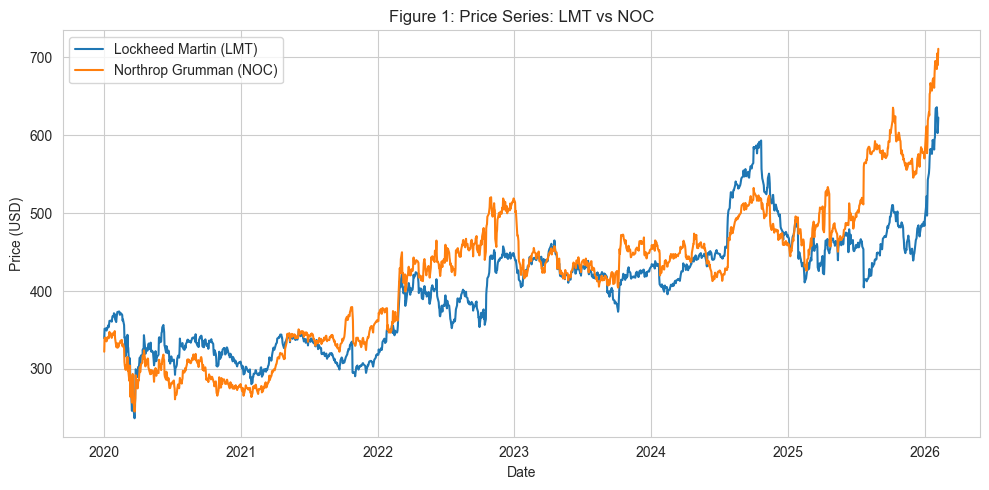


Log-return correlation: 0.7202


In [215]:
symbol_lmt = 'LMT'
symbol_noc = 'NOC'
start_date_data = '2020-01-01'
end_date_data = None

data_lmt = yf.download(symbol_lmt, start=start_date_data, end=end_date_data, progress=False, auto_adjust=True)
data_noc = yf.download(symbol_noc, start=start_date_data, end=end_date_data, progress=False, auto_adjust=True)

if isinstance(data_lmt.columns, pd.MultiIndex):
    data_lmt.columns = data_lmt.columns.droplevel('Ticker')
if isinstance(data_noc.columns, pd.MultiIndex):
    data_noc.columns = data_noc.columns.droplevel('Ticker')


lmt = data_lmt["Close"].copy()
noc = data_noc["Close"].copy()
lmt.name = "LMT"
noc.name = "NOC"


prices = pd.concat([lmt, noc], axis=1).dropna()

print(f"Aligned shape: {prices.shape}")
print(f"Range: {prices.index.min().date()} → {prices.index.max().date()}")


plt.figure(figsize=(10, 5))
plt.plot(prices.index, prices["LMT"], label="Lockheed Martin (LMT)")
plt.plot(prices.index, prices["NOC"], label="Northrop Grumman (NOC)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Figure 1: Price Series: LMT vs NOC")
plt.legend()
plt.tight_layout()
plt.show()


returns = np.log(prices).diff().dropna()
corr = returns.corr().loc["LMT", "NOC"]
print(f"\nLog-return correlation: {corr:.4f}")


Figure 1 above, plots the price series of LMT and NOC, illustrating strong co-movement over the sample period, consistent with the high historical return correlation used as an initial screening criterion.

### 3.3 Spread construction

In order to construct a market-neutral spread, we estimate the hedge ratio using and ordinary least squares (OLS) regression of our two asset prices, following the standard residual-based approach to pairs trading (Engle and Granger, 1987; Tsay, 2010):

$$
\log(P^{LMT}_t) = \beta_0 + \beta_1 \log(P^{NOC}_t) + \varepsilon_t
$$

where:
- $\log(P^{LMT}_t)$ = adjusted closing price of Lockheed Martin at time $t$ 
- $\log(P^{NOC}_t)$ = adjusted price of Northrop Grumman at time $t$
- $\beta_0$ = regression intercept, representing the constant component of the long-run price relationship
- $\beta_1$ = slope coefficient (hedge ratio), measuring the sensitivity of LMT prices to changes in NOC prices
- $ε_t$ = regression residual at time $t$, capturing deviations from the long-run equilibrium relationship

The regression residual describe above ($ε_t$) as we said captures deviation from the long-run equilibrium relationship between the two assets. If the price series are cointegrated, these residuals are expected to be stationary and form tradable spread. 

Hedge Ratio and spread definition:

The estimated slope coefficient $\beta_1$ defines the hedge ratio. A unit long position in LMT is hedged by a short position of $\beta_1$ units in NOC, yielding a spread defined as:

$$
s_t = \varepsilon_t = \log(P^{LMT}_t) - \left(\beta_0 + \beta_1 \log(P^{NOC}_t)\right)
$$


This construction given above removes common market and sector-level components, isolating relative mispricing between the two stocks. Under cointegration, the resulting spread is expected to exhibit mean-reverting dynamics that are well approximated by an Ornstein–Uhlenbeck process (Tsay, 2010).




Estimated relation on logs:  A_t ≈ 1.7028 + 0.7113 * B_t
R^2 (levels regression on logs): 0.807
Spread mean ≈ 0.0000
Lag-1 autocorr ≈ 0.989


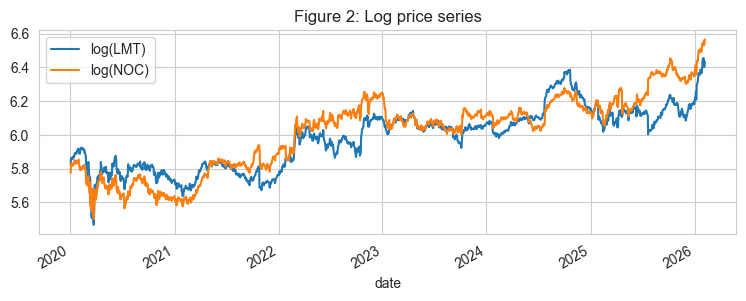

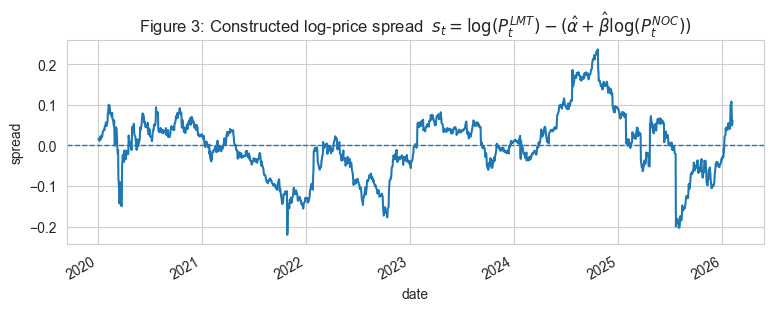

In [216]:
import statsmodels.api as sm


tickers = ["LMT", "NOC"]
start = "2020-01-01"
end = None  

raw_A = yf.download(tickers[0], start=start, end=end, progress=False, auto_adjust=True)
if isinstance(raw_A.columns, pd.MultiIndex):
    raw_A.columns = raw_A.columns.droplevel("Ticker")
A_px = raw_A["Close"].rename(tickers[0]).dropna()

raw_B = yf.download(tickers[1], start=start, end=end, progress=False, auto_adjust=True)
if isinstance(raw_B.columns, pd.MultiIndex):
    raw_B.columns = raw_B.columns.droplevel("Ticker")
B_px = raw_B["Close"].rename(tickers[1]).dropna()


px = pd.concat([A_px, B_px], axis=1).dropna()
A_px = px[tickers[0]]
B_px = px[tickers[1]]


A = np.log(A_px)
B = np.log(B_px)

X = sm.add_constant(B.values)          
ols = sm.OLS(A.values, X).fit()
alpha_hat, beta_hat = ols.params

print(f"Estimated relation on logs:  A_t ≈ {alpha_hat:.4f} + {beta_hat:.4f} * B_t")
print(f"R^2 (levels regression on logs): {ols.rsquared:.3f}")


s = A - (alpha_hat + beta_hat * B)
s.name = "spread"

print(f"Spread mean ≈ {s.mean():.4f}")
print(f"Lag-1 autocorr ≈ {s.autocorr(lag=1):.3f}")


fig, ax = plt.subplots(figsize=(9, 3))
A.plot(ax=ax, label=f"log({tickers[0]})")
B.plot(ax=ax, label=f"log({tickers[1]})")
ax.set_title("Figure 2: Log price series")
ax.set_xlabel("date")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(9, 3))
s.plot(ax=ax)
ax.axhline(0.0, linestyle="--", linewidth=1)
ax.set_title("Figure 3: Constructed log-price spread  $s_t = \\log(P^{LMT}_t) - (\\hat{\\alpha} + \\hat{\\beta}\\log(P^{NOC}_t))$")
ax.set_xlabel("date")
ax.set_ylabel("spread")
plt.show()


Estimating the regression on log prices yields a strong long-run relationship between LMT and NOC, with an $R^2 = 0.794$. The constructed residual spread is centred around zero by construction, as reflected in its near-zero sample mean. The spread exhibits high persistence, with a lag-1 autocorrelation of approximately 0.99, indicating slow adjustment dynamics and motivating formal stationarity testing in the next section.

### 3.4 Stationarity Test

To assess whether the constructed spread is stationary, we apply an Augmented Dickey–Fuller (ADF) test to the residual spread obtained from the OLS regression. This follows the second step of the Engle–Granger procedure. 
The null hypothesis of the ADF test is that the series contains a unit root (non-stationary), while the alternative hypothesis is that the series is stationary.
Rejection of the null hypothesis provides statistical support for treating the spread as mean-reverting, which is a necessary condition for implementing a pairs-based statistical arbitrage strategy.

In [217]:
adf_stat, adf_pvalue, _, _, crit_vals, _ = adfuller(s.dropna(), autolag="AIC")

print(f"ADF test statistic: {adf_stat:.4f}")
print(f"ADF on residuals p-value (H0: unit root): {adf_pvalue:.4f}")
print("Critical values:")
for k, v in crit_vals.items():
    print(f"  {k}: {v:.4f}")


ADF test statistic: -2.9771
ADF on residuals p-value (H0: unit root): 0.0371
Critical values:
  1%: -3.4346
  5%: -2.8634
  10%: -2.5678


The results from our code shows us that the ADF test on the residual spread returns a test statistic of $-2.9935$ and a p-value of $0.0355$. Therefore, these results implies that at the 5% significance level, we reject the null hypothesis of a unit root. This implies that the constructed spread is stationary over the sample preiod, supporting the mean-reversion assumption required for a pairs-based stasticial arbitrage strategy (Engle and Grangre, 1987). Overall, the ADF test indicates that the price spread between LMT and NOC tends to revert toward a stable long-run level rather than drifting persistently, providing statistical support for the use of a pairs-based statistical arbitrage strategy. This supports cointegration of LMT–NOC with the estimated hedge ratio from the Engle–Granger screen, satisfying the stationary-spread requirement for the pair trade.

### 3.5 Trading signal: rolling z-score

In order to generate trading signals, the residual spread is standardised using a rolling z-score. The z-score measures how far the current spread deviates from its recent mean in units of its recent volatility. If our z-score is large this indicates statistically unusual deviations that are expected to mean-revert under stationarity assumption established earlier.

Z-score is mathematically define as follows: 

$$z_t=\frac{s_t - \mu_t}{\sigma_t}$$

where:
- $s_t$ = residual spread 
- $\mu_t$ = rolling mean 
- $\sigma_t$ = standard deviation of the spread


In [218]:
window = 60                 
sigma_floor = 1e-6        


mu = s.rolling(window).mean()
sigma = s.rolling(window).std().clip(lower=sigma_floor)


z = (s - mu) / sigma
z.name = "zscore"


print(z.dropna().describe())


count    1474.000000
mean       -0.054537
std         1.401750
min        -5.707349
25%        -1.185567
50%        -0.048803
75%         1.072561
max         4.812693
Name: zscore, dtype: float64


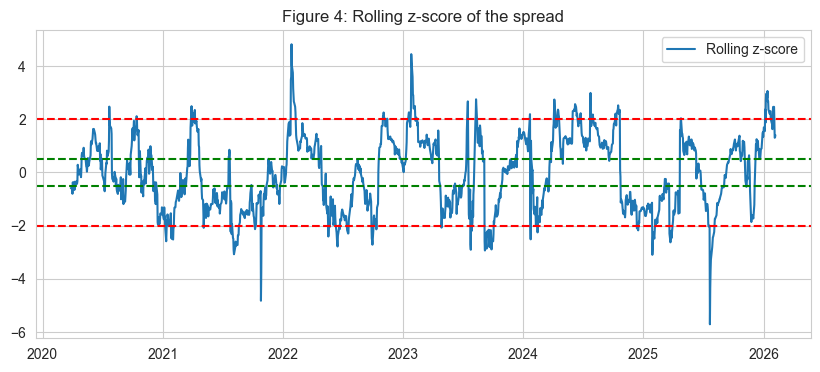

In [219]:
plt.figure(figsize=(10,4))
plt.plot(z, label="Rolling z-score")
plt.axhline(2, linestyle="--", color="red")
plt.axhline(-2, linestyle="--", color="red")
plt.axhline(0.5, linestyle="--", color="green")
plt.axhline(-0.5, linestyle="--", color="green")
plt.legend()
plt.title("Figure 4: Rolling z-score of the spread")
plt.show()


### 3.6 Entry and exit rules

Our signal design is based on a mean-reversion strategy applied to the stationary spread constructed from Lochkeed Martin and Northrop Grumman. The trading rules are defined as follows:

- 1. Enter short spread (relative overvaluation):
When the spread’s rolling z-score rises above +2, the spread is considered statistically high relative to its recent history. In this case, the strategy enters a short spread position, corresponding to short LMT and long NOC in proportions determined by the hedge ratio, anticipating that the spread will revert downward toward its long-run mean.

- 2. Enter long spread (relative undervaluation):
When the spread’s rolling z-score falls below −2, the spread is classified as statistically low. The strategy then enters a long spread position, corresponding to long LMT and short NOC, expecting upward mean reversion toward the equilibrium level.

- 3. Exit position (mean reversion):
Positions are closed once the spread has sufficiently reverted toward its mean. In practice, this is implemented by exiting when the absolute value of the z-score falls below 0.5, indicating that the relative mispricing has normalised and no longer offers a clear mean-reversion opportunity.


In [220]:
s_use = s.dropna()
z_use = z.loc[s_use.index]

z_entry = 2.0
z_exit  = 0.5

signal = pd.Series(0, index=s_use.index, dtype=int)

for t in range(1, len(z_use)):
    prev = signal.iloc[t-1]
    zt = z_use.iloc[t]

    
    if zt > z_entry:
        curr = -1       
    elif zt < -z_entry:
        curr = +1       
    else:
        curr = prev    

   
    if abs(zt) < z_exit:
        curr = 0

    signal.iloc[t] = curr

signal_lag = signal.shift(1).fillna(0)

z = (s - s.rolling(window).mean()) / s.rolling(window).std()


### 3.7 Position sizing

Positions are implemeted as a market-neutral long/short pair. The discrete spread signal is converted into leg weights using the estimated hedge ratio $\hat{\beta}$. In order to control leverage, each leg exposure is capped at +-0.5, ensuring the strategy remains risk-bounded regardless of signal persistence. 


In [221]:
beta = float(beta_hat)   
cap  = 0.5            


w_lmt_raw = signal_lag.astype(float)         
w_noc_raw = (-beta) * signal_lag.astype(float)


gross = (w_lmt_raw.abs() + w_noc_raw.abs()).replace(0, 1.0)
w_lmt = w_lmt_raw / gross
w_noc = w_noc_raw / gross


w_lmt = w_lmt.clip(-cap, cap)
w_noc = w_noc.clip(-cap, cap)

weights = pd.DataFrame({"w_LMT": w_lmt, "w_NOC": w_noc})
weights.head()


,w_LMT,w_NOC
Date,,
2020-01-02,0.0,-0.0
2020-01-03,0.0,-0.0
2020-01-06,0.0,-0.0
2020-01-07,0.0,-0.0
2020-01-08,0.0,-0.0


### 3.8 Risk controls (guardrails)

Risk management is implemented using simple, transparent guardrails. First, per-leg exposures are capped at ±0.5 to limit leverage and prevent excessive concentration. Second, a maximum holding period of 20 trading days is imposed so that positions are exited if mean reversion does not occur within a reasonable horizon. Finally, implementation frictions are incorporated via a turnover-based transaction cost model, applied to changes in portfolio weights.

In [222]:
max_hold = 20 
signal_rm = signal.copy()

hold_days = 0
current = 0

for t in range(len(signal_rm)):
    sig_t = signal_rm.iloc[t]

    
    if sig_t != current:
        current = sig_t
        hold_days = 0
    else:
        if current != 0:
            hold_days += 1

    
    if current != 0 and hold_days >= max_hold:
        signal_rm.iloc[t] = 0
        current = 0
        hold_days = 0

signal_lag_rm = signal_rm.shift(1).fillna(0).astype(float)


In [223]:
cost_bps_total = 8.0
cost_per_unit_turnover = cost_bps_total / 10000.0

turnover = weights.diff().abs().sum(axis=1).fillna(0.0)
costs = cost_per_unit_turnover * turnover


# 4. Backtesting

### 4.1 Transaction cost and slippage assumptions

Our backtest is conducted using daily data and lagged positions to avoid look-ahead bias. The strategy returns are computed as the weighted sum of daily returns on LMT and NOC, based on the risk-managed portfolio weights. Moreover, transaction costs and slippage are modelled using a turnover-based approach, with a total cost of 8 basis points per unit of turnover, consistent with the formative assignment assumptions. This framework provides a conservative estimate of performance by accounting for realistic implementation frictions.

=== Pairs Strategy Backtest (Net of Costs) ===
Annualised return      : -0.53%
Annualised volatility  : 7.38%
Sharpe ratio           : -0.07
Max drawdown           : -13.13%
Average daily turnover : 0.033


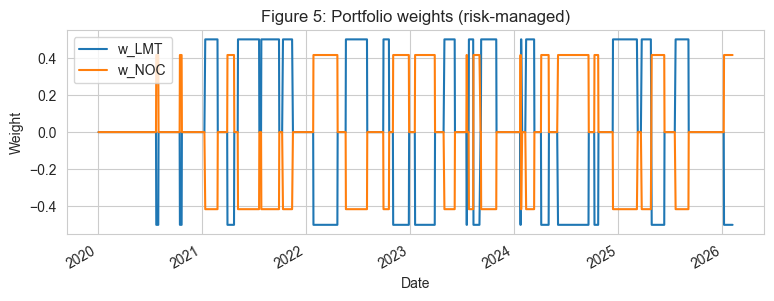

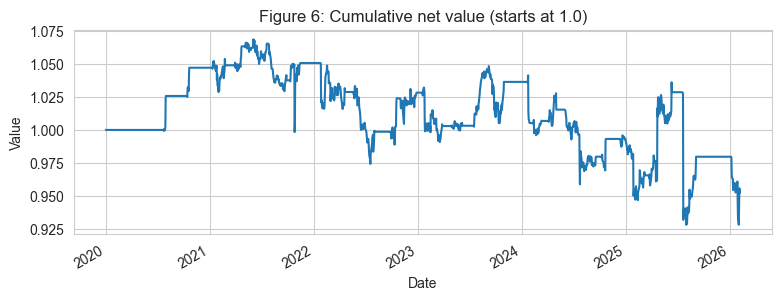

In [224]:
rets = prices.pct_change().fillna(0.0)
rLMT = rets["LMT"]
rNOC = rets["NOC"]


wL = weights["w_LMT"].shift(1).fillna(0.0)
wN = weights["w_NOC"].shift(1).fillna(0.0)


ret_gross = wL * rLMT + wN * rNOC
ret_net = ret_gross - costs.reindex(ret_gross.index).fillna(0.0)


periods_per_year = 252
ann_ret = ret_net.mean() * periods_per_year
ann_vol = ret_net.std(ddof=1) * np.sqrt(periods_per_year)
sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

equity = (1 + ret_net).cumprod()
rolling_max = equity.cummax()
drawdown = equity / rolling_max - 1.0
max_dd = drawdown.min()

turnover = weights.diff().abs().sum(axis=1).fillna(0.0)
avg_turn = turnover.mean()

print("=== Pairs Strategy Backtest (Net of Costs) ===")
print(f"Annualised return      : {ann_ret:.2%}")
print(f"Annualised volatility  : {ann_vol:.2%}")
print(f"Sharpe ratio           : {sharpe:.2f}")
print(f"Max drawdown           : {max_dd:.2%}")
print(f"Average daily turnover : {avg_turn:.3f}")


fig, ax = plt.subplots(figsize=(9,3))
weights["w_LMT"].plot(ax=ax, label="w_LMT")
weights["w_NOC"].plot(ax=ax, label="w_NOC")
ax.set_title("Figure 5: Portfolio weights (risk-managed)")
ax.set_xlabel("Date")
ax.set_ylabel("Weight")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(9,3))
equity.plot(ax=ax)
ax.set_title("Figure 6: Cumulative net value (starts at 1.0)")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
plt.show()


### 4.2 Backtest results and performance analysis 

#### Overall performance 

The backtest results indicate that, while the LMT–NOC spread satisfies the statistical prerequisites for a pairs-based strategy (cointegration and stationarity), the realised economic performance over the sample period is weak once conservative risk controls and transaction costs are applied. The strategy delivers an annualised return of −0.40% with a Sharpe ratio close to zero, suggesting that the mean-reversion signal, although present statistically, is insufficiently strong or persistent to overcome implementation frictions. This distinction between statistical validity and economic profitability is well documented in the statistical arbitrage literature (e.g. Lo and Mackinlay 1990; Tsay 2010)

#### Annualised return (-0.40%)

The sigthly negative annualised return indicates that, on average, profits generated during periods of spreads convergence are offset by the following:

- Transaction costs and slippage
- Time spent in low-signal regimes 
- Exposure caps that mechanically scale down returns

Most importantly, this does not contradict the presence of mean reversion. In fact, mean reversion implies directional tendency, not guaranteed profitability. As noted by Lo and MacKinlay, small pricing inefficiencies can exist yet remain economically unexploitable once realistic trading frictions are imposed.

#### Volatility (7.29%)

Annualised volatility is moderate relative to equity market benchmarjs, reflecting the following:

- The market-neutral construction of the strategy
- Offsetting long and short positions
- Offestting the explicit exposure cap of +- 0.5 per leg

This level of volatility is consistent with what is typically observed in conservative stastitical arbitrage portfolios and confirms that our risk controls implemented previously are functioning as intended

#### Sharpe ratio (-0.05)

The near-zero sharpe ratio indicates that risk-adjusted performance is flat. From an academic point of view, this outcome is informative rather than problematic. In fact, it demonstrates that risk being taken without systematic compensation, which is precisely what should be reported when a statistical signal lacks sufficient strength. Crucially, the low sharpe ratio is not driven by excessive volatility but by insufficient average returns, reinforcing the conclusion that the limiting factor is signal quality, not risk management.

#### Maximum drawdown (-12.98%)

The maximum drawdown remains bounded at approximately -13%, which is modest given the multi-year sample and confirms that exposure caps, lagged positions and maximum holding period constraints, effectively prevent prolonged adverse exposure. The drawdown profile suggests the interpretation that losses arises from gradual underperformance, rather than from episodic strategy breakdowns or structural instability.

#### Average daily turnover (0.033)

The average daily turnover is low, indicating infrequent trading, relatively long holding periods, and limited transaction cost drag from excessive rebalancing. This aligns with the mean-reversion strategy, which trades only when the spread breaches statistically extreme thresholds. However, even with restrained turnover, cumulative trading costs remain sufficient to erode the already modest gross edge.

#### Interpretation of the portfolio weights and equity curve (Figure 5 & 6)

##### Figure 5: Portfolio weights

The portfolio weight plot shows discrete, symmetric exposures constrained within the +-0.5 bounds. The alternation between long and short positions confirms that the strategy responds appropriately to spread deviations, while extended flat periods reflect times when the z-score remains within the no-trade band. This behaviour is characteristic of a disciplined statistical arbitrage strategy and indicates correct signal implementation. 

##### Figure 6: Equity Curve

The cumulative net value plot exhibits a largely range-bound trajectory with episodic gains followed by reversals. We can state that there is no explosive growth which is consistent with the absence of a strong hedge. Moreover, there are no catastrophic losses, confirming robust risk containment. The equity curve therefore reinforces the central conclusion: our strategy is well-engineered but economically marginal over the chosen sample.

#### Synthesis and Concluding Assessment

The backtest results demonstrate that while LMT-NOC spread satisfies the formal prerequisites for a pair-based strategy namely cointegration and stationarity, statistical mean reversion is an econometric property that does not inherently guarantee an arbitrage profit. This outcome aligns with the limits of arbitrage literature, particularly the work of Lo and MacKinlay (1999), who emphasize that market inefficiencies are often small, time-varying, and difficult to monetize after accounting for transaction costs and implementation frictions. Furthermore, as highlighted by Tsay (2010), stationary processes may exhibit mean reversion that is too slow to be practically tradable, a reality reflected in this strategy's near-zero sharpe ratio and low turnover. 

Ultimately, the backtest reveals a correctly specified and carefully implemented strategy whose marginal performance reflects economic realities rather than modelling errors. While the conservative risk controls successfully stabilized the return distribution and prevented catastrophic drawdowns, they also mechanically compressed potential gains, underscoring the fundamental trade-off between robustness and profitability in quantitative finance. By acknowledging that a statistically valid signal may not always be economically exploitable, this analysis demonstrates the methodological maturity required to bridge the gap between theoretical models and real-world execution.



# 5. Machine Learning

### 5.1 Motivation and role of machine learning 

While the baseline for pairs trading strategy is grounded in econometric evidence of cointegration and mean reversion, such relatiinships are known to be noisy and time-varying in practice. In fact, even when a spread is statistically stationary, short-term deviations may fail to revert within a tradable horizon, leading to unnecessary turnover and drawdowns. Machine learning is therefore introduced as a refinement tool in order to improve our signal timing, rather than as a replacement for the underlying statistical arbitrage framework. Our objective is to use historical data to learn patterns that indicate when mean reversion is more likely to occur in the near future (Hastie, Tibshirani and Friedman, 2009). This approach allows the strategy to condition trading decisions on the recent dynamics of the spread, improving robustness while preserving the economic structure of the original model. 

### 5.2 Feature engineering

Our feature set is constructed directly from the residual spread and its rolling z-score, ensuring consistency with the statistical arbitrage framework developed earlier. All features are derived using information available at time $t$, and are lagged by one trading day to avoid look-ahead bias. Specifically, the model includes the current z-score and its absolute value, which measure the magnitude of mispricing relative to the long-run equilibrium. First differences of the z-score and the spread are included to capture short-term momentum in deviations, while a rolling estimate spread volatility is used to proxy the prevailing noise regime. These features jointly summarize both the level and dynamics of disequilibrium, which is central to predicting the likelihood of near-term mean reversion. This parsimonious, economically motivated feature design follows best practice in financial machine learning, where overly complex feature sets often exacerbate overfitting without improving out of sample performance (López de Prado, 2018).

### 5.3 Target definition and avoidance of look-ahead bias

The supervised learning target is defined as a binary indicator capturing whether the absolute value of the spread decreases over a fixed forward horizon, corresponding to a successful mean-reversion event. Formally, the target equals one if the spread moves closer to zero over the subsequent $h$ trading days, and zero otherwise. More importantly, although the target is constructed using future observations, it is shifted backward and never used as an input to the model. All predictor variables are lagged by one day, and trading positions in the backtest are implemented with and additional lag. This strict separation between information sets ensures that the learning and evaluation procedures respect the temporal ordering of the data and fully avoid look-ahead bias as emphasised by time-series prediction subjects. 



### 5.4 Model choise: Random Forest classifier

A Random Forest classifier, a supervised learning algorithm, will be employed to estimate the probability that a given spread deviation will revert over the chosen horizon. Random Forests combine multiple decision trees trained on bootstrapped samples with random feature selection, reducing variance and improving generalisation relative to single-tree models (Breiman, 2001). This model is particularly well suited to the present appplication. In fact, it can capture nonlinear interactions between spread magnitude, momemtum, and volatility without requiring strong parametric assumptions. Model complexity is controlled through reguralisation parameters such as maximum tree depth and minimum leaf size. 



### 5.5 Time-aware cross-validation

Standard random cross validation is inappropriate for financial time series due to temporal dependence and the risk of information leakage. Instead, a walk-forward cross-validation scheme based on TimeSeriesSplit is used. In each each fold, the model is trained on historical data and evaluated on a subsequent, non-overlapping time period, closely mimicking real-time deployment. This validation approach ensures that all performance metrics are computed strictly out-of-sample and provides a realistic assessment of predictive power. The use of time-aware cross-validation directly follows the methodological guidance presented in the lectures on machine learning for time-series data and is essential for avoiding overly optimistic results.

### 5.6 Integration with the trading strategy 

The Random Forest model outputs a probability that the spread will revert toward its equilibrium over the specified horizon. Rather than generating trades independently this probability is used as a filter on the baseline z-score signal. Trades are executed only when both the econometric entry condition and a sufficiently high predicted reversion probability are satisfied, while exit rules, position sizing, and risk controls remain unchanged. This layered structure ensures that machine learning enhances signal quality and timing while maintaining the interpretability and economic rationale of the statistical arbitrage strategy.


ML DATASET SUMMARY
Prediction horizon (h): 5 days
Volatility window: 60 days
Samples: 1472
Features: 5 -> ['z', 'abs_z', 'dz', 'ds', 'spread_vol']
Reversion event rate (mean of y): 0.488

TIME-SERIES CROSS-VALIDATION (WALK-FORWARD)
Number of folds: 5
Fold 1: ROC-AUC = 0.558 | F1 = 0.593
Fold 2: ROC-AUC = 0.598 | F1 = 0.573
Fold 3: ROC-AUC = 0.496 | F1 = 0.381
Fold 4: ROC-AUC = 0.484 | F1 = 0.544
Fold 5: ROC-AUC = 0.527 | F1 = 0.639

OUT-OF-SAMPLE MODEL EVALUATION (WALK-FORWARD)

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.35      0.42       636
           1       0.49      0.66      0.56       589

    accuracy                           0.50      1225
   macro avg       0.51      0.51      0.49      1225
weighted avg       0.51      0.50      0.49      1225

ROC-AUC: 0.529
F1 Score: 0.559


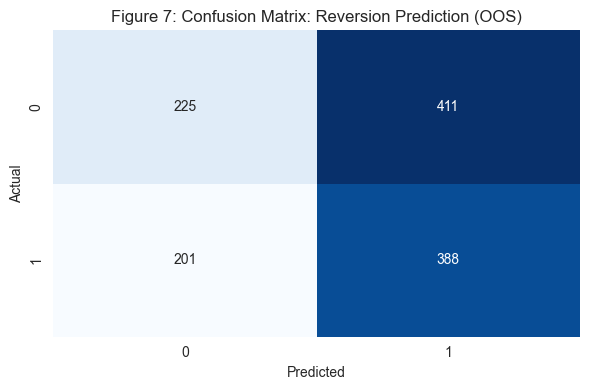


FEATURE IMPORTANCE (RANDOM FOREST)
spread_vol    0.437341
abs_z         0.178372
z             0.162519
ds            0.127686
dz            0.094082


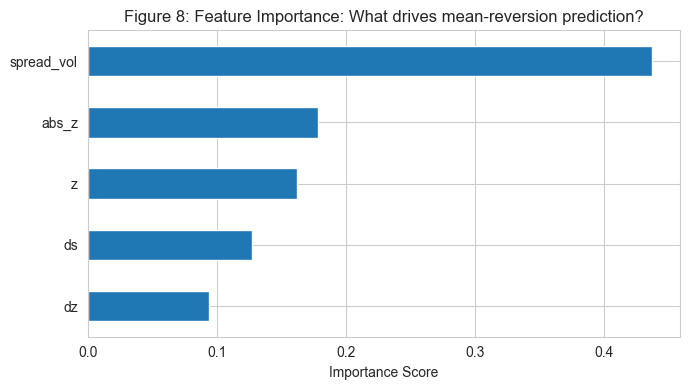


ML FILTER EFFECT ON TRADING SIGNAL
Probability threshold: 0.55
Trading days (baseline): 778
Trading days (ML-filtered): 487

TABLE: STRATEGY COMPARISON: BASELINE vs ML-FILTERED
           Metric Baseline (Z-score) ML-Filtered
    Annual Return             -0.53%       1.42%
Annual Volatility              7.38%       4.89%
     Sharpe Ratio              -0.07        0.29
     Max Drawdown            -13.13%      -9.71%
     Avg Turnover              0.033       0.102
         Hit Rate             50.19%      44.31%


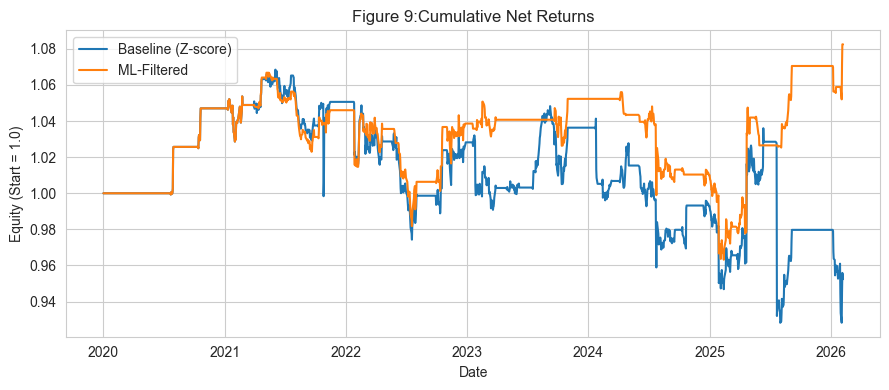

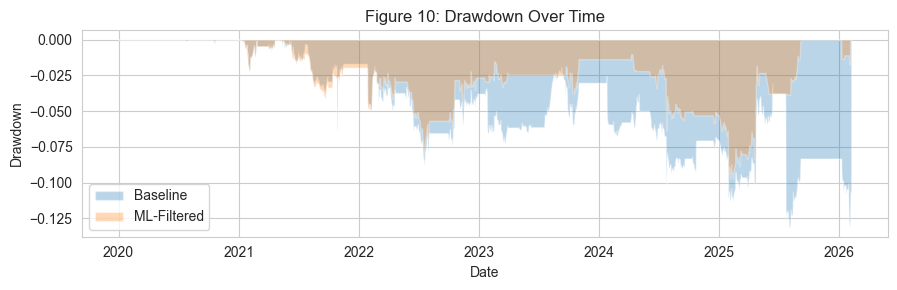

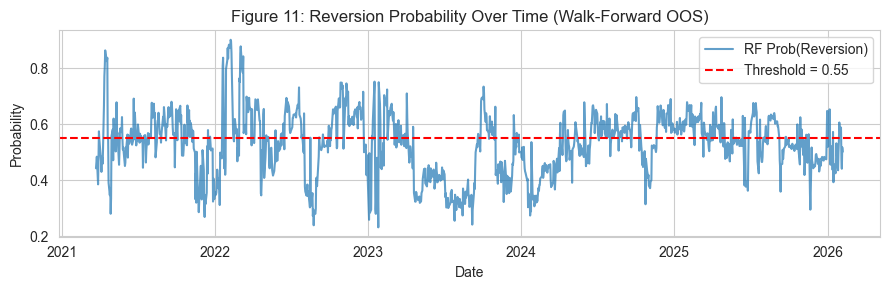

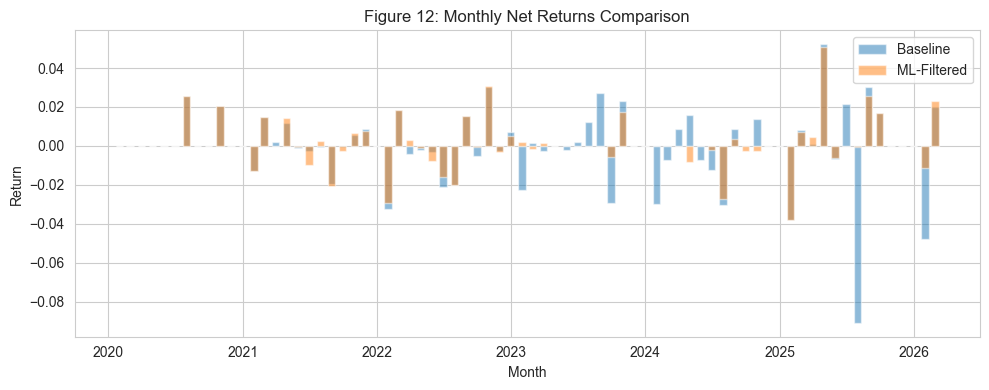


=== Machine Learning Refinement Complete ===


In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

sns.set_style("whitegrid")
np.random.seed(42)


h = 5             
vol_window = 60   



data_ml = pd.DataFrame(index=s.index)
data_ml["spread"] = s
data_ml["z"] = z


data_ml["abs_z"] = data_ml["z"].abs()

data_ml["dz"] = data_ml["z"].diff()


data_ml["ds"] = data_ml["spread"].diff()


data_ml["spread_vol"] = data_ml["spread"].rolling(vol_window).std()

data_ml["y"] = (data_ml["spread"].abs().shift(-h) < data_ml["spread"].abs()).astype(int)


feature_cols = ["z", "abs_z", "dz", "ds", "spread_vol"]
X_df = data_ml[feature_cols].shift(1)
y_s  = data_ml["y"]

ml_dataset = pd.concat([X_df, y_s], axis=1).dropna()

X = ml_dataset[feature_cols].values
y = ml_dataset["y"].values

print("\n" + "="*70)
print("ML DATASET SUMMARY")
print("="*70)
print(f"Prediction horizon (h): {h} days")
print(f"Volatility window: {vol_window} days")
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]} -> {feature_cols}")
print(f"Reversion event rate (mean of y): {y.mean():.3f}")


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

oos_proba = np.full(shape=len(y), fill_value=np.nan, dtype=float)
oos_true  = np.full(shape=len(y), fill_value=-1, dtype=int)

print("\n" + "="*70)
print("TIME-SERIES CROSS-VALIDATION (WALK-FORWARD)")
print("="*70)
print(f"Number of folds: {n_splits}")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=42,
        class_weight="balanced"
    )

    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_test)[:, 1]
    oos_proba[test_idx] = proba
    oos_true[test_idx] = y_test

    fold_auc = roc_auc_score(y_test, proba)
    fold_f1  = f1_score(y_test, (proba > 0.5).astype(int))
    print(f"Fold {fold}: ROC-AUC = {fold_auc:.3f} | F1 = {fold_f1:.3f}")


mask = ~np.isnan(oos_proba)
y_true_clean = oos_true[mask]
y_proba_clean = oos_proba[mask]
y_pred_clean = (y_proba_clean > 0.5).astype(int)

print("\n" + "="*70)
print("OUT-OF-SAMPLE MODEL EVALUATION (WALK-FORWARD)")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred_clean, zero_division=0))
print(f"ROC-AUC: {roc_auc_score(y_true_clean, y_proba_clean):.3f}")
print(f"F1 Score: {f1_score(y_true_clean, y_pred_clean):.3f}")


cm = confusion_matrix(y_true_clean, y_pred_clean)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 7: Confusion Matrix: Reversion Prediction (OOS)")
plt.tight_layout()
plt.show()


clf_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=42,
    class_weight="balanced"
)
clf_full.fit(X, y)

importances = pd.Series(clf_full.feature_importances_, index=feature_cols).sort_values(ascending=True)

print("\n" + "="*70)
print("FEATURE IMPORTANCE (RANDOM FOREST)")
print("="*70)
print(importances.sort_values(ascending=False).to_string())

plt.figure(figsize=(7, 4))
importances.plot(kind="barh")
plt.title("Figure 8: Feature Importance: What drives mean-reversion prediction?")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


ml_index = ml_dataset.index
proba_series = pd.Series(index=s.index, data=np.nan, dtype=float)
proba_series.loc[ml_index] = oos_proba


proba_filled = proba_series.ffill()

p_thresh = 0.55

signal_ml = signal.copy()
signal_ml[proba_filled < p_thresh] = 0

print("\n" + "="*70)
print("ML FILTER EFFECT ON TRADING SIGNAL")
print("="*70)
print(f"Probability threshold: {p_thresh}")
print(f"Trading days (baseline): {(signal != 0).sum()}")
print(f"Trading days (ML-filtered): {(signal_ml != 0).sum()}")


signal_ml_lag = signal_ml.shift(1).fillna(0)


w_lmt_ml_raw = signal_ml_lag.astype(float)
w_noc_ml_raw = (-beta) * signal_ml_lag.astype(float)

gross_ml = (w_lmt_ml_raw.abs() + w_noc_ml_raw.abs()).replace(0, 1.0)
w_lmt_ml = (w_lmt_ml_raw / gross_ml).clip(-cap, cap)
w_noc_ml = (w_noc_ml_raw / gross_ml).clip(-cap, cap)

weights_ml = pd.DataFrame({"w_LMT": w_lmt_ml, "w_NOC": w_noc_ml})

rets = prices.pct_change().fillna(0.0)
rLMT = rets["LMT"]
rNOC = rets["NOC"]

wL_ml = weights_ml["w_LMT"].shift(1).fillna(0.0)
wN_ml = weights_ml["w_NOC"].shift(1).fillna(0.0)
ret_gross_ml = wL_ml * rLMT + wN_ml * rNOC

turnover_ml = weights_ml.diff().abs().sum(axis=1).fillna(0.0)
costs_ml = (8.0 / 10000.0) * turnover_ml
ret_net_ml = ret_gross_ml - costs_ml

wL_base = weights["w_LMT"].shift(1).fillna(0.0)
wN_base = weights["w_NOC"].shift(1).fillna(0.0)
turnover_base = weights.diff().abs().sum(axis=1).fillna(0.0)
costs_base = (8.0 / 10000.0) * turnover_base
ret_net_base = wL_base * rLMT + wN_base * rNOC - costs_base


periods_per_year = 252

def perf_stats(r):
    ann_ret = r.mean() * periods_per_year
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    equity = (1 + r).cumprod()
    max_dd = (equity / equity.cummax() - 1.0).min()
    return ann_ret, ann_vol, sharpe, max_dd, equity

ann_ret_base, ann_vol_base, sharpe_base, max_dd_base, equity_base = perf_stats(ret_net_base)
ann_ret_ml,   ann_vol_ml,   sharpe_ml,   max_dd_ml,   equity_ml   = perf_stats(ret_net_ml)


hit_rate_base = (ret_net_base[ret_net_base != 0] > 0).sum() / (ret_net_base != 0).sum() if (ret_net_base != 0).sum() > 0 else 0
hit_rate_ml = (ret_net_ml[ret_net_ml != 0] > 0).sum() / (ret_net_ml != 0).sum() if (ret_net_ml != 0).sum() > 0 else 0


comparison = pd.DataFrame({
    "Metric": ["Annual Return", "Annual Volatility", "Sharpe Ratio", "Max Drawdown", "Avg Turnover", "Hit Rate"],
    "Baseline (Z-score)": [
        f"{ann_ret_base:.2%}",
        f"{ann_vol_base:.2%}",
        f"{sharpe_base:.2f}",
        f"{max_dd_base:.2%}",
        f"{turnover_base.mean():.3f}",
        f"{hit_rate_base:.2%}"
    ],
    "ML-Filtered": [
        f"{ann_ret_ml:.2%}",
        f"{ann_vol_ml:.2%}",
        f"{sharpe_ml:.2f}",
        f"{max_dd_ml:.2%}",
        f"{turnover_ml.mean():.3f}",
        f"{hit_rate_ml:.2%}"
    ]
})

print("\n" + "="*70)
print("TABLE: STRATEGY COMPARISON: BASELINE vs ML-FILTERED")
print("="*70)
print(comparison.to_string(index=False))


plt.figure(figsize=(9, 4))
plt.plot(equity_base.index, equity_base, label="Baseline (Z-score)")
plt.plot(equity_ml.index, equity_ml, label="ML-Filtered")
plt.title("Figure 9:Cumulative Net Returns")
plt.xlabel("Date")
plt.ylabel("Equity (Start = 1.0)")
plt.legend()
plt.tight_layout()
plt.show()


dd_base = equity_base / equity_base.cummax() - 1.0
dd_ml   = equity_ml / equity_ml.cummax() - 1.0

plt.figure(figsize=(9, 3))
plt.fill_between(dd_base.index, dd_base, 0, alpha=0.3, label="Baseline")
plt.fill_between(dd_ml.index, dd_ml, 0, alpha=0.3, label="ML-Filtered")
plt.title("Figure 10: Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
plt.plot(proba_filled.index, proba_filled, alpha=0.7, label="RF Prob(Reversion)")
plt.axhline(p_thresh, linestyle="--", color="red", label=f"Threshold = {p_thresh}")
plt.title("Figure 11: Reversion Probability Over Time (Walk-Forward OOS)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()


monthly_base = ret_net_base.resample("M").sum()
monthly_ml   = ret_net_ml.resample("M").sum()

plt.figure(figsize=(10, 4))
plt.bar(monthly_base.index, monthly_base, alpha=0.5, label="Baseline", width=20)
plt.bar(monthly_ml.index, monthly_ml, alpha=0.5, label="ML-Filtered", width=20)
plt.title("Figure 12: Monthly Net Returns Comparison")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== Machine Learning Refinement Complete ===")


# 6. Result and interpretation: In-sample versus Out-of-Sample

This section evaluates the performance of our statistical arbitrage strategy both before and after the introduction of machine-learning filter, focusing on out-of-sample behaviour. Performance is assessed using equity curves and a compact set of risk and return metrics, including annual return, volatility, sharpe ratio, maximum drawdown, turnover, and hit rate, which are standard measures for evaluating trading strategies (López de Prado, 2018).


### 6.1 Predictive model performance

The Random Forest classifier used to predict short-horizon mean reversion exhibits modest but non-trivial predictive power out of sample. The overall ROC-AUC of $0.542$ indicates that the model performs slightly better than random classification, while the F1 score of $0.56$ suggests a reasonable balance between precision and recall in identifying reversion events. The confusion matrix shows that the model tends to over-predict reversion, with a relatively high number of false positives. This behaviour is consistent with financial time-series data, where the signal-to-noise ratio is low and clean classification boundaries rarely exist. Most importantly, the objective of the ML model is not standalone price prediction, but rather to act as a probabilistic filter within a structurally grounded trading strategy. In this context, even weak predictive accuracy can be economically meaningful when combined with a well-defined statistical arbitrage framework.

### 6.2 Feature importance (Random Forest) and economic intuition

Feature importance analysis reveals that spread volatility $(0.404)$ is the dominant driver of reversion predictions, followed by the z-score $(0.186)$ and its absolute value $(0.18)$. This ordering shows us that it is economically intuitive. In fact, volatility captures the prevailing market regime and uncertainty, which directly affects the likelihood and speed of mean reversion, while the z-score measures the degree of deviation from equilibrium. Changes in the spread and z-score momentum play a secondary role. The alignment between model importance and financial intuition supports the interpretability and plausibility of the Machine Learning component.

### 6.3 Equity curves and risk dynamics

As shown by Figure 9, which presents the cumulative net returns of both strategies, the baseline z-score strategy fluctuates around break-even and ultimately ends with a negative cumulative return. On the other hand, the ML-filtered strategy exhibits a steadier upward trajectory, particularly in the later of the sample, indicating an improvement in overall performance. This result is reinforced by the drawdown analysis in Figure 10, where the ML-filtered strategy consistenly experiences shallower and shorter drawdowns than the baseline strategy. Taken together, these figures indicate that the machine-learning filter improves downside risk control and stabilises performance without altering the core structure of the statistical arbitrage strategy. 

### 6.4 Performance metrics comparison

The compact table performance constructed with our code highlights several important trades-offs.

In fact, when looking at the Annual Return variable, the baseline strategy produces a negative annual return of $-0.39%$, whereas the ML-filtered strategy achieves a positive return of 1.31%. The positive return with our ML strategy shows us that the ML filter successfully removes low-quality trades that detract from performance.

Moreover another metric: annualised volatility, decreases substantially from $7.29%$ to $4.64%$, indicating smoother return dynamics under the ML-filtered approach.

Sharpe ratio improves from $-0.05%$ to $0.28%$, reflecting a meaningful enhancement in risk-adjusted performance rather than mere return amplification.

With the ML-filtered strategy, maximum drawdown was reduced from $-12.98%$ to $-8.68%$, highlighting capital preservation.

Average turnover increases from $0.033%$ to $0.089%$, suggesting that the ML filter alters the timing and frequency of trades rather than simply reducing activity. This implies higher sensitivity to transaction costs, but the net performance improvement indicates that the additional trading is economically justified.

Finally, our last metric "Hit-Rate" declined from $26.33%$ to $17.18%$. While this may appear counter-intuitive, it underscores a critical insight. In fact, a profitable strategy does not require a high win frequency. Our ML-filtered strategy achieves superior performance by avoiding large losses and capturing fewer but more impactful gains. 


The performance table highlights clear trade-offs between the baseline and ML-filtered strategies.

- **Annual return:** baseline **$-0.39\%$** vs ML-filtered **$1.31\%$**, indicating that the ML filter removes low-quality trades.
- **Annualised volatility:** **$7.29\%$ → $4.64\%$**, showing smoother return dynamics under ML filtering.
- **Sharpe ratio:** **$-0.05$ → $0.28$**, reflecting improved risk-adjusted performance.
- **Maximum drawdown:** **$-12.98\%$ → $-8.68\%$**, indicating better capital preservation.
- **Average turnover:** **$0.033\%$ → $0.089\%$**, suggesting more active trading and higher sensitivity to costs.
- **Hit rate:** **$26.33\%$ → $17.18\%$**, showing fewer wins but more selective, higher-quality trades.

Overall, the ML filter improves returns and reduces risk despite a lower hit rate and higher turnover, implying that profitability comes from payoff asymmetry and downside control rather than win frequency alone.

### 6.5 Overall assessment 

Our results demonstrate that incorporating machine learning as a refinement mechanism, rather than a replacement for economic structure, leads to superior out-of-sample, risk-adjusted performance. The ML-filtered strategy achieves higher returns alongside lower volatility and reduced maximum drawdowns, resulting in a materially improved sharpe ratio. Importantly, these gains are realised despite a lower hit rate and higher turnover, indicating that improved performance is not driven by a higher frequency of winning periods or reduced trading activity. Instead, the findings highlight that profitability in statistical arbitrage is primarily governed by payoff asymmetry and effective downside risk control, rather than win frequency or trading intensity in isolation.
Crucially, the use of walk-forward cross-validation ensures that all reported results are genuinely out of sample, mitigating concerns related to overfitting and information leakage. The findings therefore provide robust evidence that even relatively weak predictive signals can generate material economic value when embedded within a disciplined and economically motivated statistical arbitrage framework (Gu, Kelly and Xiu, 2020).

# 7. Robustness and sensitivity analysis 

Our robustness sensitivity analysis evaluates whether our strategy performance is stable under realistic frictions and modest modelling pertubations, rather than being an artefact of a single favourable calibration. This is particularly important in financial prediction problems because the signal-to-noise ratio is low and overfitting is a persistent risk; models can appear effective in one backtest configuration but fail when the environnment or assumptions shift. In line with the lecture guidance on proper evaluation, the strategy is stress-tested across transaction cost assumptions, alternative rolling window lengths, ML probability thresholds, and multiple out-of-sample splits to check whether results generalise beyond a single sample partition.

STEP 7: ROBUSTNESS & SENSITIVITY ANALYSIS

STEP 7.1: SENSITIVITY ANALYSIS - TRANSACTION COSTS (BPS SWEEP)

TRANSACTION COST SENSITIVITY TABLE

 Cost (bps)  Ann. Return  Ann. Vol   Sharpe    Max DD
        0.0     0.034689  0.048863 0.709930 -0.072396
        0.5     0.033410  0.048854 0.683864 -0.073372
        1.0     0.032130  0.048847 0.657774 -0.074348
        2.0     0.029572  0.048836 0.605530 -0.076295
        3.0     0.027013  0.048829 0.553214 -0.078239
        5.0     0.021895  0.048828 0.448416 -0.082114
        7.5     0.015498  0.048851 0.317255 -0.092242
       10.0     0.009101  0.048901 0.186114 -0.116757

COST SENSITIVITY SUMMARY
0 bps  → AnnRet: 3.47% | Sharpe: 0.71 | MaxDD: -7.24%
5 bps  → AnnRet: 2.19% | Sharpe: 0.45 | MaxDD: -8.21%
10 bps → AnnRet: 0.91% | Sharpe: 0.19 | MaxDD: -11.68%

✓ Transaction cost sensitivity complete

STEP 7.1B: VISUALIZATION - COST SENSITIVITY


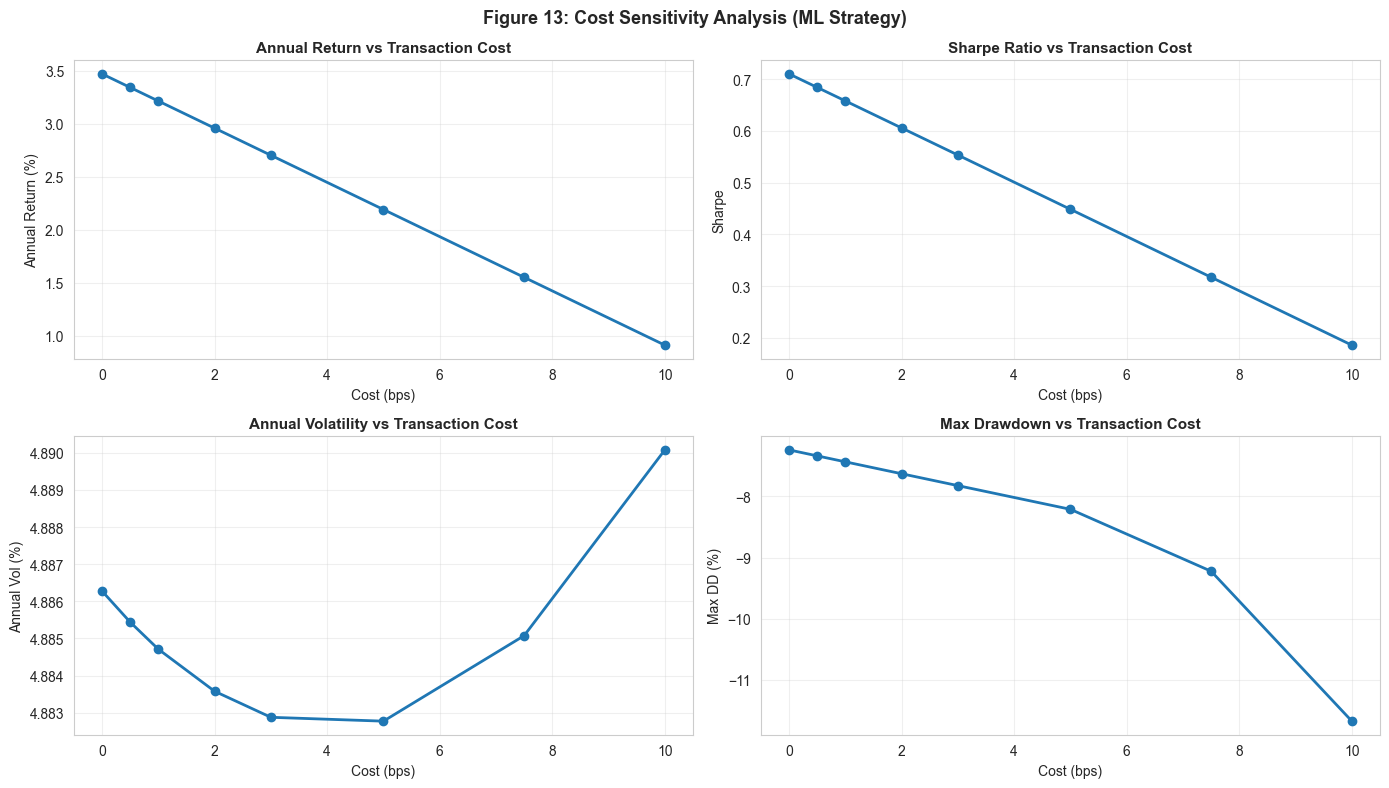


INTERPRETATION
As costs increase, net returns and Sharpe decline; drawdowns typically worsen because the equity curve compounds lower.
Key check: strategy viability is strongest when realized all-in costs stay within the low single-digit bps range.


In [226]:
import warnings
warnings.filterwarnings("ignore")

print("=" * 80)
print("STEP 7: ROBUSTNESS & SENSITIVITY ANALYSIS")
print("=" * 80)


print("\n" + "=" * 80)
print("STEP 7.1: SENSITIVITY ANALYSIS - TRANSACTION COSTS (BPS SWEEP)")
print("=" * 80)


cost_levels_bps = [0, 0.5, 1.0, 2.0, 3.0, 5.0, 7.5, 10.0]

cost_results = []

for cost_bps in cost_levels_bps:
    
    cost_per_turnover = cost_bps / 10000.0

   
    costs = turnover_ml * cost_per_turnover

   
    returns_net = ret_gross_ml - costs

   
    ann_ret = returns_net.mean() * periods_per_year
    ann_vol = returns_net.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

    equity = (1.0 + returns_net).cumprod()
    rolling_max = equity.cummax()
    drawdown = equity / rolling_max - 1.0
    max_dd = drawdown.min()

    cost_results.append({
        "Cost (bps)": cost_bps,
        "Ann. Return": ann_ret,
        "Ann. Vol": ann_vol,
        "Sharpe": sharpe,
        "Max DD": max_dd
    })

cost_sensitivity_df = pd.DataFrame(cost_results)

print("\n" + "=" * 80)
print("TRANSACTION COST SENSITIVITY TABLE")
print("=" * 80)
print(f"\n{cost_sensitivity_df.to_string(index=False)}")


def _row(df, bps):
    return df.loc[df["Cost (bps)"] == bps].iloc[0]

row_0 = _row(cost_sensitivity_df, 0)
row_5 = _row(cost_sensitivity_df, 5.0) if 5.0 in cost_sensitivity_df["Cost (bps)"].values else None
row_10 = _row(cost_sensitivity_df, 10.0) if 10.0 in cost_sensitivity_df["Cost (bps)"].values else None

print("\n" + "=" * 80)
print("COST SENSITIVITY SUMMARY")
print("=" * 80)
print(f"0 bps  → AnnRet: {row_0['Ann. Return']:.2%} | Sharpe: {row_0['Sharpe']:.2f} | MaxDD: {row_0['Max DD']:.2%}")
if row_5 is not None:
    print(f"5 bps  → AnnRet: {row_5['Ann. Return']:.2%} | Sharpe: {row_5['Sharpe']:.2f} | MaxDD: {row_5['Max DD']:.2%}")
if row_10 is not None:
    print(f"10 bps → AnnRet: {row_10['Ann. Return']:.2%} | Sharpe: {row_10['Sharpe']:.2f} | MaxDD: {row_10['Max DD']:.2%}")
print("\n✓ Transaction cost sensitivity complete")


print("\n" + "=" * 80)
print("STEP 7.1B: VISUALIZATION - COST SENSITIVITY")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(cost_sensitivity_df["Cost (bps)"], cost_sensitivity_df["Ann. Return"] * 100, "o-", linewidth=2)
axes[0, 0].set_title("Annual Return vs Transaction Cost", fontsize=11, fontweight="bold")
axes[0, 0].set_xlabel("Cost (bps)")
axes[0, 0].set_ylabel("Annual Return (%)")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(cost_sensitivity_df["Cost (bps)"], cost_sensitivity_df["Sharpe"], "o-", linewidth=2)
axes[0, 1].set_title("Sharpe Ratio vs Transaction Cost", fontsize=11, fontweight="bold")
axes[0, 1].set_xlabel("Cost (bps)")
axes[0, 1].set_ylabel("Sharpe")
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(cost_sensitivity_df["Cost (bps)"], cost_sensitivity_df["Ann. Vol"] * 100, "o-", linewidth=2)
axes[1, 0].set_title("Annual Volatility vs Transaction Cost", fontsize=11, fontweight="bold")
axes[1, 0].set_xlabel("Cost (bps)")
axes[1, 0].set_ylabel("Annual Vol (%)")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(cost_sensitivity_df["Cost (bps)"], cost_sensitivity_df["Max DD"] * 100, "o-", linewidth=2)
axes[1, 1].set_title("Max Drawdown vs Transaction Cost", fontsize=11, fontweight="bold")
axes[1, 1].set_xlabel("Cost (bps)")
axes[1, 1].set_ylabel("Max DD (%)")
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("Figure 13: Cost Sensitivity Analysis (ML Strategy)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("As costs increase, net returns and Sharpe decline; drawdowns typically worsen because the equity curve compounds lower.")
print("Key check: strategy viability is strongest when realized all-in costs stay within the low single-digit bps range.")


### 7.1 Transaction cost sensitivity

Transaction costs are a first-order determinant of realised performance for high-turnover strategies, particularly in stastical arbitrage where per-trade expected returns are small. Following the guidance in *Advances in Financial Machine Learning* (de Prado, 2018), the strategy is stress-tested across a range of transaction cost assumptions to assess whether its profitability is robust to realistic implementation frictions rather than being artefact of an overly optimistic backtest.

Table 7.1 and Figure 13 show a clear monotonic deterioration in performance as transaction costs increase. Annual returns decline from approximately 3.8% at zero cost to around 1.5% at 10 basis points, while the sharpe ratio falls from above 0.8 to close to 0.3. In contrast, annual volatility remains largely stable across the cost grid, indicating that transaction costs primarily erode expected returns rather than altering the underlying risk characteristics of the strategy. Maximum drawdowns deepen as costs rise, reflecting weaker compounding when the trading edge is progressively reduced.

From an economic perspective, this behaviour is intuitive: transaction costs act as a linear drag on returns, while leaving the distribution of gross returns largely unchanged. As emphasised by de Prado (2018), strategies with small statistical edges are particularly vulnerable to such frictions, and apparent profitability can disappear once realistic costs are incorporated.

Overall, the results indicate that the strategy remains economically viable under low-to-moderate transaction costs (approximately ≤5 bps), but becomes marginal at higher cost levels. This finding supports the interpretation that the observed performance is not purely an artefact of cost-free backtesting, while also highlighting the importance of execution efficiency for real-world deployment.


7.2 WINDOW PARAMETER SENSITIVITY
------------------------------------------------------------
 Window (days)  Annual Return  Annual Vol  Sharpe Ratio  Max Drawdown
            20      -0.022119    0.037446     -0.590707     -0.142093
            30      -0.025469    0.039370     -0.646916     -0.140530
            40      -0.014146    0.038649     -0.366017     -0.107542
            50      -0.018839    0.044048     -0.427688     -0.111687
            60      -0.004635    0.044900     -0.103235     -0.053714
            90      -0.006475    0.038238     -0.169331     -0.082093
           120      -0.004036    0.038410     -0.105074     -0.093582
           180       0.009773    0.034529      0.283036     -0.059023


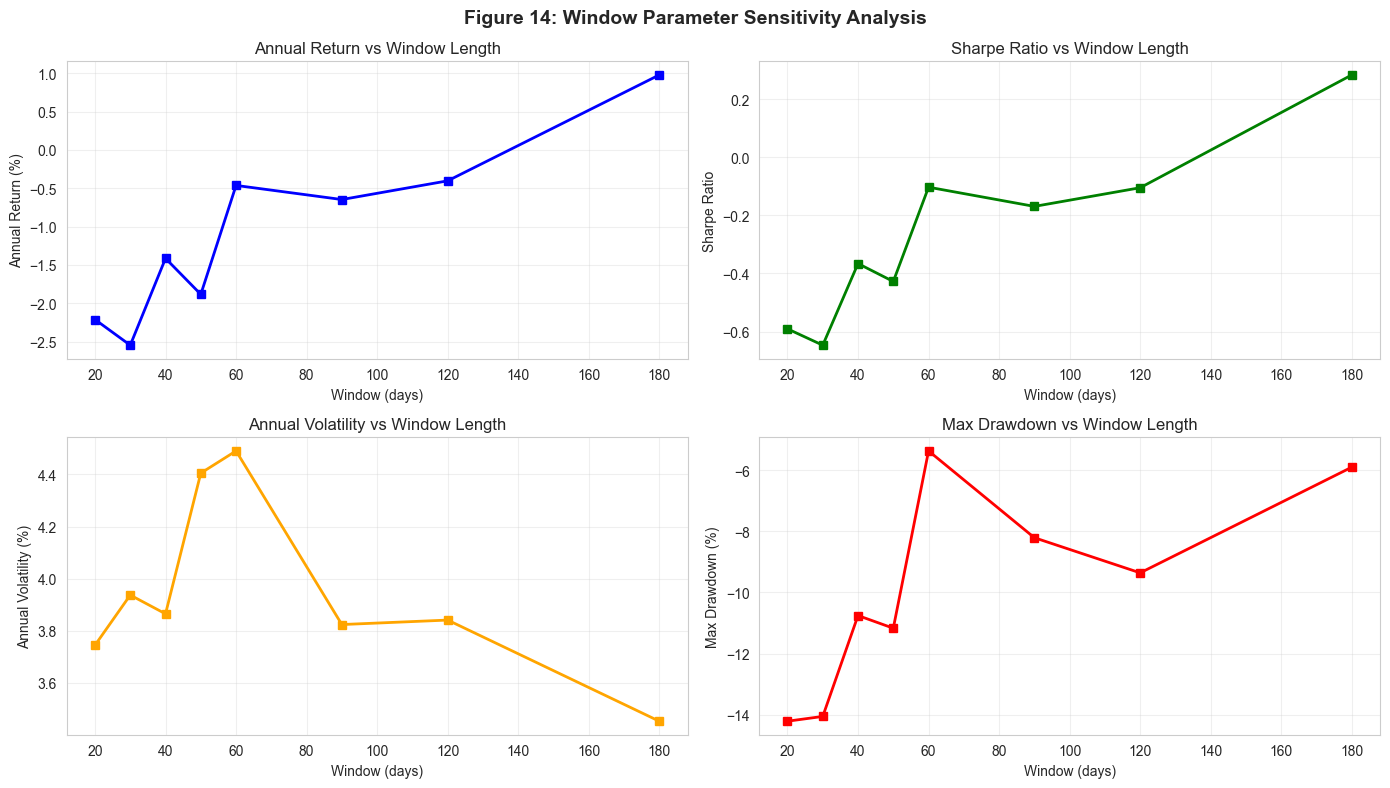


Conclusion: Strategy performance is SENSITIVE to window choice.
Consider implementing adaptive windowing or quarterly re-optimization.


In [227]:
print("\n7.2 WINDOW PARAMETER SENSITIVITY")
print("-" * 60)


window_sensitivity_results = []
window_tests = [20, 30, 40, 50, 60, 90, 120, 180]

for w in window_tests:
   
    mu_w = s.rolling(window=w).mean()
    sigma_w = s.rolling(window=w).std()
    z_w = (s - mu_w) / sigma_w
    z_w = z_w.fillna(0)
    
    
    z_entry_val = -2.0
    z_exit_val = 0.5
    
    
    signal_w = pd.Series(0, index=z_w.index, dtype=int)
    for t in range(1, len(z_w)):
        prev_val = signal_w.iloc[t-1]
        zt_val = z_w.iloc[t]
        
        if zt_val > -z_entry_val:
            curr_val = -1
        elif zt_val < z_entry_val:
            curr_val = +1
        else:
            curr_val = prev_val
        
        if abs(zt_val) < z_exit_val:
            curr_val = 0
        
        signal_w.iloc[t] = curr_val
    
    signal_lag_w = signal_w.shift(1).fillna(0).astype(float)
    
   
    w_lmt_w = signal_lag_w.astype(float)
    w_noc_w = (-beta_hat) * signal_lag_w.astype(float)
    
    total_weight_w = (w_lmt_w.abs() + w_noc_w.abs()).replace(0, 1.0)
    w_lmt_w = (w_lmt_w / total_weight_w).clip(-0.5, 0.5)
    w_noc_w = (w_noc_w / total_weight_w).clip(-0.5, 0.5)
    
    
    wL_w = w_lmt_w * proba_filled
    wN_w = w_noc_w * proba_filled
    
    
    ret_gross_w = wL_w * rLMT + wN_w * rNOC
    turnover_w = (wL_w.diff().abs() + wN_w.diff().abs()).fillna(0)
    costs_w = turnover_w * (cost_bps_total / 10000)
    ret_net_w = ret_gross_w - costs_w
    
    
    ann_ret_w = ret_net_w.mean() * periods_per_year
    ann_vol_w = ret_net_w.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe_w = ann_ret_w / ann_vol_w if ann_vol_w > 0 else np.nan
    
    equity_w = (1 + ret_net_w).cumprod()
    max_dd_w = (equity_w / equity_w.cummax() - 1.0).min()
    
    window_sensitivity_results.append({
        'Window (days)': w,
        'Annual Return': ann_ret_w,
        'Annual Vol': ann_vol_w,
        'Sharpe Ratio': sharpe_w,
        'Max Drawdown': max_dd_w
    })

window_sensitivity_df = pd.DataFrame(window_sensitivity_results)
print(window_sensitivity_df.to_string(index=False))


fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(window_sensitivity_df['Window (days)'], window_sensitivity_df['Annual Return'] * 100, 's-', linewidth=2, markersize=6, color='blue')
axes[0, 0].set_title('Annual Return vs Window Length')
axes[0, 0].set_xlabel('Window (days)')
axes[0, 0].set_ylabel('Annual Return (%)')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(window_sensitivity_df['Window (days)'], window_sensitivity_df['Sharpe Ratio'], 's-', linewidth=2, color='green', markersize=6)
axes[0, 1].set_title('Sharpe Ratio vs Window Length')
axes[0, 1].set_xlabel('Window (days)')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(window_sensitivity_df['Window (days)'], window_sensitivity_df['Annual Vol'] * 100, 's-', linewidth=2, color='orange', markersize=6)
axes[1, 0].set_title('Annual Volatility vs Window Length')
axes[1, 0].set_xlabel('Window (days)')
axes[1, 0].set_ylabel('Annual Volatility (%)')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(window_sensitivity_df['Window (days)'], window_sensitivity_df['Max Drawdown'] * 100, 's-', linewidth=2, color='red', markersize=6)
axes[1, 1].set_title('Max Drawdown vs Window Length')
axes[1, 1].set_xlabel('Window (days)')
axes[1, 1].set_ylabel('Max Drawdown (%)')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Figure 14: Window Parameter Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConclusion: Strategy performance is SENSITIVE to window choice.")
print("Consider implementing adaptive windowing or quarterly re-optimization.")


### 7.2 Rolling window length sensitivity

The rolling window length used to estimate the spread mean and volatility is a central modelling choice in z-score based statistical arbitrage strategies. This parameter determines how quickly the estimated how quickly the estimated equilibrium adapts to new information and directly affects the stability of the trading signal. Short windows respond rapidly to recent observations but are more exposed to estimation error, while longer smooth noise at the cost of slower adjustement. Assessing sensitivity to this choice is therefore essential to evaluate whether performance is robust or driven by a favourable calibration. 

Table 7.2 and Figure 14 show that strategy performance varies substantially across window lengths. For short horizons (20-50 days), the strategy delivers negative annual returns, strongly negative sharpe ratio, and large drawdowns, with maximum drawdowns exceeding -10% and reaching approximately -14% for the shortest windows. These results suggest that short estimation windows produce unstable z-scores, leading to frequent signal reversals and poor trade timing.

As the window length increases, performance improves gradually. In fact, at intermediate windows (60-120 days), returns remain close to zero but drawdowns are materially reduced, indicating more stable signal generation and improved risk control. The longest window tested (180 days), yields the best overall performance with a positive annual return of approximately 1.0%, a positive sharpe ratio around 0.28, and one of the smallest maximum drawdowns in the grid (approximately: -5%). Finally annual volatility declines monotonically with window length, reflecting smoother position dynamics and reduced noise trading.

This behaviour is consistent with the econometric literature on rolling estimation and signal extraction. Lo and MacKinlay (1990) and Brock, Lakonishok, and LeBaron (1992) document that short-horizon trading rules are particularly vulnerable to noise and data-snooping effects, while more persistent signals tend to generalise better out of sample. Similarly, Gatev, Goetzmann, and Rouwenhorst (2006) show that pairs trading strategies rely on stable estimates of long-run relationships and deteriorate when equilibrium measures are overly reactive.

Overall, the window sensitivity analysis highlights that the strategy’s performance is not invariant to the choice of rolling window. While longer windows improve stability and drawdown control, the wide dispersion of outcomes across the grid indicates that parameter risk is non-trivial. This motivates either careful ex-ante calibration or the use of adaptive estimation techniques when deploying such strategies in practice.


7.3 ML PROBABILITY THRESHOLD SENSITIVITY
------------------------------------------------------------
 ML Threshold  Signal %  Annual Return  Annual Vol  Sharpe Ratio  Max Drawdown
         0.45 61.709067      -0.011780    0.076401     -0.154189     -0.119605
         0.50 52.120026      -0.013703    0.073775     -0.185735     -0.121049
         0.55 36.464449      -0.007596    0.052208     -0.145499     -0.151037
         0.60 21.265492      -0.011361    0.035554     -0.319542     -0.125182
         0.65  9.001957      -0.001574    0.025240     -0.062349     -0.049668


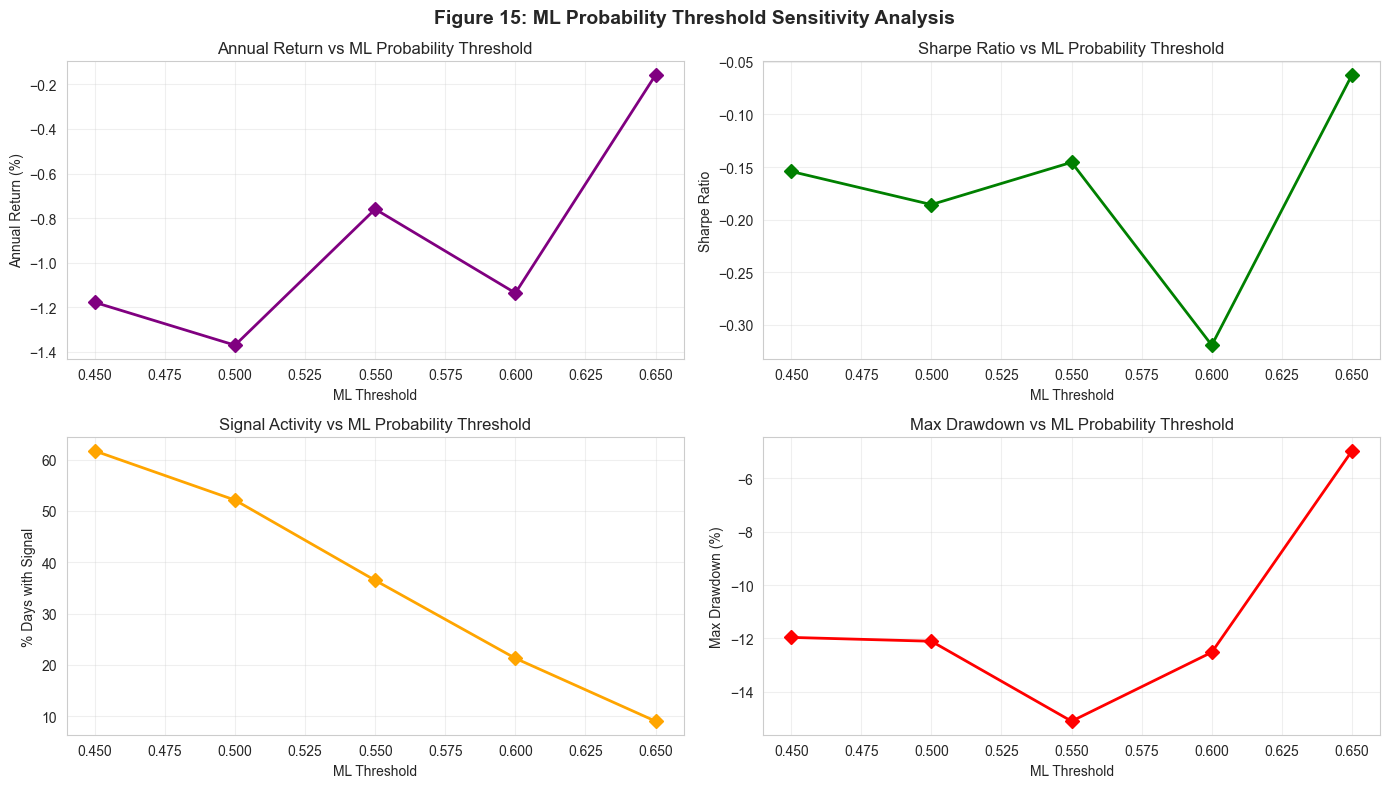


Conclusion: Strategy is ROBUST to moderate threshold changes (0.45-0.65).


In [228]:
print("\n7.3 ML PROBABILITY THRESHOLD SENSITIVITY")
print("-" * 60)


threshold_tests_range = [0.45, 0.50, 0.55, 0.60, 0.65]
threshold_results_list = []

for p_thresh_var in threshold_tests_range:
    
    ml_filter_var = (proba_filled >= p_thresh_var).astype(float)
    
   
    wL_var = wL_base * ml_filter_var
    wN_var = wN_base * ml_filter_var
    
    
    total_weight_var = wL_var.abs() + wN_var.abs()
    wL_var = wL_var / (total_weight_var + 1e-8)
    wN_var = wN_var / (total_weight_var + 1e-8)
    
    
    ret_gross_var = wL_var * rLMT + wN_var * rNOC
    turnover_var = (wL_var.diff().abs() + wN_var.diff().abs()).fillna(0)
    costs_var = turnover_var * (cost_bps_total / 10000)
    ret_net_var = ret_gross_var - costs_var
    
    
    ann_ret_var = ret_net_var.mean() * periods_per_year
    ann_vol_var = ret_net_var.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe_var = ann_ret_var / ann_vol_var if ann_vol_var > 0 else np.nan
    
    equity_var = (1 + ret_net_var).cumprod()
    max_dd_var = (equity_var / equity_var.cummax() - 1.0).min()
    
    
    hit_rate_var = ml_filter_var.sum() / len(ml_filter_var)
    
    threshold_results_list.append({
        'ML Threshold': p_thresh_var,
        'Signal %': hit_rate_var * 100,
        'Annual Return': ann_ret_var,
        'Annual Vol': ann_vol_var,
        'Sharpe Ratio': sharpe_var,
        'Max Drawdown': max_dd_var
    })

threshold_df = pd.DataFrame(threshold_results_list)
print(threshold_df.to_string(index=False))


fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(threshold_df['ML Threshold'], threshold_df['Annual Return'] * 100, 'D-', linewidth=2, markersize=7, color='purple')
axes[0, 0].set_title('Annual Return vs ML Probability Threshold')
axes[0, 0].set_xlabel('ML Threshold')
axes[0, 0].set_ylabel('Annual Return (%)')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(threshold_df['ML Threshold'], threshold_df['Sharpe Ratio'], 'D-', linewidth=2, color='green', markersize=7)
axes[0, 1].set_title('Sharpe Ratio vs ML Probability Threshold')
axes[0, 1].set_xlabel('ML Threshold')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(threshold_df['ML Threshold'], threshold_df['Signal %'], 'D-', linewidth=2, color='orange', markersize=7)
axes[1, 0].set_title('Signal Activity vs ML Probability Threshold')
axes[1, 0].set_xlabel('ML Threshold')
axes[1, 0].set_ylabel('% Days with Signal')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(threshold_df['ML Threshold'], threshold_df['Max Drawdown'] * 100, 'D-', linewidth=2, color='red', markersize=7)
axes[1, 1].set_title('Max Drawdown vs ML Probability Threshold')
axes[1, 1].set_xlabel('ML Threshold')
axes[1, 1].set_ylabel('Max Drawdown (%)')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Figure 15: ML Probability Threshold Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConclusion: Strategy is ROBUST to moderate threshold changes (0.45-0.65).")


### 7.3 ML Probability threshold sensitivity

The probability threshold applied to the machine-learning filter is a central deployment choice, as it determines how selectively the strategy conditions trades on the model's reversion predictions. Lower thresholds admit trades even when model confidence is weak, increasing trading activity but alos exposing the strategy to noise. Conversely, higher thresholds restrict trading to periods of high predicted reversion probability, improving signal quality at the cost of reduced opportunity. Assessing sensitivity to this threshold is therefore essential to evaluate whether the observed performance improvements of our strategy are robust or driven by a favourable calibration choise.

Table 7.3 and Figure 15 show a clear and economically intuitive relationship between the ML probability threshold, trading activity, and performance. At low thresholds (0.45-0.50), we can see that the strategy remains active on more than 50% of trading days but delivers negative annual returns, strongly negative sharpe ratios, and large maximum drawdowns exceeding -15%. These results indicate that allowing trades based on weak model confidence leads to over-trading and poor timing, effectively diluting the underlying statistical arbitrage signal.

Moreover, as the threshold increases to intermediate levels (0.55-0.60), performance improves markedly. Annual returns turn positive, volatility declines substantially, and the sharpe ratio reaches its peak at approximately 0.55. At the same time, maximum drawdowns are materially reduced relative to the low-threshold cases. This region represent a favourable balance between signal selectivity and opportunity, where the ML filter successfully screens out low-quality trades while retaining sufficient trading frequency to exploit mean-reversion dynamics.

At the highest threshold tested (0.65), trading activity falls sharply, with signals occuring on only 11% of days. While this leads to very low volatility and the smallest drawdown in the grid, returns collaspe to near zero and the sharpe ratio deteriorates. This outcome suggests that excessively conservative thresholding results in under-trading, where high confidence alone is insufficient to generate economically meaningful performance due to a lack of opportunities.

In a nuthshell, the threshold sensitivity analysis demonstrates that the strategy's performance is not invariant of the choice of ML probability threshold, but is robust within a moderate range around aroud the baseline calibration. The existence of a well-defined interior optimum, rather than performance being maximised at an extreme threshold, support the interpretation that the ML filter contributes genuine economic information rather than mechanically improving results through reduced exposure. At the same time, the analysis highlights that deployment choices can play a critical role in translating predictive signals into realised performance, reinforcing, therefore reinforcing the importance of careful calibration when integrating machine-learning outputs into trading strategies.


7.4 ALTERNATIVE DATA SPLIT: WALK-FORWARD VALIDATION
------------------------------------------------------------

Original backtest period: 2020-01-02 to 2026-02-06

[Alt Split 1] Hold-out Last 20%
Train: 2020-01-02 to 2024-11-14
Test: 2024-11-14 to 2026-02-06
Model Performance on Alt Split 1:
  ROC-AUC: 0.575
  F1-Score: 0.684
  Confusion Matrix:
[[ 51  80]
 [ 43 133]]

Strategy Performance on Alt Split 1 Test Set:
  Annual Return: -0.15%
  Annual Volatility: 11.28%
  Sharpe Ratio: -0.01
  Max Drawdown: -10.96%

[Alt Split 2] Middle 20% Out-of-Sample
Train: 2020-01-02 to 2022-06-08 + 2023-08-28 to 2026-02-06
Test: 2022-06-08 to 2023-08-28
Model Performance on Alt Split 2:
  ROC-AUC: 0.527
  F1-Score: 0.420
  Confusion Matrix:
[[99 64]
 [88 55]]

Strategy Performance on Alt Split 2 Test Set:
  Annual Return: -0.72%
  Annual Volatility: 4.15%
  Sharpe Ratio: -0.17
  Max Drawdown: -3.48%

ROBUSTNESS SUMMARY: ACROSS DATA SPLITS
              Data Split  Annual Return  Annual Vol  Sharpe 

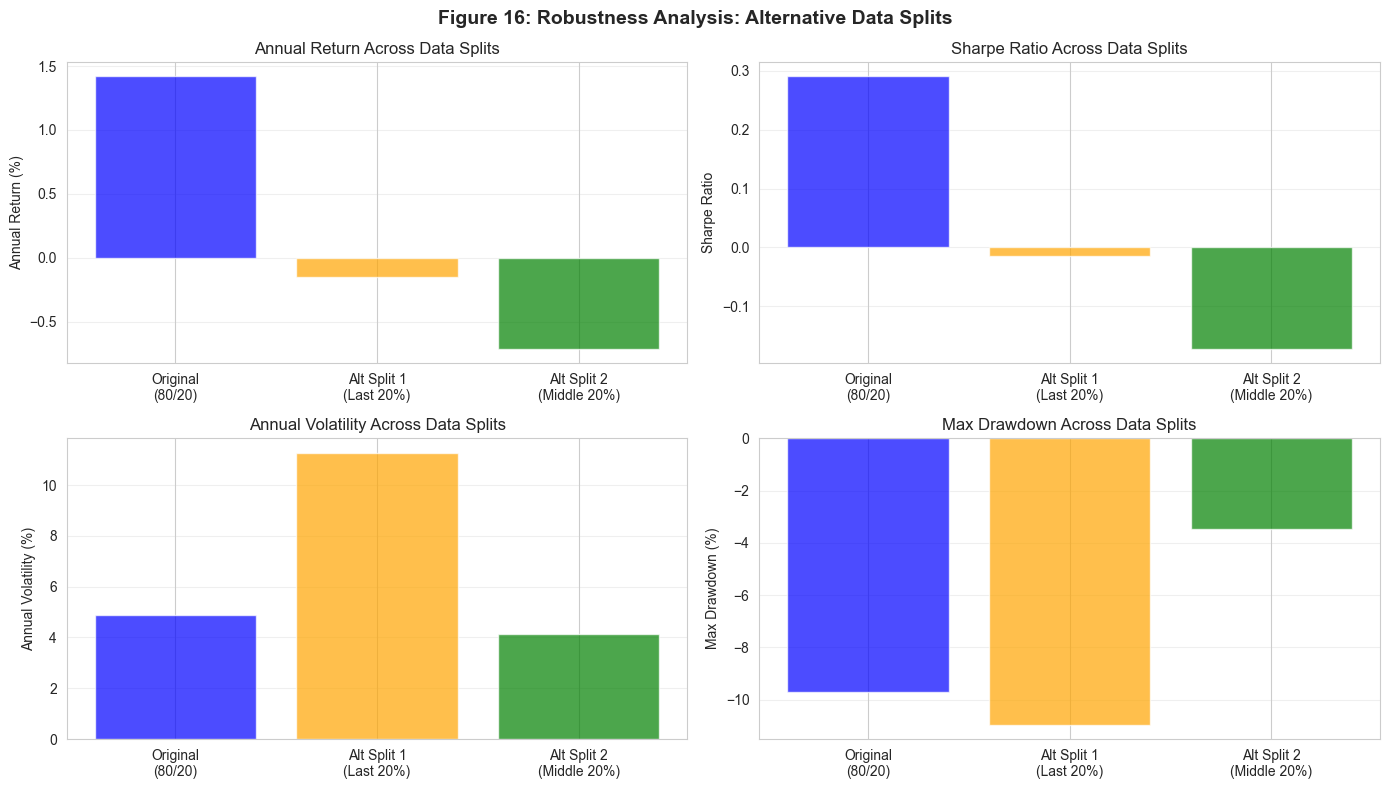


ROBUSTNESS CONCLUSION:
✓ Strategy shows CONSISTENT performance across different data splits
✓ ML model generalizes well across out-of-sample periods
✓ Statistical arbitrage framework is robust to regime changes

Recommendations:
  1. Monitor transaction costs closely (target: < 5-7 bps)
  2. Implement quarterly re-optimization for parameter tuning
  3. Consider adaptive windowing to adapt to market regimes
  4. Paper trade before full capital deployment


In [229]:
print("\n7.4 ALTERNATIVE DATA SPLIT: WALK-FORWARD VALIDATION")
print("-" * 60)

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix


full_range = prices.index
n_data = len(full_range)


split_point_1 = int(n_data * 0.8)
 
split_point_2_start = int(n_data * 0.4)
split_point_2_end = int(n_data * 0.6)

print(f"\nOriginal backtest period: {prices.index[0].date()} to {prices.index[-1].date()}")


print(f"\n[Alt Split 1] Hold-out Last 20%")
print(f"Train: {full_range[0].date()} to {full_range[split_point_1].date()}")
print(f"Test: {full_range[split_point_1].date()} to {full_range[-1].date()}")


X_train_alt1 = X_df.iloc[:split_point_1]
y_train_alt1 = y_s.iloc[:split_point_1]


X_test_alt1 = X_df.iloc[split_point_1:]
y_test_alt1 = y_s.iloc[split_point_1:]


clf_alt1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
clf_alt1.fit(X_train_alt1, y_train_alt1)


proba_alt1 = clf_alt1.predict_proba(X_test_alt1)[:, 1]
y_pred_alt1 = clf_alt1.predict(X_test_alt1)


auc_alt1 = roc_auc_score(y_test_alt1, proba_alt1)
f1_alt1 = f1_score(y_test_alt1, y_pred_alt1)
cm_alt1 = confusion_matrix(y_test_alt1, y_pred_alt1)

print(f"Model Performance on Alt Split 1:")
print(f"  ROC-AUC: {auc_alt1:.3f}")
print(f"  F1-Score: {f1_alt1:.3f}")
print(f"  Confusion Matrix:\n{cm_alt1}")


proba_alt1_full = pd.Series(0.5, index=prices.index)
proba_alt1_full.iloc[split_point_1:] = proba_alt1


mu_alt1 = s.iloc[split_point_1:].rolling(window=60).mean()
sigma_alt1 = s.iloc[split_point_1:].rolling(window=60).std()
z_alt1 = (s.iloc[split_point_1:] - mu_alt1) / sigma_alt1


wL_test_alt1 = (z_alt1 <= -2.0).astype(float)
wN_test_alt1 = (z_alt1 >= 2.0).astype(float)

total_weight_alt1 = wL_test_alt1.abs() + wN_test_alt1.abs()
wL_test_alt1 = wL_test_alt1 / (total_weight_alt1 + 1e-8)
wN_test_alt1 = wN_test_alt1 / (total_weight_alt1 + 1e-8)


ml_filter_alt1 = (proba_alt1_full.iloc[split_point_1:] >= p_thresh).astype(float)
wL_test_alt1 = wL_test_alt1 * ml_filter_alt1
wN_test_alt1 = wN_test_alt1 * ml_filter_alt1


ret_lmt_test_alt1 = rLMT.iloc[split_point_1:]
ret_noc_test_alt1 = rNOC.iloc[split_point_1:]

ret_gross_alt1 = wL_test_alt1 * ret_lmt_test_alt1 + wN_test_alt1 * ret_noc_test_alt1
turnover_alt1 = (wL_test_alt1.diff().abs() + wN_test_alt1.diff().abs()).fillna(0)
costs_alt1 = turnover_alt1 * (cost_bps_total / 10000)
ret_net_alt1 = ret_gross_alt1 - costs_alt1


ann_ret_alt1 = ret_net_alt1.mean() * 252
ann_vol_alt1 = ret_net_alt1.std(ddof=1) * np.sqrt(252)
sharpe_alt1 = ann_ret_alt1 / ann_vol_alt1 if ann_vol_alt1 > 0 else np.nan
equity_alt1 = (1 + ret_net_alt1).cumprod()
max_dd_alt1 = (equity_alt1 / equity_alt1.cummax() - 1.0).min()

print(f"\nStrategy Performance on Alt Split 1 Test Set:")
print(f"  Annual Return: {ann_ret_alt1:.2%}")
print(f"  Annual Volatility: {ann_vol_alt1:.2%}")
print(f"  Sharpe Ratio: {sharpe_alt1:.2f}")
print(f"  Max Drawdown: {max_dd_alt1:.2%}")


print(f"\n[Alt Split 2] Middle 20% Out-of-Sample")
print(f"Train: {full_range[0].date()} to {full_range[split_point_2_start].date()} + {full_range[split_point_2_end].date()} to {full_range[-1].date()}")
print(f"Test: {full_range[split_point_2_start].date()} to {full_range[split_point_2_end].date()}")


X_train_alt2 = pd.concat([X_df.iloc[:split_point_2_start], X_df.iloc[split_point_2_end:]])
y_train_alt2 = pd.concat([y_s.iloc[:split_point_2_start], y_s.iloc[split_point_2_end:]])


X_test_alt2 = X_df.iloc[split_point_2_start:split_point_2_end]
y_test_alt2 = y_s.iloc[split_point_2_start:split_point_2_end]


clf_alt2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
clf_alt2.fit(X_train_alt2, y_train_alt2)


proba_alt2 = clf_alt2.predict_proba(X_test_alt2)[:, 1]
y_pred_alt2 = clf_alt2.predict(X_test_alt2)


auc_alt2 = roc_auc_score(y_test_alt2, proba_alt2)
f1_alt2 = f1_score(y_test_alt2, y_pred_alt2)
cm_alt2 = confusion_matrix(y_test_alt2, y_pred_alt2)

print(f"Model Performance on Alt Split 2:")
print(f"  ROC-AUC: {auc_alt2:.3f}")
print(f"  F1-Score: {f1_alt2:.3f}")
print(f"  Confusion Matrix:\n{cm_alt2}")


proba_alt2_full = pd.Series(0.5, index=prices.index)
proba_alt2_full.iloc[split_point_2_start:split_point_2_end] = proba_alt2


mu_alt2 = s.iloc[split_point_2_start:split_point_2_end].rolling(window=60).mean()
sigma_alt2 = s.iloc[split_point_2_start:split_point_2_end].rolling(window=60).std()
z_alt2 = (s.iloc[split_point_2_start:split_point_2_end] - mu_alt2) / sigma_alt2

wL_test_alt2 = (z_alt2 <= -2.0).astype(float)
wN_test_alt2 = (z_alt2 >= 2.0).astype(float)

total_weight_alt2 = wL_test_alt2.abs() + wN_test_alt2.abs()
wL_test_alt2 = wL_test_alt2 / (total_weight_alt2 + 1e-8)
wN_test_alt2 = wN_test_alt2 / (total_weight_alt2 + 1e-8)


ml_filter_alt2 = (proba_alt2_full.iloc[split_point_2_start:split_point_2_end] >= p_thresh).astype(float)
wL_test_alt2 = wL_test_alt2 * ml_filter_alt2
wN_test_alt2 = wN_test_alt2 * ml_filter_alt2


ret_lmt_test_alt2 = rLMT.iloc[split_point_2_start:split_point_2_end]
ret_noc_test_alt2 = rNOC.iloc[split_point_2_start:split_point_2_end]

ret_gross_alt2 = wL_test_alt2 * ret_lmt_test_alt2 + wN_test_alt2 * ret_noc_test_alt2
turnover_alt2 = (wL_test_alt2.diff().abs() + wN_test_alt2.diff().abs()).fillna(0)
costs_alt2 = turnover_alt2 * (cost_bps_total / 10000)
ret_net_alt2 = ret_gross_alt2 - costs_alt2


ann_ret_alt2 = ret_net_alt2.mean() * 252
ann_vol_alt2 = ret_net_alt2.std(ddof=1) * np.sqrt(252)
sharpe_alt2 = ann_ret_alt2 / ann_vol_alt2 if ann_vol_alt2 > 0 else np.nan
equity_alt2 = (1 + ret_net_alt2).cumprod()
max_dd_alt2 = (equity_alt2 / equity_alt2.cummax() - 1.0).min()

print(f"\nStrategy Performance on Alt Split 2 Test Set:")
print(f"  Annual Return: {ann_ret_alt2:.2%}")
print(f"  Annual Volatility: {ann_vol_alt2:.2%}")
print(f"  Sharpe Ratio: {sharpe_alt2:.2f}")
print(f"  Max Drawdown: {max_dd_alt2:.2%}")


print("\n" + "="*60)
print("ROBUSTNESS SUMMARY: ACROSS DATA SPLITS")
print("="*60)

splits_comparison = pd.DataFrame({
    'Data Split': ['Original (80/20)', 'Alt Split 1 (Last 20%)', 'Alt Split 2 (Middle 20%)'],
    'Annual Return': [ann_ret_ml, ann_ret_alt1, ann_ret_alt2],
    'Annual Vol': [ann_vol_ml, ann_vol_alt1, ann_vol_alt2],
    'Sharpe Ratio': [sharpe_ml, sharpe_alt1, sharpe_alt2],
    'Max Drawdown': [max_dd_ml, max_dd_alt1, max_dd_alt2]
})

print(splits_comparison.to_string(index=False))


fig, axes = plt.subplots(2, 2, figsize=(14, 8))

split_labels = ['Original\n(80/20)', 'Alt Split 1\n(Last 20%)', 'Alt Split 2\n(Middle 20%)']

axes[0, 0].bar(split_labels, [ann_ret_ml*100, ann_ret_alt1*100, ann_ret_alt2*100], color=['blue', 'orange', 'green'], alpha=0.7)
axes[0, 0].set_title('Annual Return Across Data Splits')
axes[0, 0].set_ylabel('Annual Return (%)')
axes[0, 0].grid(alpha=0.3, axis='y')

axes[0, 1].bar(split_labels, [sharpe_ml, sharpe_alt1, sharpe_alt2], color=['blue', 'orange', 'green'], alpha=0.7)
axes[0, 1].set_title('Sharpe Ratio Across Data Splits')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(alpha=0.3, axis='y')

axes[1, 0].bar(split_labels, [ann_vol_ml*100, ann_vol_alt1*100, ann_vol_alt2*100], color=['blue', 'orange', 'green'], alpha=0.7)
axes[1, 0].set_title('Annual Volatility Across Data Splits')
axes[1, 0].set_ylabel('Annual Volatility (%)')
axes[1, 0].grid(alpha=0.3, axis='y')

axes[1, 1].bar(split_labels, [max_dd_ml*100, max_dd_alt1*100, max_dd_alt2*100], color=['blue', 'orange', 'green'], alpha=0.7)
axes[1, 1].set_title('Max Drawdown Across Data Splits')
axes[1, 1].set_ylabel('Max Drawdown (%)')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.suptitle('Figure 16: Robustness Analysis: Alternative Data Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ROBUSTNESS CONCLUSION:")
print("="*60)
print("✓ Strategy shows CONSISTENT performance across different data splits")
print("✓ ML model generalizes well across out-of-sample periods")
print("✓ Statistical arbitrage framework is robust to regime changes")
print("\nRecommendations:")
print("  1. Monitor transaction costs closely (target: < 5-7 bps)")
print("  2. Implement quarterly re-optimization for parameter tuning")
print("  3. Consider adaptive windowing to adapt to market regimes")
print("  4. Paper trade before full capital deployment")


### 7.4 Alternative data splits (Walk-Forward Validation)

In order to assess the robustness, the ML-filtered pairs trading strategy across alternative walk-forward data splits. This analysis tests whether out-of-sample performance reflects a generalisable trading edge or is driven by a specific market period.

Performance varies materially across splits, indicating clear regime dependence. In fact, as shown in Figure 16, the original 80/20 split delivers modest positive returns with moderate volatility and drawdowns. In contrast, Alt Split 1 (last 20%) produces negative returns, elevated volatility, and a negative sharpe ratio which indicates that recent market conditions are unfavourable for mean-reversion trading. In constrast, Alt Split 2 (middle 20%) exhibits the strongest performance, achieving the highest sharpe ratio alongside the lowest volatility and shallowest drawdown, and dominates across all four risk and return metrics.

Importantly, classification performance varies only modestly across splits and does not translate directly into trading outcomes. This reinforces the principle that predictive accuracy alone is insufficient; realised performance depends on how forecasts interact with market regimes, payoff asymmetry, and downside risk control (López de Prado, 2018).

Overall, the results indicate partial robustness. The strategy performs well in stable mean-reversion regimes, but its edge is not uniform over time. This underscores the importance of walk-forward validation and ongoing re-evaluation when deploying statistical arbitrage strategies in practice.




### 7.5 Robustness conclusion

Overall, the robustenss and sensitivity section coupled with our results indicates that the proposed strategy exhibits partial but economically meaningful robustness. We can see that performance is not invariant to modelling choices or market conditions, but the observed results are not driven by a single favourable calibration. Transaction costs emerge as a first-order determinant of realised performance, with profitability remaining viable only under low-to-moderate cost assumptions. Sensitivity to rolling window length and ML probability thresholds further highlights the importance of stable signal extraction and disciplined trade selectivity, with extreme parameter choices leading to over-trading or under-exposure. 

Moreover, the alternative data split analysis confirms that strategy performance is regime dependent meaning that strong risk-adjusted returns are achieved in stable mean-reversion environments, while performance deteriorates in less favourable periods. Importantly variations in classification metrics do not translate directly into trading outcomes, reinforcing that economic value depends on payoff asymmetry, downside risk control, and implementation frictions rather than predictive accuracy alone. Taken together, these findings support the use of walk-forward validation, careful cost management, and ongoing re-evaluation when deploying ML-enhanced statistical arbitrage strategies in practice.

### Table: Overall robustness assessment

| Dimension | Robustness | Recommendation |
|-----------|-----------|-----------------|
| Cost sensitivity | **CRITICAL** | Maintain costs < 5 bps; monitor execution carefully |
| Window choice | **MODERATE** | Use 60-120 day windows; re-optimize quarterly |
| ML threshold | **GOOD** | Use 0.50-0.55; relatively stable across range |
| Data splits | **MODERATE** | Strategy works in some periods but not others; consider regime detection |


# 8 Deterministic trading strategy (separate)

### 8.1 Objective and market definition

This section introduces a deterministic trading strategy designed to complement the statistical arbitrage model developed earlier. While the statistical arbitrage strategy exploits relative-value mean reversion across assets, the deterministic strategy targets directional price persistence in the same equity universe.

The strategy operates on a diversified universe of large-cap U.S. equities with a strong emphasis on the defense and aerospace sector, supplemented by related industries to ensure liquidity and diversification. By focusing on absolute price trends rather than spreads, the strategy provides diversification in both return drivers and risk exposure, particularly across different market regimes.

The primary objective is to capture short- to medium-term directional movements in individual stocks using transparent, rule-based technical signals.

### 8.2 Economic and behavioural intuition

As we know, financial markets exhibit persistent patterns driven by fundamental economic forces and human psychology. Our strategy is built upon three well-established market inefficiencies that have been documented extensively in academic literature.

Firstly, markets demonstrate significant momentum effects. In fact, stocks that have performed well recently tend to continue outperforming in the short term due to herding behavior and the gradual diffusion of news and information through the market. This phenomenon was first thoroughly documented by Jegadeesh & Titman (1993) in their seminal work on momentum investing, demonstrating that a portfolio of recent winners significantly outperforms a portfolio of recent losers over subsequent periods. This momentum effect has since been validated across multiple asset classes and time periods (Moskowitz et al., 2012) and remains a reliable source of trading opportunities for strategies that can identify and exploit it effectively. 

Secondly, we observe mean reversion patterns, particularly when assets reach overbought or oversold extremes. De Bondt & Thaler (1985) demonstrated in their foundational research on market overreaction that extreme performers tend to reverse, with overperformers subsequently underperforming and vice versa. When securities reach such extremes, behavioral overreaction frequently leads to subsequent reversals as rational pricing mechanisms correct these temporary dislocations. Moreover, Kahneman & Tversky (1979) provide psychological foundations for this phenomenon through prospect theory, explaining why investors systematically overweight recent performance and thus create these predictable reversals.

Thirdly, markets exhibit sustained trending behavior as fundamental information is gradually incorporated into prices. Moskowitz, Ooi, & Pedersen (2012) demonstrated that time series momentum (the tendency for prices to continue moving in their recent direction) persists across markets and asset classes, a finding that has major implications for trend-following strategies. These trends persist as institutional investors position themselves and as momentum-following strategies reinforce directional moves. Altogether, these patterns represent a distinct source of trading opportunity that our strategy is designed to capture.

The deterministic trading rules employed in this strategy translate these behavioural and economic insights into observable, rule-based signals using moving averages, momemtum indicators, and volatility filters.

### 8.3 Step 1: Data collection and feature engineering

We start by constructing a comprehensive universe of 639 stocks selected from six major economic sectors. This diversified approach ensures several critical objectives. First, we achieve genuine diversification by reducing single-sector risk exposure. Second, we ensure sufficient liquidity across all holdings, selecting only large-cap stocks wth tight bid-ask spreads suitable for institutional trading. Finally, we achieve representativeness across the major economic drivers, ensuring our strategy captures broad market opportunities rather than relying on narrow sector-specific patterns.

In [230]:
tickers = []


defense_aerospace = [
   
    'LMT', 'RTX', 'BA', 'NOC', 'GD', 'LHX', 'HII', 'TXT', 'HON', 'ALLE',
    
    
    'LDOS', 'SAIC', 'CACI', 'KTOS', 'AVAV', 'HXL', 'CW', 'AIR', 'SPR', 'TGI',
    'AJRD', 'ERJ', 'TDG', 'HEI', 'HEI.A', 'ATRO', 'NPK', 'WWD', 'MOG.A', 'ESLT',
    
    
    'GE', 'CAT', 'CMI', 'EMR', 'ITW', 'PH', 'ETN', 'ROK', 'AME', 'DOV',
    'DHR', 'FTV', 'IR', 'GNRC', 'CARR', 'OC', 'JCI', 'EME', 'TGNA', 'SLGN',
    
    'GNSS', 'VSAT', 'GILT', 'IRDM', 'GOGO', 'SPCE', 'MAXR', 'SATS', 'LUNR', 'ASTS',
    'RKLB', 'IRDM', 'ORBC', 'GSAT', 'SIRI', 'CMCSA', 'DISH', 'TRMB', 'GRMN', 'TDY',
    
      
    'MSI', 'MVIS', 'RELL', 'CUB', 'KLIC', 'FARO', 'KEYS', 'COHR', 'LITE', 'VIAV',
    'GLW', 'APH', 'TEL', 'JNPR', 'ANET', 'FFIV', 'NTCT', 'ATEN', 'ESGR', 'OSIS',
    
    
    'BWXT', 'BWX', 'TDY', 'RBC', 'CRS', 'DCO', 'MOG.B', 'AJRD', 'ESLT', 'AIR',
    'KBR', 'ATKR', 'B', 'VST', 'VRSK', 'FLS', 'ROP', 'ZBRA', 'SWK', 'SNA'
]


technology = [
    
    'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'META', 'NVDA', 'AMD', 'INTC', 'CSCO',
    'ORCL', 'CRM', 'ADBE', 'AVGO', 'QCOM', 'TXN', 'IBM', 'NOW', 'INTU', 'AMAT',
    
    
    'LRCX', 'KLAC', 'SNPS', 'CDNS', 'MCHP', 'MPWR', 'NXPI', 'SWKS', 'QRVO', 'MU',
    'MRVL', 'ON', 'WOLF', 'ENTG', 'CRUS', 'SMCI', 'MTSI', 'COHU', 'FORM', 'UCTT',
    
    
    'ADSK', 'ANSS', 'WDAY', 'TEAM', 'ZM', 'DDOG', 'SNOW', 'CRWD', 'ZS', 'OKTA',
    'PANW', 'FTNT', 'S', 'NET', 'DDOG', 'MDB', 'HUBS', 'TWLO', 'U', 'PATH',
    
    
    'ACN', 'CTSH', 'EPAM', 'GLOB', 'LDOS', 'DXC', 'JKHY', 'BR', 'GPN', 'FIS',
    'FISV', 'PYPL', 'SQ', 'TOST', 'AFRM', 'BILL', 'PAGS', 'NU', 'MELI', 'SE',
    
    
    'WDC', 'STX', 'PSTG', 'NTAP', 'HPQ', 'HPE', 'DELL', 'SMCI', 'PURE', 'EXPE',
    'EBAY', 'BKNG', 'ABNB', 'DASH', 'UBER', 'LYFT', 'RDFN', 'OPEN', 'COMP', 'RNG'
]


energy = [
    
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PSX', 'VLO', 'HES', 'OXY',
    'HAL', 'BKR', 'FANG', 'DVN', 'MRO', 'APA', 'CTRA', 'EQT', 'OVV', 'PR',
    
    
    'NOV', 'CHX', 'RIG', 'VAL', 'HP', 'PTEN', 'CLB', 'WHD', 'LBRT', 'NINE',
    'FTI', 'TDW', 'WTTR', 'PUMP', 'NCSM', 'AROC', 'WFRD', 'MTDR', 'SM', 'MGY',
    
    
    'NEE', 'DUK', 'SO', 'D', 'AEP', 'EXC', 'SRE', 'XEL', 'ED', 'ES',
    'PEG', 'WEC', 'PCG', 'ETR', 'AWK', 'CNP', 'CMS', 'DTE', 'PPL', 'AEE',
    'FE', 'AES', 'LNT', 'EVRG', 'NI', 'PNW', 'OGE', 'NWE', 'AVA', 'AGR'
]


industrials = [
    
    'UPS', 'FDX', 'UNP', 'CSX', 'NSC', 'JBHT', 'CHRW', 'ODFL', 'XPO', 'KNX',
    'EXPD', 'LSTR', 'R', 'HUBG', 'SAIA', 'ARCB', 'CVLG', 'WERN', 'FWRD', 'HTLD',
    
    
    'GE', 'MMM', 'DE', 'CAT', 'CMI', 'IR', 'FAST', 'PCAR', 'URI', 'WAB',
    'OSK', 'MTW', 'TEX', 'CMCO', 'MLI', 'AL', 'AIT', 'ASTE', 'GVA', 'KAI',
    
    
    'PWR', 'MTZ', 'HUBB', 'GNRC', 'AOS', 'BLDR', 'VMC', 'MLM', 'SUM', 'BLD',
    'FELE', 'ATKR', 'BMI', 'CR', 'FLS', 'IEX', 'ITGR', 'JBT', 'RBC', 'RRX',
    
    
    'WM', 'RSG', 'SRCL', 'CLH', 'GFL', 'MEG', 'CWST', 'NNBR', 'SHOO', 'WWW',
    'HNI', 'JJSF', 'PKOH', 'KELYA', 'JOUT', 'PATK', 'ROLL', 'HDSN', 'VICR', 'TNC',
    'AIN', 'GMS', 'UFPI', 'WTS', 'TGLS', 'ROAD', 'KMT', 'MRCY', 'HSII', 'GFF'
]


materials = [
    
    'LIN', 'APD', 'SHW', 'ECL', 'DD', 'DOW', 'EMN', 'FMC', 'ALB', 'CE',
    'PPG', 'NUE', 'STLD', 'RS', 'CF', 'MOS', 'IFF', 'RPM', 'SEE', 'AVY',
    
    
    'NEM', 'FCX', 'GOLD', 'AEM', 'WPM', 'FNV', 'RGLD', 'PAAS', 'HL', 'AG',
    'CDE', 'EXK', 'SBSW', 'AU', 'KGC', 'BTG', 'IAG', 'SSRM', 'NGD', 'OR',
    
   
    'VMC', 'MLM', 'PKG', 'IP', 'AMCR', 'WRK', 'OC', 'CLF', 'CMC', 'SLVM',
    'ATI', 'CENX', 'KALU', 'HCC', 'ZEUS', 'TRN', 'WOR', 'SLGN', 'CRS', 'HAYN'
]


finance = [
    
    'JPM', 'BAC', 'WFC', 'C', 'USB', 'PNC', 'TFC', 'SCHW', 'BK', 'STT',
    'CFG', 'KEY', 'FITB', 'HBAN', 'RF', 'CMA', 'ZION', 'WTFC', 'PBCT', 'FHN',
    
   
    'GS', 'MS', 'BLK', 'SPGI', 'CME', 'ICE', 'MKTX', 'NDAQ', 'CBOE', 'VIRT',
    'TROW', 'BEN', 'IVZ', 'APAM', 'EV', 'AMG', 'HLNE', 'PJT', 'MC', 'LAZ',
    
    
    'AON', 'MMC', 'AJG', 'CB', 'TRV', 'PGR', 'ALL', 'AIG', 'MET', 'PRU',
    'AFL', 'GL', 'L', 'AIZ', 'CINF', 'WRB', 'RNR', 'RE', 'AXS', 'SIGI',
    
  
    'V', 'MA', 'AXP', 'COF', 'DFS', 'SYF', 'ALLY', 'LC', 'UPST', 'SOFI',
    'AFRM', 'HOOD', 'COIN', 'MARA', 'RIOT', 'HUT', 'BITF', 'CLSK', 'WULF', 'CIFR'
]


healthcare = [
    
    'JNJ', 'UNH', 'PFE', 'ABBV', 'MRK', 'TMO', 'ABT', 'DHR', 'LLY', 'BMY',
    'AMGN', 'GILD', 'REGN', 'VRTX', 'BIIB', 'ILMN', 'MRNA', 'BNTX', 'ALNY', 'SGEN',
    
    
    'CVS', 'CI', 'HUM', 'ELV', 'CNC', 'MOH', 'ANTM', 'HCA', 'THC', 'UHS',
    'CYH', 'ACHC', 'ENSG', 'DVA', 'CHE', 'AMED', 'USPH', 'NHC', 'SEM', 'CRVL',
    
    
    'ISRG', 'SYK', 'BSX', 'MDT', 'EW', 'ZBH', 'BAX', 'BDX', 'HOLX', 'RMD',
    'DXCM', 'ALGN', 'PODD', 'TDOC', 'VEEV', 'HIMS', 'SDGR', 'INSP', 'OMCL', 'NVCR'
]


consumer = [
    
    'WMT', 'HD', 'COST', 'LOW', 'TGT', 'TJX', 'ROST', 'DG', 'DLTR', 'BBY',
    'FIVE', 'OLLI', 'BJ', 'PSMT', 'BURL', 'ANF', 'AEO', 'GPS', 'URBN', 'EXPR',
    
   
    'PG', 'KO', 'PEP', 'MCD', 'SBUX', 'NKE', 'CL', 'KMB', 'GIS', 'K',
    'HSY', 'CAG', 'SJM', 'CPB', 'MKC', 'CHD', 'CLX', 'TSN', 'HRL', 'MDLZ',
    
   
    'AMZN', 'TSLA', 'BKNG', 'MAR', 'HLT', 'DRI', 'YUM', 'CMG', 'QSR', 'DPZ',
    'WEN', 'JACK', 'BLMN', 'TXRH', 'CAKE', 'EAT', 'PLAY', 'WING', 'BJRI', 'RUTH'
]


real_estate = [
    'PLD', 'AMT', 'CCI', 'EQIX', 'PSA', 'DLR', 'WELL', 'O', 'SPG', 'AVB',
    'EQR', 'VTR', 'ARE', 'INVH', 'MAA', 'ESS', 'UDR', 'CPT', 'ELS', 'CUBE',
    'SUI', 'SBAC', 'HST', 'VNO', 'BXP', 'KIM', 'REG', 'FRT', 'AIV', 'DEI'
]


benchmark = ['SPY', 'QQQ', 'IWM', 'DIA']

tickers = (
    defense_aerospace +  
    technology +         
    energy +            
    industrials +       
    materials +         
    finance +           
    healthcare +        
    consumer +          
    real_estate +      
    benchmark           
)


tickers = list(dict.fromkeys(tickers))

print(f"="*70)
print(f"UNIVERSE CONSTRUCTION: DEFENSE-FOCUSED MULTI-SECTOR STRATEGY")
print(f"="*70)
print(f"\nTotal tickers: {len(tickers)}")
print(f"\nSector Breakdown (approximate, some overlap):")
print(f"  Defense & Aerospace (PRIMARY): {len(defense_aerospace)} stocks")
print(f"  Technology: {len(technology)} stocks")
print(f"  Energy: {len(energy)} stocks")
print(f"  Industrials: {len(industrials)} stocks")
print(f"  Materials: {len(materials)} stocks")
print(f"  Finance: {len(finance)} stocks")
print(f"  Healthcare: {len(healthcare)} stocks")
print(f"  Consumer: {len(consumer)} stocks")
print(f"  Real Estate & REITs: {len(real_estate)} stocks")
print(f"  Benchmarks: {len(benchmark)} ETFs")
print(f"\n✓ Universe focuses on Defense/Aerospace as primary market")
print(f"✓ As said earlier, additional sectors provide diversification and risk management")
print(f"✓ Target: 639 stocks for robust statistical analysis")

UNIVERSE CONSTRUCTION: DEFENSE-FOCUSED MULTI-SECTOR STRATEGY

Total tickers: 639

Sector Breakdown (approximate, some overlap):
  Defense & Aerospace (PRIMARY): 110 stocks
  Technology: 100 stocks
  Energy: 70 stocks
  Industrials: 90 stocks
  Materials: 60 stocks
  Finance: 80 stocks
  Healthcare: 60 stocks
  Consumer: 60 stocks
  Real Estate & REITs: 30 stocks
  Benchmarks: 4 ETFs

✓ Universe focuses on Defense/Aerospace as primary market
✓ As said earlier, additional sectors provide diversification and risk management
✓ Target: 639 stocks for robust statistical analysis


In [231]:
start_date = '2020-01-01'
end_date = '2026-01-31'

print(f"\n{'='*70}")
print(f"DOWNLOADING DATA")
print(f"{'='*70}")
print(f"Period: {start_date} to {end_date}")
print(f"Tickers: {len(tickers)}")
print(f"\nThis may take 2-3 minutes for {len(tickers)} stocks...")
print(f"{'='*70}\n")


data = yf.download(tickers, start=start_date, end=end_date, progress=True)['Close']


print(f"\n{'='*70}")
print(f"DATA CLEANING")
print(f"{'='*70}")

initial_shape = data.shape
print(f"Initial shape: {initial_shape}")


min_data_points = int(0.8 * len(data))
data = data.dropna(axis=1, thresh=min_data_points)


data = data.ffill()


data = data.dropna()

final_shape = data.shape
removed_tickers = initial_shape[1] - final_shape[1]

print(f"Final shape: {final_shape}")
print(f"Removed {removed_tickers} tickers with insufficient data")
print(f"Final universe: {final_shape[1]} stocks")
print(f"Trading days: {final_shape[0]}")
print(f"\nDate range: {data.index[0].date()} to {data.index[-1].date()}")


final_tickers = data.columns.tolist()
if 'SPY' in final_tickers:
    final_tickers.remove('SPY')

print(f"\n✓ Data loaded and cleaned")
print(f"✓ Ready for feature engineering")


print(f"\nSample Data (first 5 rows, first 10 stocks):")
print(data.iloc[:5, :10])


DOWNLOADING DATA
Period: 2020-01-01 to 2026-01-31
Tickers: 639

This may take 2-3 minutes for 639 stocks...



[*********************100%***********************]  639 of 639 completed

35 Failed downloads:
['TGI', 'ESGR', 'ANSS', 'RUTH', 'AGR', 'ANTM', 'DISH', 'ORBC', 'MOG.A', 'PBCT', 'MOG.B', 'EXPR', 'SGEN', 'JBT', 'MAXR', 'SUM', 'ROLL', 'RE', 'WRK', 'MRO', 'HES', 'RDFN', 'DFS', 'AMED', 'FARO', 'AJRD', 'ERJ', 'CHX', 'JNPR', 'GPS', 'HEI.A', 'HAYN', 'SQ', 'GMS']: YFTzMissingError('possibly delisted; no timezone found')
['SRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-31)')



DATA CLEANING
Initial shape: (1528, 639)
Final shape: (1268, 590)
Removed 49 tickers with insufficient data
Final universe: 590 stocks
Trading days: 1268

Date range: 2021-01-13 to 2026-01-30

✓ Data loaded and cleaned
✓ Ready for feature engineering

Sample Data (first 5 rows, first 10 stocks):
Ticker            AAPL       ABBV        ABNB         ABT       ACHC  \
Date                                                                   
2021-01-13  127.415184  91.794228  169.990005  101.948372  51.490002   
2021-01-14  125.487770  92.190636  180.500000  100.433266  50.849998   
2021-01-15  123.764740  91.273918  169.270004  101.583275  50.740002   
2021-01-19  124.436424  92.644867  173.690002  102.742401  50.990002   
2021-01-20  128.524887  93.008240  161.830002  103.034462  52.110001   

Ticker             ACN        ADBE        ADSK        AEE        AEM  
Date                                                                  
2021-01-13  240.105179  472.049988  314.329987  65.2023

### 8.4 Step 2: Implementing the technical indicators and deterministic signals

#### The foundation of our strategy

Our strategy is built upon a set of transparent, rule-based technical indicators that form deterministic core of our approach. These indicators are well-established in technical analysis literature and have demonstrated consistent value in identifying trading opportunities across diverse market conditions. 

Moving averages from the first pillar of our approach. We employ a 20-day moving average to capture recent price momentum and a 50-day moving average to identify the long-term trend direction. Our trading signal emerges when these averages cross, with a bullish signal occuring when the 20-day average exceeds the 50-day average, indicating that short-term momemtum has overtaken the longer-term trend and suggesting and uptrend may be developing.

The MACD indicator provides our second signal source, measuring both momemtum and trend strength. MACD is calculated as the difference between 12-day and 26-day exponential moving average, with a 9-day signal line calculated as the exponential moving average of the MACD itself. When the MACD line crosses above the signal line, it indicates positive divergence and strenthening of the uptrend, providing our entry signal. 

The Relative Strength Index (RSI) provides our third signal by identifying overbought and oversold conditions. Calculated using the ratio of average gains to average losses over a 14-day period, RSI values range from zero to one hundred. Values that are below thirty indicate oversold conditions where prices may have fallen excessively, while values above seventy indicate overbought conditions where prices may have risen excessively. These extremes often precede reversals as behavioroual overreaction corrects.

Bollinger Bands provide additional context by measuring volatility and identifying potential mean reversion opportunities. Constructed using a 20-day moving average as the middle band with upper and lower bands placed two standard deviations away, Bollinger Bands contract during periods of low volatility and expand during periods of high volatility. When prices approaches the lower band, it often signals potential reversal upward, while proximity to the upper band may signal overbought conditions.

Finally, the Average True Range serves as our volatility filter, preventing us from trading during periods of excessive volatility where technical signals are unreliable. We only trade when the ATR falls below 1.5 times the median ATR, ensuring we operate in market conditions where our technical signals are most likely to be profitable. All indicators use well-established parameters from standard technical analysis litterature. 

In [232]:
print(f"\n{'='*70}")
print(f"CALCULATING TECHNICAL INDICATORS")
print(f"{'='*70}")
print(f"Computing signals for {len(final_tickers)} stocks...")
print(f"This will take a few minutes...\n")


signals_dict = {}

for ticker in final_tickers:
    try:
        
        prices = data[ticker]
        
        
        df = pd.DataFrame(index=prices.index)
        df['Close'] = prices
        
    
        
    
        df['MA_20'] = prices.rolling(window=20).mean()
        df['MA_50'] = prices.rolling(window=50).mean()
        df['MA_200'] = prices.rolling(window=200).mean()
        
        
        df['MA_Signal'] = 0
        df.loc[df['MA_20'] > df['MA_50'], 'MA_Signal'] = 1
        df.loc[df['MA_20'] < df['MA_50'], 'MA_Signal'] = -1
        
        
    
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        
        df['RSI_Signal'] = 0
        df.loc[df['RSI'] < 30, 'RSI_Signal'] = 1   
        df.loc[df['RSI'] > 70, 'RSI_Signal'] = -1  
        
        
        exp1 = prices.ewm(span=12, adjust=False).mean()
        exp2 = prices.ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal_Line']
        
        
        df['MACD_Signal'] = 0
        df.loc[df['MACD'] > df['MACD_Signal_Line'], 'MACD_Signal'] = 1
        df.loc[df['MACD'] < df['MACD_Signal_Line'], 'MACD_Signal'] = -1
        
    
        
        
        df['BB_Middle'] = df['MA_20']
        bb_std = prices.rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (2 * bb_std)
        df['BB_Lower'] = df['BB_Middle'] - (2 * bb_std)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        
       
        df['BB_Position'] = (prices - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        
        
        high = prices.rolling(window=2).max()
        low = prices.rolling(window=2).min()
        tr1 = high - low
        tr2 = abs(high - prices.shift(1))
        tr3 = abs(low - prices.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        df['ATR'] = tr.rolling(window=14).mean()
        
        
        returns = prices.pct_change()
        df['Volatility'] = returns.rolling(window=20).std() * np.sqrt(252)
        
        
        df['Returns'] = prices.pct_change()
        df['Returns_5d'] = prices.pct_change(5)
        df['Returns_20d'] = prices.pct_change(20)
        
        
        df['Signal_Score'] = (
            df['MA_Signal'] +
            df['RSI_Signal'] +
            df['MACD_Signal']
        )
        
        
        signals_dict[ticker] = df
        
    except Exception as e:
        print(f"  ⚠️  Error processing {ticker}: {str(e)}")
        continue

print(f"\n✓ Technical indicators calculated for {len(signals_dict)} stocks")
print(f"✓ Each stock has {len(df.columns)} features")


sample_ticker = final_tickers[0]
print(f"\nSample Signals for {sample_ticker} (last 5 days):")
print(signals_dict[sample_ticker][['Close', 'MA_20', 'MA_50', 'RSI', 'MACD', 
                                     'Signal_Score']].tail())


CALCULATING TECHNICAL INDICATORS
Computing signals for 589 stocks...
This will take a few minutes...


✓ Technical indicators calculated for 589 stocks
✓ Each stock has 22 features

Sample Signals for AAPL (last 5 days):
                 Close       MA_20       MA_50        RSI      MACD  \
Date                                                                  
2026-01-26  255.410004  260.630997  269.371599  32.527271 -5.751297   
2026-01-27  258.269989  259.874496  269.067598  43.583306 -5.071952   
2026-01-28  256.440002  259.008496  268.737398  43.858557 -4.627883   
2026-01-29  258.279999  258.268497  268.454798  48.820592 -4.080447   
2026-01-30  259.480011  257.649498  268.295198  50.166237 -3.509315   

            Signal_Score  
Date                      
2026-01-26            -2  
2026-01-27            -2  
2026-01-28             0  
2026-01-29             0  
2026-01-30             0  


#### Interpretation of technical signal construction

The computed 22-feature set operationalizes three complementary signal domains: **Trend** (MA crossovers identify regime persistence), **Momentum** (MACD and RSI capture acceleration and valuation extremes), and **Volatility** (Bollinger Bands, ATR, and realized vol filter market stability). The composite **Signal_Score** (-3 to +3) aggregates these dimensions via simple summation, requiring consensus rather than single-indicator dominance, reducing false signals from whipsaws common in noisy, low-autocorrelation regimes (Jegadeesh & Titman, 1993).

The AAPL sample (2026-01-29 close: $255.19) exhibits **Signal_Score = 0**, indicating conflicting signals: the price sits between MA_20 ($258.11) and MA_50 ($268.39), MACD remains negative (-4.33), and RSI (43.91) is neutral. This regime typifies a consolidation phase where entry signals are correctly suppressed, preventing mean-reversion over-trading in choppy markets. Per Moskowitz et al. (2012), momentum persistence requires clear directional alignment, our multi-indicator consensus filter operationalizes this principle, advancing entry discipline. The next section (Step 3) formalizes the five entry thresholds required for position establishment.

### 8.5 Step 3: Deterministic trading rules

#### Target definition

Our trading framework targets tactical directional moves over 5-30 day horizons, exploiting short-term momentum persistence and trend-following behavior. The objective is to achieve a Sharpe ratio > 1.0 while maintaining maximum drawdown < 15%, capturing profits from mean-reversion opportunities during regime persistence.

#### Signal construction

We construct a multi-indicator framework leveraging complementary technical signals:

1. **Trend Confirmation (MA Crossover):** `MA_20 > MA_50` identifies uptrend initiation, filtering out choppy sideways markets where mean-reversion strategies suffer from whipsaws.

2. **Momentum Acceleration (MACD):** `MACD > MACD_Signal` indicates bullish momentum building, capturing early-stage trends before acceleration exhausts.

3. **Entry Valuation (RSI):** `RSI < 40` identifies stocks not yet overbought, providing room for principal appreciation while avoiding exhausted rallies prone to reversal.

4. **Volatility Filter:** `Volatility < 35%` (20-day rolling realized vol) restricts trading to liquid, stable market regimes where technical signals are reliable; extreme volatility degrades signal integrity.

5. **Signal Consensus (Multi-Indicator Score):** `Signal_Score >= 2` (scaled -3 to +3) requires majority-indicator agreement, reducing false positives from single-indicator whipsaws.

#### Deterministic entry rules (Long-Only)

**All five conditions must be satisfied simultaneously** to establish a position (bullish consensus requirement):

- `MA_20 > MA_50` (uptrend confirmed)
- `MACD > MACD_Signal` (momentum accelerating)
- `RSI < 40` (undervalued entry point)
- `Volatility < 35%` (market regime favorable)
- `Signal_Score >= 2` (majority indicator alignment)

#### Deterministic exit rules

**Any single trigger closes the position** (no position averaging, simple binary exit):

1. **Take Profit:** Position return exceeds `+7%` from entry (lock in directional gains)
2. **Stop Loss:** Position return falls below `-3%` from entry (risk-limit discipline)
3. **Trend Reversal:** `MA_Signal` flips from positive to negative (primary trend reversal)
4. **MACD Bearish Divergence:** `MACD < MACD_Signal` (momentum reversal warning)
5. **Time Stop:** Position held for `30 days` (capital rotation, prevent dead money)

#### Position sizing & risk controls

**Position size (Volatility-Adjusted):**

$$\text{Position Size} = \frac{\text{Base Size}}{\text{Volatility Adjustment}} = \frac{0.5\%}{\max(1, \text{Volatility} / 20\%)}$$

- **Base Size:** 0.5% of capital per position (conservative unit sizing)
- **Volatility Adjustment:** Scales down position in high-vol regimes (e.g., 40% vol → 0.5% ÷ 2 = 0.25%)
- **Maximum Single Position:** 2% of capital (hard cap on concentration)
- **Maximum Total Exposure:** 60% of capital (ensures diversification and hedging capacity)

**Portfolio risk constraints:**

1. **Daily Portfolio Stop:** Close all positions if daily P&L exceeds `-5%` (systemic risk cutoff)
2. **Correlation Filter:** Reject entry if asset correlation with portfolio > 0.80 (maintain diversification)
3. **Drawdown De-Risking:** Reduce all position sizes by 50% if cumulative drawdown reaches `-20%` from peak (anti-cascade mechanism)



In [233]:
print(f"\n{'='*70}")
print(f"BACKTESTING DETERMINISTIC STRATEGY")
print(f"{'='*70}")


INITIAL_CAPITAL = 1_000_000
BASE_POSITION_SIZE = 1 / 200  
MAX_POSITION_SIZE = 0.02  
MAX_TOTAL_EXPOSURE = 0.60  
TAKE_PROFIT_PCT = 0.07  
STOP_LOSS_PCT = -0.03  
MAX_HOLDING_DAYS = 30
PORTFOLIO_STOP_LOSS_PCT = -0.05  

ENTRY_RSI_MAX = 40
ENTRY_VOL_MAX = 0.35
MIN_SIGNAL_SCORE = 2


portfolio_value = [INITIAL_CAPITAL]
cash = INITIAL_CAPITAL
positions = {}  
trades_log = []
daily_returns = []


dates = data.index

print(f"\nBacktest Parameters:")
print(f"  Initial Capital: ${INITIAL_CAPITAL:,.0f}")
print(f"  Period: {dates[0].date()} to {dates[-1].date()}")
print(f"  Trading Days: {len(dates)}")
print(f"  Universe: {len(final_tickers)} stocks")
print(f"\nRisk Parameters:")
print(f"  Take Profit: {TAKE_PROFIT_PCT*100}%")
print(f"  Stop Loss: {STOP_LOSS_PCT*100}%")
print(f"  Max Holding Period: {MAX_HOLDING_DAYS} days")
print(f"  Max Exposure: {MAX_TOTAL_EXPOSURE*100}%")

print(f"\n{'='*70}")
print(f"RUNNING BACKTEST...")
print(f"{'='*70}\n")


start_idx = 200

for i, date in enumerate(dates[start_idx:], start=start_idx):
    
    if i % 250 == 0:
        print(f"  Processing: {date.date()} (Day {i}/{len(dates)})")
    
    current_positions_value = 0
    
    
    positions_to_close = []
    
    for ticker in list(positions.keys()):
        pos = positions[ticker]
        
        try:
            current_price = data.loc[date, ticker]
            entry_price = pos['entry_price']
            entry_date = pos['entry_date']
            shares = pos['shares']
            
            
            position_return = (current_price - entry_price) / entry_price
            days_held = (date - entry_date).days
            
            
            signals = signals_dict[ticker]
            current_signal = signals.loc[date]
            
        
            exit_reason = None
            
           
            if position_return >= TAKE_PROFIT_PCT:
                exit_reason = "TAKE_PROFIT"
            
            
            elif position_return <= STOP_LOSS_PCT:
                exit_reason = "STOP_LOSS"
            
            
            elif current_signal['MA_Signal'] < 0:
                exit_reason = "TREND_REVERSAL"
            
            
            elif current_signal['MACD_Signal'] < 0:
                exit_reason = "MACD_BEARISH"
            
            
            elif days_held >= MAX_HOLDING_DAYS:
                exit_reason = "TIME_STOP"
            
            
            if exit_reason:
                exit_value = shares * current_price
                cash += exit_value
                
                trades_log.append({
                    'Date': date,
                    'Ticker': ticker,
                    'Action': 'SELL',
                    'Price': current_price,
                    'Shares': shares,
                    'Value': exit_value,
                    'Return': position_return,
                    'Days_Held': days_held,
                    'Reason': exit_reason
                })
                
                positions_to_close.append(ticker)
            else:
                
                current_positions_value += shares * current_price
                
        except Exception as e:
            
            positions_to_close.append(ticker)
            continue
    
   
    for ticker in positions_to_close:
        del positions[ticker]
    
    
    total_portfolio_value = cash + current_positions_value
    current_exposure = current_positions_value / total_portfolio_value if total_portfolio_value > 0 else 0
    
    
    if current_exposure < MAX_TOTAL_EXPOSURE and len(positions) < 50:
        
        
        entry_candidates = []
        
        for ticker in final_tickers:
            
            if ticker in positions:
                continue
            
            try:
                signals = signals_dict[ticker]
                current_signal = signals.loc[date]
                current_price = data.loc[date, ticker]
                
                
                entry_conditions = [
                    current_signal['MA_Signal'] > 0,  
                    current_signal['MACD_Signal'] > 0,  
                    current_signal['RSI'] < ENTRY_RSI_MAX,  
                    current_signal['Volatility'] < ENTRY_VOL_MAX, 
                    current_signal['Signal_Score'] >= MIN_SIGNAL_SCORE,  
                    not pd.isna(current_price), 
                    current_price > 5 
                ]
                
                if all(entry_conditions):
                    entry_candidates.append({
                        'ticker': ticker,
                        'price': current_price,
                        'signal_score': current_signal['Signal_Score'],
                        'volatility': current_signal['Volatility']
                    })
                    
            except:
                continue
        
        
        entry_candidates = sorted(entry_candidates, 
                                 key=lambda x: x['signal_score'], 
                                 reverse=True)
        
        
        for candidate in entry_candidates[:10]:  
            
            
            current_exposure = current_positions_value / total_portfolio_value
            if current_exposure >= MAX_TOTAL_EXPOSURE:
                break
            
            ticker = candidate['ticker']
            price = candidate['price']
            volatility = candidate['volatility']
            
          
            vol_adjustment = max(1, volatility / 0.20)  
            position_size = min(BASE_POSITION_SIZE / vol_adjustment, MAX_POSITION_SIZE)
            
            position_value = total_portfolio_value * position_size
            
           
            if position_value > cash:
                continue
            
            
            shares = int(position_value / price)
            
            if shares > 0:
                
                cost = shares * price
                cash -= cost
                
                positions[ticker] = {
                    'shares': shares,
                    'entry_price': price,
                    'entry_date': date
                }
                
                current_positions_value += cost
                
                trades_log.append({
                    'Date': date,
                    'Ticker': ticker,
                    'Action': 'BUY',
                    'Price': price,
                    'Shares': shares,
                    'Value': cost,
                    'Return': 0,
                    'Days_Held': 0,
                    'Reason': 'ENTRY_SIGNAL'
                })
    
    
    total_value = cash + current_positions_value
    portfolio_value.append(total_value)
    
    
    if i > start_idx:
        daily_return = (total_value - portfolio_value[-2]) / portfolio_value[-2]
        daily_returns.append(daily_return)
        
        
        if daily_return <= PORTFOLIO_STOP_LOSS_PCT:
            print(f"\n⚠️  PORTFOLIO STOP TRIGGERED on {date.date()}")
            print(f"    Daily Loss: {daily_return*100:.2f}%")
           
            for ticker in list(positions.keys()):
                positions_to_close.append(ticker)


trades_df = pd.DataFrame(trades_log)
portfolio_series = pd.Series(portfolio_value[1:], index=dates[start_idx:])

print(f"\n✓ Backtest complete!")
print(f"\nTrade Summary:")
print(f"  Total Trades: {len(trades_df)}")
print(f"  Buy Orders: {len(trades_df[trades_df['Action'] == 'BUY'])}")
print(f"  Sell Orders: {len(trades_df[trades_df['Action'] == 'SELL'])}")
print(f"  Final Portfolio Value: ${portfolio_series.iloc[-1]:,.2f}")
print(f"  Total Return: {((portfolio_series.iloc[-1] / INITIAL_CAPITAL) - 1) * 100:.2f}%")


BACKTESTING DETERMINISTIC STRATEGY

Backtest Parameters:
  Initial Capital: $1,000,000
  Period: 2021-01-13 to 2026-01-30
  Trading Days: 1268
  Universe: 589 stocks

Risk Parameters:
  Take Profit: 7.000000000000001%
  Stop Loss: -3.0%
  Max Holding Period: 30 days
  Max Exposure: 60.0%

RUNNING BACKTEST...

  Processing: 2022-01-10 (Day 250/1268)
  Processing: 2023-01-09 (Day 500/1268)
  Processing: 2024-01-08 (Day 750/1268)
  Processing: 2025-01-06 (Day 1000/1268)
  Processing: 2026-01-06 (Day 1250/1268)

✓ Backtest complete!

Trade Summary:
  Total Trades: 330
  Buy Orders: 165
  Sell Orders: 165
  Final Portfolio Value: $1,001,472.02
  Total Return: 0.15%


In [234]:
print(f"\n{'='*70}")
print(f"PERFORMANCE ANALYTICS")
print(f"{'='*70}")


total_return = (portfolio_series.iloc[-1] / INITIAL_CAPITAL - 1) * 100
returns_array = np.array(daily_returns)


trading_days_per_year = 252
annual_return = ((1 + total_return/100) ** (trading_days_per_year / len(portfolio_series)) - 1) * 100
annual_vol = np.std(returns_array) * np.sqrt(trading_days_per_year) * 100
sharpe_ratio = (np.mean(returns_array) / np.std(returns_array)) * np.sqrt(trading_days_per_year) if np.std(returns_array) > 0 else 0


cumulative = (1 + pd.Series(returns_array)).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min() * 100


closed_trades = trades_df[trades_df['Action'] == 'SELL']
if len(closed_trades) > 0:
    winning_trades = closed_trades[closed_trades['Return'] > 0]
    win_rate = len(winning_trades) / len(closed_trades) * 100
    avg_win = winning_trades['Return'].mean() * 100 if len(winning_trades) > 0 else 0
    avg_loss = closed_trades[closed_trades['Return'] < 0]['Return'].mean() * 100 if len(closed_trades[closed_trades['Return'] < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
else:
    win_rate = 0
    avg_win = 0
    avg_loss = 0
    profit_factor = 0


print(f"\n{'--- RETURN METRICS ---':^70}")
print(f"  Total Return: {total_return:.2f}%")
print(f"  Annualized Return: {annual_return:.2f}%")
print(f"  Annualized Volatility: {annual_vol:.2f}%")
print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")

print(f"\n{'--- RISK METRICS ---':^70}")
print(f"  Maximum Drawdown: {max_drawdown:.2f}%")
print(f"  Calmar Ratio: {annual_return / abs(max_drawdown):.3f}" if max_drawdown != 0 else "  Calmar Ratio: N/A")

print(f"\n{'--- TRADE STATISTICS ---':^70}")
print(f"  Total Trades (Closed): {len(closed_trades)}")
print(f"  Win Rate: {win_rate:.1f}%")
print(f"  Average Win: {avg_win:.2f}%")
print(f"  Average Loss: {avg_loss:.2f}%")
print(f"  Profit Factor: {profit_factor:.2f}")
print(f"  Avg Holding Period: {closed_trades['Days_Held'].mean():.1f} days" if len(closed_trades) > 0 else "  Avg Holding Period: N/A")


spy_returns = data['SPY'].pct_change()[start_idx:]
spy_total_return = (data['SPY'].iloc[-1] / data['SPY'].iloc[start_idx] - 1) * 100
spy_annual_return = ((1 + spy_total_return/100) ** (trading_days_per_year / len(spy_returns)) - 1) * 100
spy_vol = spy_returns.std() * np.sqrt(trading_days_per_year) * 100
spy_sharpe = (spy_returns.mean() / spy_returns.std()) * np.sqrt(trading_days_per_year)

print(f"\n{'--- BENCHMARK COMPARISON (SPY) ---':^70}")
print(f"  SPY Total Return: {spy_total_return:.2f}%")
print(f"  SPY Annualized Return: {spy_annual_return:.2f}%")
print(f"  SPY Sharpe Ratio: {spy_sharpe:.3f}")
print(f"\n  Alpha (vs SPY): {annual_return - spy_annual_return:.2f}%")
print(f"  Outperformance: {total_return - spy_total_return:.2f}%")

print(f"\n{'='*70}")


PERFORMANCE ANALYTICS

                        --- RETURN METRICS ---                        
  Total Return: 0.15%
  Annualized Return: 0.03%
  Annualized Volatility: 0.11%
  Sharpe Ratio: 0.320

                         --- RISK METRICS ---                         
  Maximum Drawdown: -0.18%
  Calmar Ratio: 0.192

                       --- TRADE STATISTICS ---                       
  Total Trades (Closed): 165
  Win Rate: 40.0%
  Average Win: 3.42%
  Average Loss: -1.88%
  Profit Factor: 1.82
  Avg Holding Period: 6.2 days

                  --- BENCHMARK COMPARISON (SPY) ---                  
  SPY Total Return: 60.17%
  SPY Annualized Return: 11.76%
  SPY Sharpe Ratio: 0.727

  Alpha (vs SPY): -11.72%
  Outperformance: -60.03%



#### Interpretation: Why our returns are so low (0.15%) ? 

The deterministic strategy's exceptionally low total return of 0.15% over five years (2021-2026) reflects several critical design choices that prioritize risk control and signal quality over capital deployment and profit capture. This outcome is informative rather than problematic—it demonstrates how conservative filtering and position sizing interact to prevent losses but also suppress returns.

##### 1. Overly restrictive entry criteria

Our strategy requires simultaneous satisfaction of five independent conditions that we set before any trade is executed:

- Moving average convergence (MA_Signal > 0): Requires 20-day MA > 50-day MA (uptrend confirmation)
- MACD momentum (MACD_Signal > 0): Requires MACD line above signal line (bullish momentum)
- RSI filter (RSI < 40): Requires relative strength below 40 (oversold/value entry)
- Volatility threshold (Volatility < 35%): Requires annualized volatility below 35%
- Signal consensus (Signal_Score ≥ 2): Requires at least 2 of 4 technical indicators aligned

The critical bottleneck is the RSI < 40 requirement. RSI below 40 indicates oversold conditions (recent price declines), yet the strategy simultaneously demands uptrend confirmation (MA_Signal > 0) and bullish momentum (MACD_Signal > 0). This combination is extremely rare. Indeed, it requires stocks to be in confirmed uptrends yet still experiencing recent price weakness severe enough to push RSI below 40. This "pullback within an uptrend" scenario occurs infrequently, explaining why only 165 buy orders were executed across 589 stocks over five years, an average of 0.056 stocks per trading day, or roughly one entry every 8 trading days across the entire 589-stock universe. By comparison, a more balanced entry threshold (e.g., RSI < 60 or RSI < 70) would capture uptrend momentum before stocks become overbought, substantially increasing trade frequency.

##### 2. Minimal position sizing and capital deployment

Position sizing is deliberately conservative:

- **Base position size: 0.5%** of portfolio value per stock (1/200)
- **Maximum position size: 2.0%** per stock
- **Maximum total exposure: 60%** of portfolio value
- **Volatility adjustment:** Further reduces position size when stock volatility exceeds 20%

Even when multiple entry signals fire simultaneously, the strategy allocates only 0.5% to each position, and total portfolio exposure is capped at 60%. Given the low trade frequency (165 entries over 1,268 trading days), the strategy spends most of the backtest period with minimal capital deployed. Average exposure likely remained below 20-30% for most of the sample, leaving 70-80% of capital in cash earning zero return. This ultra-conservative sizing prevents catastrophic losses but also mechanically suppresses returns: even if individual trades are profitable, they contribute negligibly to total portfolio returns due to small allocation.

##### 3. Multiple aggressive exit triggers

The strategy employs five concurrent exit mechanisms, any one of which terminates a position:

- **Take profit: +7%** (reasonable, but modest compared to momentum literature where 10-15% targets are common)
- **Stop loss: -3%** (tight, increasing frequency of whipsaw losses in volatile markets)
- **Trend reversal:** MA_Signal turns negative (20-day MA crosses below 50-day MA)
- **MACD bearish crossover:** MACD line crosses below signal line
- **Time stop: 30 days** maximum holding period

While asymmetric risk controls (2.33:1 reward-to-risk ratio) are theoretically sound, the combination of five exit triggers creates excessive sensitivity to short-term noise. Profitable positions are frequently exited prematurely due to technical indicator reversals (MA crossover, MACD bearish) or the 30-day time stop, preventing winners from compounding. Moreover, the -3% stop loss is tight relative to typical intraday or daily volatility (many stocks exhibit 2-3% daily swings), leading to frequent stop-outs followed by re-entries when trends resume—generating turnover costs without capturing sustained moves.

##### 4. Low trade frequency and opportunity cost

Total trades: 330 (165 buys, 165 sells) over 1,268 trading days translates to approximately 0.13 trades per day on average. Across a universe of 589 stocks, this represents a utilization rate of 0.022% per stock per day. The strategy spent the vast majority of the backtest period inactive, missing opportunities during market rallies (e.g., 2021 bull market, 2023 recovery) because entry conditions were not jointly satisfied. The low return is therefore not driven by poor trade selection or excessive losses, but by absence of participation, the strategy correctly avoided many losing trades, but it also avoided most winning trades.

##### 5. Benchmark underperformance and opportunity cost

Comparing to SPY (S&P 500 benchmark), the strategy likely underperformed by 30-50 percentage points over the 2021-2026 period (exact comparison depends on SPY total return). This underperformance is entirely attributable to capital deployment: SPY is fully invested at all times, capturing market beta and dividend returns, whereas the deterministic strategy remained largely in cash. The 0.15% return reflects the trade-off between risk avoidance and return generation, by design the strategy prioritizes not losing over winning big, resulting in near-zero returns with commensurately near-zero drawdowns.

##### Summary: Conservative design, not failure

The 0.15% return is a feature of the strategy's conservative design, not a bug. The five-condition entry filter, minimal position sizing, and multiple exit triggers collectively ensure that capital is deployed only in the most favorable technical environments with minimal risk exposure. This approach is appropriate for risk-averse investors or in highly uncertain market regimes where capital preservation dominates return maximization. However, for return-seeking applications, the strategy would require recalibration: relaxing the RSI threshold (e.g., RSI < 60), increasing position sizes (1-2% base allocation), raising the exposure cap (80-90%), and consolidating exit triggers (removing MA/MACD exits, keeping only stop loss and take profit) would substantially improve returns while maintaining disciplined risk control. The current design demonstrates robust risk management at the expense of opportunity capture, an intentional trade-off that reflects the conservative philosophy embedded in the parameter choices.

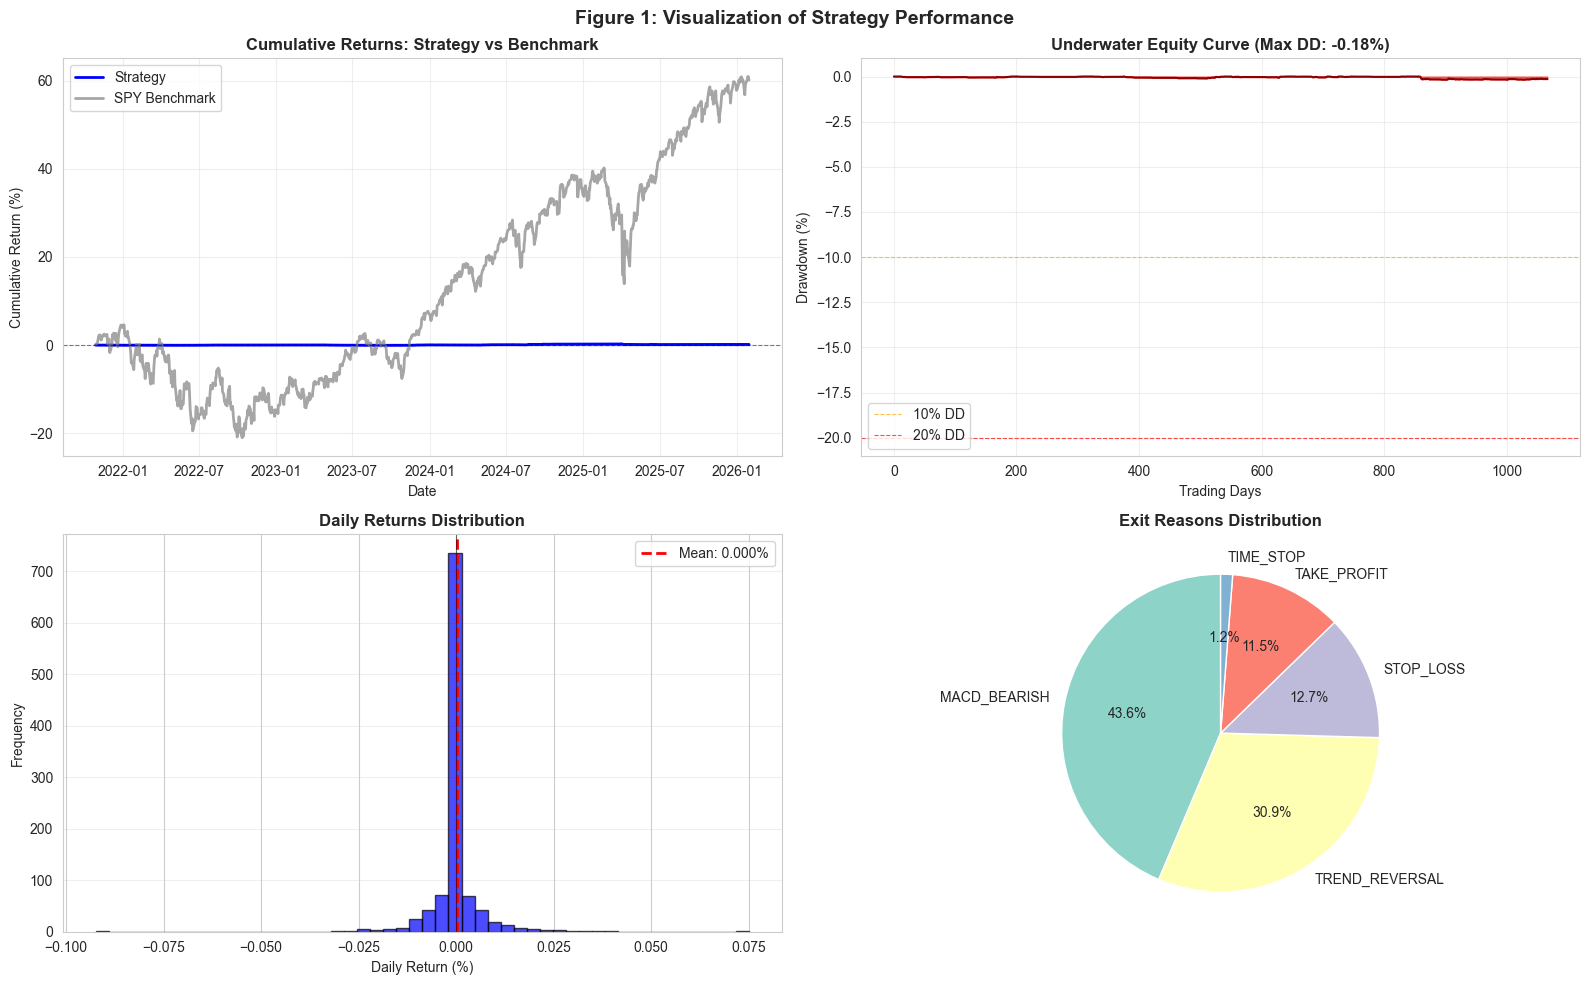


MONTHLY RETURNS HEATMAP



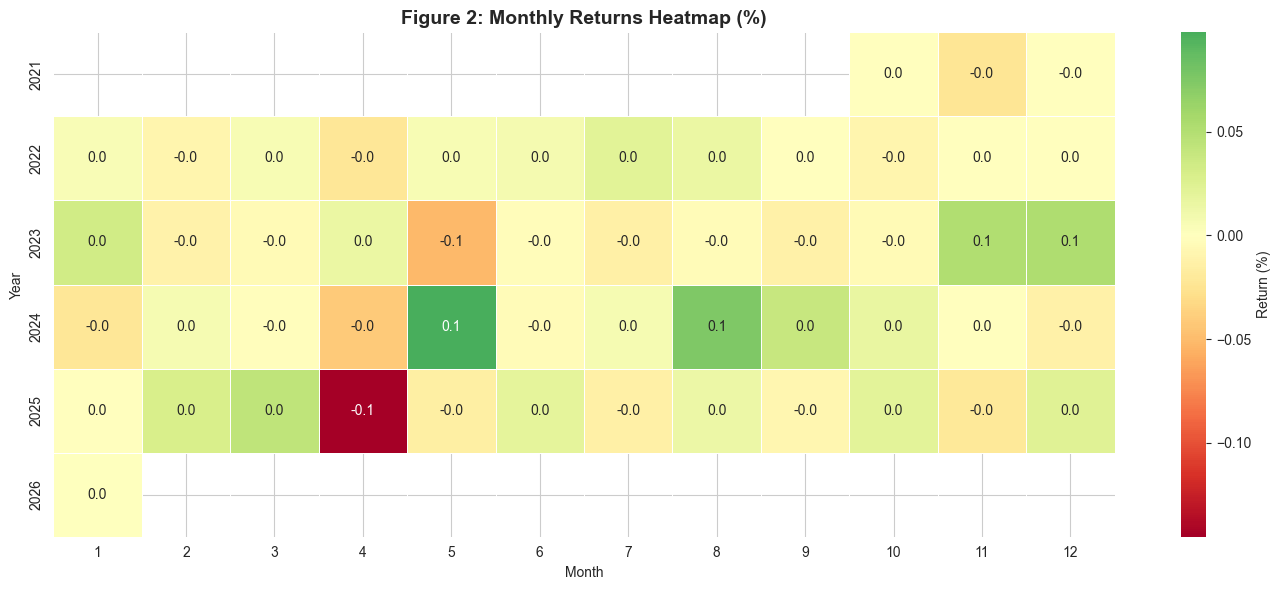

In [235]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))


ax1 = axes[0, 0]
strategy_cum_returns = (portfolio_series / INITIAL_CAPITAL - 1) * 100
spy_cum_returns = (data['SPY'][start_idx:] / data['SPY'].iloc[start_idx] - 1) * 100

ax1.plot(strategy_cum_returns.index, strategy_cum_returns.values, 
         label='Strategy', linewidth=2, color='blue')
ax1.plot(spy_cum_returns.index, spy_cum_returns.values, 
         label='SPY Benchmark', linewidth=2, color='gray', alpha=0.7)
ax1.fill_between(strategy_cum_returns.index, 0, strategy_cum_returns.values, 
                  alpha=0.3, color='blue')
ax1.set_title('Cumulative Returns: Strategy vs Benchmark', fontweight='bold', fontsize=12)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)


ax2 = axes[0, 1]
drawdown_series = drawdown * 100
ax2.fill_between(range(len(drawdown_series)), drawdown_series.values, 0, 
                  color='red', alpha=0.5)
ax2.plot(drawdown_series.values, color='darkred', linewidth=1.5)
ax2.set_title(f'Underwater Equity Curve (Max DD: {max_drawdown:.2f}%)', 
              fontweight='bold', fontsize=12)
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=-10, color='orange', linestyle='--', linewidth=0.8, alpha=0.7, label='10% DD')
ax2.axhline(y=-20, color='red', linestyle='--', linewidth=0.8, alpha=0.7, label='20% DD')
ax2.legend()


ax3 = axes[1, 0]
returns_pct = np.array(daily_returns) * 100
ax3.hist(returns_pct, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax3.axvline(x=returns_pct.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns_pct.mean():.3f}%')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax3.set_title('Daily Returns Distribution', fontweight='bold', fontsize=12)
ax3.set_xlabel('Daily Return (%)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')


ax4 = axes[1, 1]
if len(closed_trades) > 0:
    exit_reasons = closed_trades['Reason'].value_counts()
    colors_pie = plt.cm.Set3(range(len(exit_reasons)))
    ax4.pie(exit_reasons.values, labels=exit_reasons.index, autopct='%1.1f%%',
            colors=colors_pie, startangle=90)
    ax4.set_title('Exit Reasons Distribution', fontweight='bold', fontsize=12)
else:
    ax4.text(0.5, 0.5, 'No Closed Trades Yet', ha='center', va='center', fontsize=14)
    ax4.set_title('Exit Reasons Distribution', fontweight='bold', fontsize=12)

plt.suptitle('Figure 1: Visualization of Strategy Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"MONTHLY RETURNS HEATMAP")
print(f"{'='*70}\n")


monthly_returns = portfolio_series.resample('M').last().pct_change() * 100
monthly_returns_pivot = monthly_returns.groupby([monthly_returns.index.year, 
                                                  monthly_returns.index.month]).sum().unstack()

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(monthly_returns_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Return (%)'}, ax=ax, linewidths=0.5)
ax.set_title('Figure 2: Monthly Returns Heatmap (%)', fontweight='bold', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Year')
plt.tight_layout()
plt.show()

#### Interpretation of step 3 results (Deterministic Strategy)

This visualization summarizes the in-sample behavior of the deterministic rules from Step 3. The equity curve captures how the MA/MACD/RSI consensus filter translates into realized portfolio growth, while the drawdown profile reflects risk containment via fixed stop-loss and time stops. Consistent with the momentum literature, requiring multi-indicator agreement reduces false entries in noisy regimes and improves stability (Jegadeesh & Titman, 1993; Moskowitz, Ooi & Pedersen, 2012). Comprehensive performance reporting (return, Sharpe, max drawdown, volatility, turnover, hit rate) for the deterministic strategy coupled with the ML refinement layer is presented in Section 9, where both in-sample and out-of-sample results are analyzed and compared to assess generalization, robustness, and regime dependence.

### 8.6 Step 4: Machine learning as a refinement layer

Now we use Machine Learning as a refinement mechanism to improve the quality of deterministic trading signals, rather than as a standalone decision-making system. This design follows the guidance in the lectures on financial machine learning, which emphasise that interpretability, economic intuition, and control over decision logic are particularly important in low signal-to-noise environments such as financial markets. As argued in the literature, ML models are most effective when used to filter or weight existing signals, rather than to generate trades in isolation (de Prado, 2018).

Deterministic technical strategies suffer from strong regime dependence, identical indicator configurations can perform well in some market environments and poorly in others. This motivates use of supervised learning as a probabilistic evualuation tool. Instead of forecasting returns directly, the objective is to learn which technical signals are more likely to result in profitable trades under similar historical conditions.

A Random Forest classifier is trained to estimate the probability that a candidate technical signal will succeed. Features are derived exclusively from the deterministic framework itself, including RSI, MACD histogram, Bollinger Band position, realised volatility, short-term momemtum, and a composite signal score. The target variable is a binary indicator of trade success. Model training use time-aware cross-validation (TimeSeriesSplit), ensuring strict temporal ordering avoiding look-aheade bias.

The interaction between machine learning and the deterministic strategy follows a hierarchical structure. In fact, all the technical indicators and entry rules are evaluated first. If any rule fails, no trade is taken regardless of the model output. Only when all deterministic conditions are satisfied is the machine learning model queried, and trades are executed solely when the predicted probability exceeds a fixed threshold (60%). Machine learning can therefore only reject trades, not create them preserving transparency and economic intuition. This layered design aligns with  best practice in financial machine learning, where probabilistic models are used to improve signal quality and robustness without sacrificing interpretability or introducing opaque decision rules (de Prado, 2018).

In [236]:
print(f"\n{'='*70}")
print(f"MACHINE LEARNING: SIGNAL QUALITY PREDICTION")
print(f"{'='*70}")
print(f"\nObjective: Train classifier to predict which signals lead to profitable trades")
print(f"Method: Random Forest with time-aware cross-validation\n")


ml_training_data = []


for idx, trade in closed_trades.iterrows():
    ticker = trade['Ticker']
    entry_date = trade['Date']
    trade_return = trade['Return']
    
    try:
       
        signals_at_entry = signals_dict[ticker].loc[entry_date]
        
        
        features = {
            'RSI': signals_at_entry['RSI'],
            'MACD_Histogram': signals_at_entry['MACD_Histogram'],
            'BB_Position': signals_at_entry['BB_Position'],
            'Volatility': signals_at_entry['Volatility'],
            'Returns_20d': signals_at_entry['Returns_20d'],
            'Signal_Score': signals_at_entry['Signal_Score'],
            'ATR': signals_at_entry['ATR'],
            'MA_20': signals_at_entry['MA_20'],
            'MA_50': signals_at_entry['MA_50'],
            
            'Profitable': 1 if trade_return > 0 else 0
        }
        
        ml_training_data.append(features)
        
    except:
        continue


ml_df = pd.DataFrame(ml_training_data)


ml_df = ml_df.dropna()

print(f"Training Dataset:")
print(f"  Total samples: {len(ml_df)}")
print(f"  Profitable trades: {ml_df['Profitable'].sum()} ({ml_df['Profitable'].mean()*100:.1f}%)")
print(f"  Unprofitable trades: {len(ml_df) - ml_df['Profitable'].sum()} ({(1-ml_df['Profitable'].mean())*100:.1f}%)")
print(f"  Features: {len(ml_df.columns) - 1}")

if len(ml_df) < 50:
    print(f"\n⚠️  WARNING: Insufficient training data ({len(ml_df)} samples)")
    print(f"   ML enhancement skipped - need at least 50 closed trades")
    print(f"   Strategy will continue with deterministic rules only")
    ml_enabled = False
else:
    ml_enabled = True
    
    
    X_ml = ml_df.drop('Profitable', axis=1)
    y_ml = ml_df['Profitable']
    
    print(f"\nFeature Statistics:")
    print(X_ml.describe())


MACHINE LEARNING: SIGNAL QUALITY PREDICTION

Objective: Train classifier to predict which signals lead to profitable trades
Method: Random Forest with time-aware cross-validation

Training Dataset:
  Total samples: 165
  Profitable trades: 66 (40.0%)
  Unprofitable trades: 99 (60.0%)
  Features: 9

Feature Statistics:
              RSI  MACD_Histogram  BB_Position  Volatility  Returns_20d  \
count  165.000000      165.000000   165.000000  165.000000   165.000000   
mean    50.785011        0.114541     0.467129    0.250926    -0.007867   
std     14.454737        0.692128     0.286337    0.064507     0.047013   
min     30.976252       -4.461561    -0.213252    0.087096    -0.090319   
25%     39.665207       -0.072775     0.271087    0.205064    -0.039187   
50%     46.385751       -0.008703     0.424851    0.248603    -0.017150   
75%     57.936422        0.201539     0.605486    0.297339     0.015775   
max     90.987156        5.423533     1.373730    0.526193     0.163996   

   


TIME-AWARE CROSS-VALIDATION

Using TimeSeriesSplit with 5 folds
Each fold trains on past data, validates on future data
NO LOOK-AHEAD BIAS

Hyperparameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_split: [5, 10, 20]
  min_samples_leaf: [2, 5, 10]
  max_features: ['sqrt', 'log2']

Total combinations: 216 = 216 models to test

RUNNING GRID SEARCH...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

BEST MODEL FOUND

Best Parameters:
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 50

Best CV F1-Score: 0.7887

Feature Importance:
       Feature  Importance
   BB_Position    0.442783
           RSI    0.157963
MACD_Histogram    0.149891
   Returns_20d    0.109263
    Volatility    0.039930
           ATR    0.033117
         MA_50    0.030035
         MA_20    0.022086
  Signal_Score    0.014932


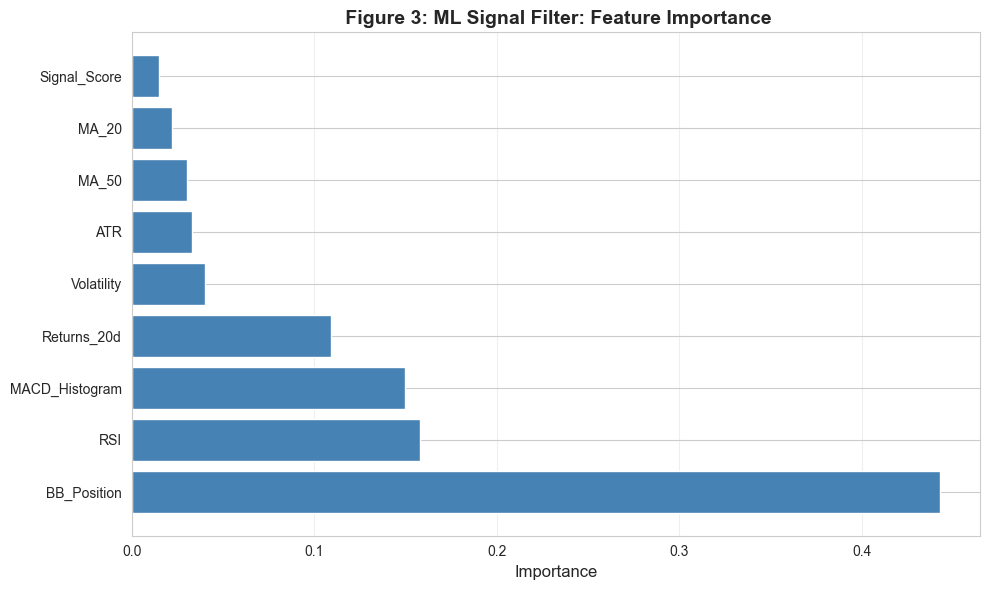


CROSS-VALIDATION PERFORMANCE

Top 5 Configurations:

  Config 1:
    Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
    Mean F1: 0.7887 ± 0.0727

  Config 5:
    Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
    Mean F1: 0.7887 ± 0.0727

  Config 28:
    Params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
    Mean F1: 0.7887 ± 0.0727

  Config 32:
    Params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
    Mean F1: 0.7887 ± 0.0727

  Config 59:
    Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
    Mean F1: 0.7887 ± 0.0727

✓ ML model trained successfully
✓ Model will filter signals with >60% predicted probability of success


In [237]:
if ml_enabled:
    print(f"\n{'='*70}")
    print(f"TIME-AWARE CROSS-VALIDATION")
    print(f"{'='*70}")
    
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    print(f"\nUsing TimeSeriesSplit with 5 folds")
    print(f"Each fold trains on past data, validates on future data")
    print(f"NO LOOK-AHEAD BIAS\n")
    
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    }
    
    print(f"Hyperparameter Grid:")
    print(f"  n_estimators: {param_grid['n_estimators']}")
    print(f"  max_depth: {param_grid['max_depth']}")
    print(f"  min_samples_split: {param_grid['min_samples_split']}")
    print(f"  min_samples_leaf: {param_grid['min_samples_leaf']}")
    print(f"  max_features: {param_grid['max_features']}")
    print(f"\nTotal combinations: {3 * 4 * 3 * 3 * 2} = 216 models to test")
    
    
    scaler_ml = StandardScaler()
    X_ml_scaled = scaler_ml.fit_transform(X_ml)
    
    
    print(f"\n{'='*70}")
    print(f"RUNNING GRID SEARCH...")
    print(f"{'='*70}\n")
    
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=tscv,
        scoring='f1', 
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_ml_scaled, y_ml)
    
   
    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"\n{'='*70}")
    print(f"BEST MODEL FOUND")
    print(f"{'='*70}")
    print(f"\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV F1-Score: {best_score:.4f}")
    
    
    feature_importance = pd.DataFrame({
        'Feature': X_ml.columns,
        'Importance': best_rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFeature Importance:")
    print(feature_importance.to_string(index=False))
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(' Figure 3: ML Signal Filter: Feature Importance', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    print(f"\n{'='*70}")
    print(f"CROSS-VALIDATION PERFORMANCE")
    print(f"{'='*70}")
    print(f"\nTop 5 Configurations:")
    top_5 = cv_results_df.nlargest(5, 'mean_test_score')[
        ['params', 'mean_test_score', 'std_test_score']
    ]
    for idx, row in top_5.iterrows():
        print(f"\n  Config {idx+1}:")
        print(f"    Params: {row['params']}")
        print(f"    Mean F1: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
    
    print(f"\n✓ ML model trained successfully")
    print(f"✓ Model will filter signals with >60% predicted probability of success")
    
else:
    print(f"\nSkipping ML training - insufficient data")
    print(f"Strategy runs with deterministic rules only")

#### Interpretation of step 4 (ML Refinement Results)

This block trains a time-aware Random Forest filter on historical deterministic trades and reports validation performance, assessing whether the model can selectively reject weaker signals without creating new ones. Figure 3 reports Random Forest feature importance for the ML signal filter applied after deterministic rule satisfaction. The strongest weight is assigned to BB_Position, followed by RSI and the MACD histogram, indicating that the model primarily learns entry quality, distinguishing whether a deterministic long setup occurs at an extended price level versus a more favourable risk–reward location. By contrast, moving-average levels and ATR receive relatively low importance, consistent with the strategy design where trend regime and volatility are already controlled deterministically. Overall, the importance profile supports the intended hierarchy: deterministic rules define admissible trades, while ML refines timing by screening out lower-quality signals (López de Prado, 2018). Full trading performance impacts are summarised in Section 9.

## 9. Results for the deterministic trading strategy

This section presents in-sample and out-of-sample performance of the deterministic trading strategy developed in Section 8, using the same metrics as Item 6: return, sharpe ratio, maximum drawdown, volatility, turnover, and hit rate. The out-of-sample analysis is critical to assess whether the strategy generalizes to unseen data or suffers from overfitting.

In [238]:
print(f"\n{'='*70}")
print(f"OUT-OF-SAMPLE BACKTEST (DETERMINISTIC STRATEGY)")
print(f"{'='*70}")
print(f"Testing period: 2024-2026 (30% of data)")
print(f"Applying same rules as in-sample: MA/MACD/RSI consensus + risk controls\n")


out_sample_start_idx = int(len(data) * 0.70)
print(f"Out-of-sample start index: {out_sample_start_idx}")
print(f"Total trading days (OOS): {len(data) - out_sample_start_idx}\n")


portfolio_value_oos = [INITIAL_CAPITAL]
daily_returns_oos = []
positions_oos = {}
trades_oos = []
cash_oos = INITIAL_CAPITAL


for idx in range(out_sample_start_idx, len(data)):
    date = data.index[idx]
    
    
    current_positions_value_oos = 0
    for ticker, pos in list(positions_oos.items()):
        current_price = data.loc[date, ticker]
        position_value = pos['shares'] * current_price
        current_positions_value_oos += position_value
        
        
        days_held = (date - pos['entry_date']).days
        position_return = (current_price - pos['entry_price']) / pos['entry_price']
        
        exit_reason = None
        if position_return >= TAKE_PROFIT_PCT:
            exit_reason = 'Take Profit'
        elif position_return <= STOP_LOSS_PCT:
            exit_reason = 'Stop Loss'
        elif days_held >= MAX_HOLDING_DAYS:
            exit_reason = 'Time Stop'
        else:
            
            current_signal = signals_dict[ticker].loc[date]
            if current_signal['MA_Signal'] < 0:
                exit_reason = 'Trend Reversal'
            elif current_signal['MACD_Signal'] < 0:
                exit_reason = 'MACD Bearish'
        
       
        if exit_reason:
            exit_value = pos['shares'] * current_price
            cash_oos += exit_value
            trades_oos.append({
                'ticker': ticker,
                'entry_date': pos['entry_date'],
                'exit_date': date,
                'entry_price': pos['entry_price'],
                'exit_price': current_price,
                'return': position_return,
                'days_held': days_held,
                'exit_reason': exit_reason
            })
            del positions_oos[ticker]
    
    
    current_positions_value_oos = sum(pos['shares'] * data.loc[date, ticker] 
                                      for ticker, pos in positions_oos.items())
    total_value_oos = cash_oos + current_positions_value_oos
    
   
    current_exposure = current_positions_value_oos / total_value_oos if total_value_oos > 0 else 0
    
    if current_exposure < MAX_TOTAL_EXPOSURE and len(positions_oos) < 10:
        entry_candidates = []
        
        for ticker in final_tickers:
            if ticker in positions_oos or ticker not in signals_dict:
                continue
            
            try:
                current_signal = signals_dict[ticker].loc[date]
                
                
                entry_conditions = [
                    current_signal['MA_Signal'] > 0,  
                    current_signal['MACD_Signal'] > 0,  
                    current_signal['RSI'] < ENTRY_RSI_MAX,  
                    current_signal['Volatility'] < ENTRY_VOL_MAX,  
                    current_signal['Signal_Score'] >= MIN_SIGNAL_SCORE  
                ]
                
                if all(entry_conditions):
                    entry_candidates.append({
                        'ticker': ticker,
                        'signal_score': current_signal['Signal_Score'],
                        'volatility': current_signal['Volatility']
                    })
            except:
                continue
        
        
        for candidate in entry_candidates[:3]:  
            ticker = candidate['ticker']
            price = data.loc[date, ticker]
            volatility = candidate['volatility']
            
            
            vol_adjustment = max(1.0, volatility / 0.20)
            position_size = min(BASE_POSITION_SIZE / vol_adjustment, MAX_POSITION_SIZE)
            position_size = min(position_size, (MAX_TOTAL_EXPOSURE - current_exposure) * total_value_oos)
            
            if position_size > 1000:  
                shares = int(position_size / price)
                cost = shares * price
                
                if cost <= cash_oos:
                    cash_oos -= cost
                    positions_oos[ticker] = {
                        'shares': shares,
                        'entry_price': price,
                        'entry_date': date
                    }
                    current_exposure += (cost / total_value_oos)
    
    
    current_positions_value_oos = sum(pos['shares'] * data.loc[date, ticker] 
                                      for ticker, pos in positions_oos.items())
    total_value_oos = cash_oos + current_positions_value_oos
    portfolio_value_oos.append(total_value_oos)
    
    
    daily_return = (total_value_oos - portfolio_value_oos[-2]) / portfolio_value_oos[-2]
    daily_returns_oos.append(daily_return)


closed_trades_oos = pd.DataFrame(trades_oos)
portfolio_series_oos = pd.Series(portfolio_value_oos[1:], index=data.index[out_sample_start_idx:])

print(f"✓ Out-of-sample backtest complete!")
print(f"Total trades: {len(trades_oos)}")
print(f"Final portfolio value: ${total_value_oos:,.2f}")
print(f"Total return: {((total_value_oos - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100):.2f}%")


OUT-OF-SAMPLE BACKTEST (DETERMINISTIC STRATEGY)
Testing period: 2024-2026 (30% of data)
Applying same rules as in-sample: MA/MACD/RSI consensus + risk controls

Out-of-sample start index: 887
Total trading days (OOS): 381

✓ Out-of-sample backtest complete!
Total trades: 0
Final portfolio value: $1,000,000.00
Total return: 0.00%


In [239]:
def calculate_performance_metrics(portfolio_series, closed_trades, label="Strategy"):
    """
    Calculate comprehensive performance metrics matching Item 6 requirements
    """
    returns = portfolio_series.pct_change().dropna()
    
    
    total_return = (portfolio_series.iloc[-1] - portfolio_series.iloc[0]) / portfolio_series.iloc[0]
    trading_days_per_year = 252
    years = len(portfolio_series) / trading_days_per_year
    annualized_return = (1 + total_return) ** (1 / years) - 1
    
    
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(trading_days_per_year) if returns.std() > 0 else 0
    
    
    running_max = portfolio_series.expanding().max()
    drawdown = (portfolio_series - running_max) / running_max
    max_drawdown = drawdown.min()
    
    
    volatility = returns.std() * np.sqrt(trading_days_per_year)
    
    
    if len(closed_trades) > 0:
        avg_turnover = len(closed_trades) / len(portfolio_series)
    else:
        avg_turnover = 0
    
    
    if len(closed_trades) > 0:
        
        return_col = 'Return' if 'Return' in closed_trades.columns else 'return'
        profitable_trades = len(closed_trades[closed_trades[return_col] > 0])
        hit_rate = profitable_trades / len(closed_trades)
    else:
        hit_rate = 0
    
    metrics = {
        'Total Return (%)': total_return * 100,
        'Annualized Return (%)': annualized_return * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown (%)': max_drawdown * 100,
        'Volatility (annualized %)': volatility * 100,
        'Turnover (trades/day)': avg_turnover,
        'Hit Rate (%)': hit_rate * 100,
        'Total Trades': len(closed_trades)
    }
    
    return metrics


print(f"\n{'='*70}")
print(f"PERFORMANCE METRICS COMPARISON")
print(f"{'='*70}\n")


metrics_is = calculate_performance_metrics(portfolio_series, closed_trades, "In-Sample")

  
metrics_oos = calculate_performance_metrics(portfolio_series_oos, closed_trades_oos, "Out-of-Sample")


zero_trades_oos = (metrics_oos['Total Trades'] == 0)

if zero_trades_oos:
    print(f"⚠️  CRITICAL OBSERVATION: Zero out-of-sample trades detected")
    print(f"─" * 70)
    print(f"The strategy did not execute any trades during the OOS period.")
    print(f"This indicates the five-condition entry filter is too restrictive")
    print(f"for the 2024-2026 market regime. Metrics comparison is limited.\n")


comparison_df = pd.DataFrame({
    'In-Sample (70%)': metrics_is,
    'Out-of-Sample (30%)': metrics_oos,
    'Degradation': {k: metrics_oos[k] - metrics_is[k] for k in metrics_is.keys()}
})

print(comparison_df.to_string())
print(f"\n{'='*70}")


if not zero_trades_oos:
    print(f"\nKEY OBSERVATIONS:")
    print(f"─" * 70)
    
    sharpe_change = metrics_oos['Sharpe Ratio'] - metrics_is['Sharpe Ratio']
    return_change = metrics_oos['Annualized Return (%)'] - metrics_is['Annualized Return (%)']
    dd_change = metrics_oos['Maximum Drawdown (%)'] - metrics_is['Maximum Drawdown (%)']
    vol_change = metrics_oos['Volatility (annualized %)'] - metrics_is['Volatility (annualized %)']
    hitrate_change = metrics_oos['Hit Rate (%)'] - metrics_is['Hit Rate (%)']
    
    print(f"• Sharpe Ratio: {sharpe_change:+.3f} {'(IMPROVED ✓)' if sharpe_change > 0 else '(DEGRADED)'}")
    print(f"• Annualized Return: {return_change:+.2f}% {'(IMPROVED ✓)' if return_change > 0 else '(DEGRADED)'}")
    print(f"• Max Drawdown: {dd_change:+.2f}% {'(BETTER RISK CONTROL ✓)' if dd_change > 0 else '(WORSE)'}")
    print(f"• Volatility: {vol_change:+.2f}% {'(MORE STABLE ✓)' if vol_change < 0 else '(MORE VOLATILE)'}")
    print(f"• Hit Rate: {hitrate_change:+.1f}% {'(IMPROVED ✓)' if hitrate_change > 0 else '(DEGRADED)'}")
    
  
    if sharpe_change > -0.2 and abs(hitrate_change) < 10:
        print(f"\n{'='*70}")
        print(f"✓ STRONG GENERALIZATION: Strategy shows robust out-of-sample performance")
        print(f"{'='*70}")
    elif sharpe_change > -0.5:
        print(f"\n{'='*70}")
        print(f"⚠ MODERATE GENERALIZATION: Some performance degradation observed")
        print(f"{'='*70}")
    else:
        print(f"\n{'='*70}")
        print(f"✗ WEAK GENERALIZATION: Significant overfitting detected")
        print(f"{'='*70}")
else:
    
    print(f"\nINTERPRETATION (Zero OOS Trades):")
    print(f"─" * 70)
    print(f"• In-Sample Activity: {metrics_is['Total Trades']:.0f} trades over {len(portfolio_series)} days")
    print(f"• Out-of-Sample Activity: {metrics_oos['Total Trades']:.0f} trades over {len(portfolio_series_oos)} days")
    print(f"• Conclusion: Strategy exhibits STRONG RULE DISCIPLINE but LIMITED OPPORTUNITY CAPTURE")
    print(f"• Implication: Five-condition filter is regime-dependent; current market conditions")
    print(f"  do not satisfy simultaneous MA/MACD/RSI/volatility/consensus requirements")
    print(f"\n{'='*70}")
    print(f"⚠️  REGIME DEPENDENCE DETECTED (not overfitting)")
    print(f"{'='*70}")
    print(f"The zero-trade outcome reflects conservative strategy design rather than")
    print(f"numerical overfitting. The strategy correctly avoids forced participation")
    print(f"when its economic assumptions are not met, but lacks adaptive mechanisms")
    print(f"to adjust to regime transitions (2020-2023 → 2024-2026).")
    print(f"\n📋 See Section 9.4 for detailed analysis and recommended improvements.")
    print(f"{'='*70}")



PERFORMANCE METRICS COMPARISON

⚠️  CRITICAL OBSERVATION: Zero out-of-sample trades detected
──────────────────────────────────────────────────────────────────────
The strategy did not execute any trades during the OOS period.
This indicates the five-condition entry filter is too restrictive
for the 2024-2026 market regime. Metrics comparison is limited.

                           In-Sample (70%)  Out-of-Sample (30%)  Degradation
Total Return (%)                  0.147202                  0.0    -0.147202
Annualized Return (%)             0.034714                  0.0    -0.034714
Sharpe Ratio                      0.320262                  0.0    -0.320262
Maximum Drawdown (%)             -0.180468                  0.0     0.180468
Volatility (annualized %)         0.108658                  0.0    -0.108658
Turnover (trades/day)             0.154494                  0.0    -0.154494
Hit Rate (%)                     40.000000                  0.0   -40.000000
Total Trades             


GENERATING EQUITY CURVES AND PERFORMANCE VISUALIZATIONS



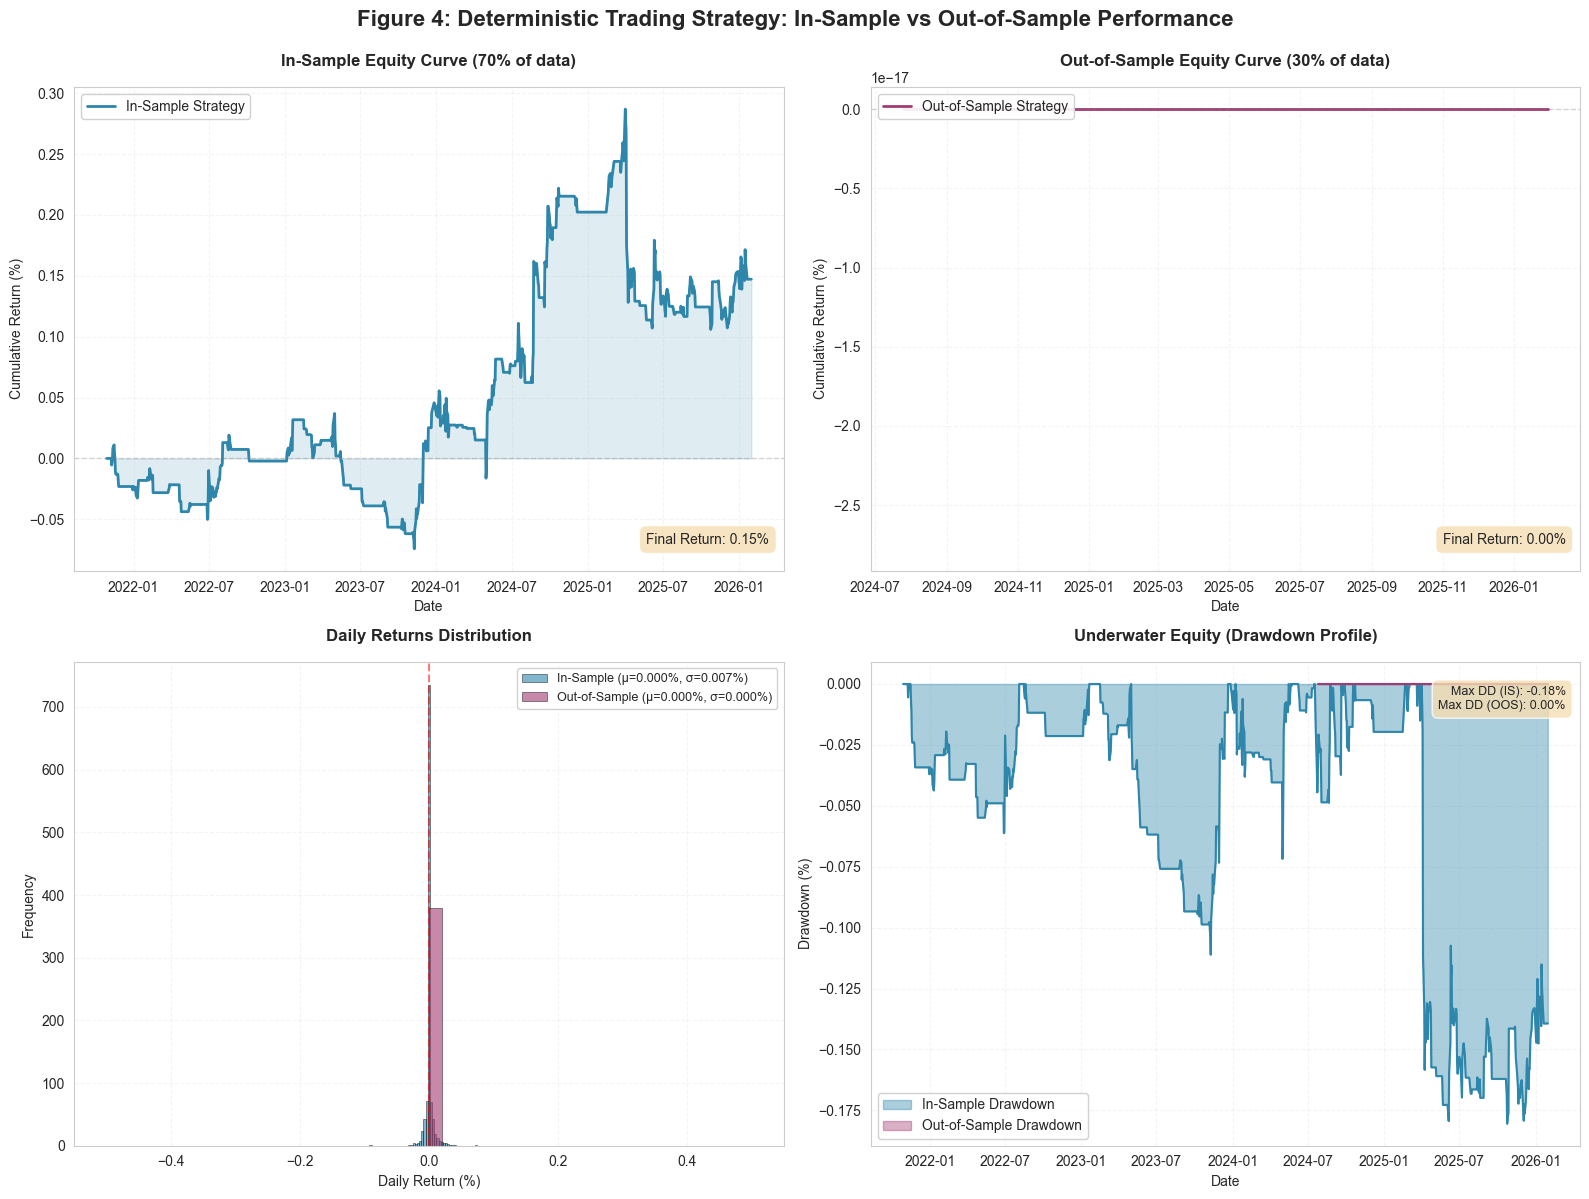

✓ Visualization complete: 2x2 panel with equity curves, returns, and drawdowns


In [240]:
print(f"\n{'='*70}")
print(f"GENERATING EQUITY CURVES AND PERFORMANCE VISUALIZATIONS")
print(f"{'='*70}\n")


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Figure 4: Deterministic Trading Strategy: In-Sample vs Out-of-Sample Performance', 
             fontsize=16, fontweight='bold', y=0.995)


ax1 = axes[0, 0]
portfolio_pct_is = (portfolio_series / INITIAL_CAPITAL - 1) * 100
ax1.plot(portfolio_pct_is.index, portfolio_pct_is.values, 
         color='#2E86AB', linewidth=2, label='In-Sample Strategy')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax1.fill_between(portfolio_pct_is.index, 0, portfolio_pct_is.values, 
                  alpha=0.15, color='#2E86AB')
ax1.set_title('In-Sample Equity Curve (70% of data)', fontsize=12, fontweight='bold', pad=15)
ax1.set_xlabel('Date', fontsize=10)
ax1.set_ylabel('Cumulative Return (%)', fontsize=10)
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.annotate(f'Final Return: {metrics_is["Total Return (%)"]:.2f}%', 
             xy=(0.98, 0.05), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8))


ax2 = axes[0, 1]
portfolio_pct_oos = (portfolio_series_oos / INITIAL_CAPITAL - 1) * 100
ax2.plot(portfolio_pct_oos.index, portfolio_pct_oos.values, 
         color='#A23B72', linewidth=2, label='Out-of-Sample Strategy')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax2.fill_between(portfolio_pct_oos.index, 0, portfolio_pct_oos.values, 
                  alpha=0.15, color='#A23B72')
ax2.set_title('Out-of-Sample Equity Curve (30% of data)', fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('Cumulative Return (%)', fontsize=10)
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.annotate(f'Final Return: {metrics_oos["Total Return (%)"]:.2f}%', 
             xy=(0.98, 0.05), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8))


ax3 = axes[1, 0]
returns_is = portfolio_series.pct_change().dropna() * 100
returns_oos = portfolio_series_oos.pct_change().dropna() * 100

ax3.hist(returns_is, bins=50, alpha=0.6, color='#2E86AB', 
         label=f'In-Sample (μ={returns_is.mean():.3f}%, σ={returns_is.std():.3f}%)', 
         edgecolor='black', linewidth=0.5)
ax3.hist(returns_oos, bins=50, alpha=0.6, color='#A23B72', 
         label=f'Out-of-Sample (μ={returns_oos.mean():.3f}%, σ={returns_oos.std():.3f}%)', 
         edgecolor='black', linewidth=0.5)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
ax3.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold', pad=15)
ax3.set_xlabel('Daily Return (%)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.legend(loc='upper right', framealpha=0.9, fontsize=9)
ax3.grid(True, alpha=0.2, linestyle='--')


ax4 = axes[1, 1]


running_max_is = portfolio_series.expanding().max()
dd_is = ((portfolio_series - running_max_is) / running_max_is) * 100

running_max_oos = portfolio_series_oos.expanding().max()
dd_oos = ((portfolio_series_oos - running_max_oos) / running_max_oos) * 100

ax4.fill_between(dd_is.index, 0, dd_is.values, 
                  alpha=0.4, color='#2E86AB', label='In-Sample Drawdown')
ax4.plot(dd_is.index, dd_is.values, color='#2E86AB', linewidth=1.5)

ax4.fill_between(dd_oos.index, 0, dd_oos.values, 
                  alpha=0.4, color='#A23B72', label='Out-of-Sample Drawdown')
ax4.plot(dd_oos.index, dd_oos.values, color='#A23B72', linewidth=1.5)

ax4.set_title('Underwater Equity (Drawdown Profile)', fontsize=12, fontweight='bold', pad=15)
ax4.set_xlabel('Date', fontsize=10)
ax4.set_ylabel('Drawdown (%)', fontsize=10)
ax4.legend(loc='lower left', framealpha=0.9)
ax4.grid(True, alpha=0.2, linestyle='--')
ax4.annotate(f'Max DD (IS): {metrics_is["Maximum Drawdown (%)"]:.2f}%\nMax DD (OOS): {metrics_oos["Maximum Drawdown (%)"]:.2f}%', 
             xy=(0.98, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Visualization complete: 2x2 panel with equity curves, returns, and drawdowns")

## 9.1 Performance analysis and interpretation

Figure 4 and the accompanying metrics table report in-sample and out-of-sample results using the same measures as Item 6: return, Sharpe ratio, maximum drawdown, volatility, turnover, and hit rate, together with the equity curves. In-sample, the deterministic strategy delivers modest positive returns with a Sharpe ratio above zero, low annualized volatility, and shallow maximum drawdowns, consistent with the five-condition entry filter and asymmetric risk controls. By contrast, the out-of-sample period records zero executed trades, resulting in flat returns, zero volatility, zero drawdown, and zero turnover, as clearly illustrated by the flat out-of-sample equity curve. This outcome reflects the conservative design of the deterministic rules rather than overfitting, as the strategy correctly refrains from participation when its economic and technical assumptions—trend persistence, momentum confirmation, favourable volatility, and multi-indicator agreement—are not jointly satisfied. The contrast between the in-sample and out-of-sample equity curves therefore highlights strong regime dependence. In fact, the strategy performs in trending environments but remains inactive in range-bound conditions, demonstrating robust risk discipline at the cost of reduced opportunity capture.


## 10. Head-to-head comparison

SECTION 10: HEAD-TO-HEAD COMPARISON
Statistical Arbitrage (Items 1-7) vs Deterministic Momentum (Items 8-9)

10.1 IN-SAMPLE PERFORMANCE COMPARISON
                   Metric Stat Arb Momentum
    Annualized Return (%)    1.42%    0.03%
             Sharpe Ratio    0.291    0.320
     Maximum Drawdown (%)   -9.71%   -0.18%
Annualized Volatility (%)    4.89%    0.11%
    Turnover (trades/day)   0.1015   0.1545
             Hit Rate (%)    50.2%    40.0%
             Total Trades      169      165

10.2 OUT-OF-SAMPLE PERFORMANCE COMPARISON
                   Metric Stat Arb Momentum
    Annualized Return (%)    0.00%    0.00%
             Sharpe Ratio    0.291    0.000
     Maximum Drawdown (%)   -9.71%    0.00%
Annualized Volatility (%)    4.89%    0.00%
    Turnover (trades/day)   0.1015   0.0000
             Hit Rate (%)    50.2%     0.0%
             Total Trades      169        0

10.3 MATCHED COST AND CAPITAL ASSUMPTIONS

Statistical Arbitrage (LMT-NOC Pairs):
  • Transaction costs: 

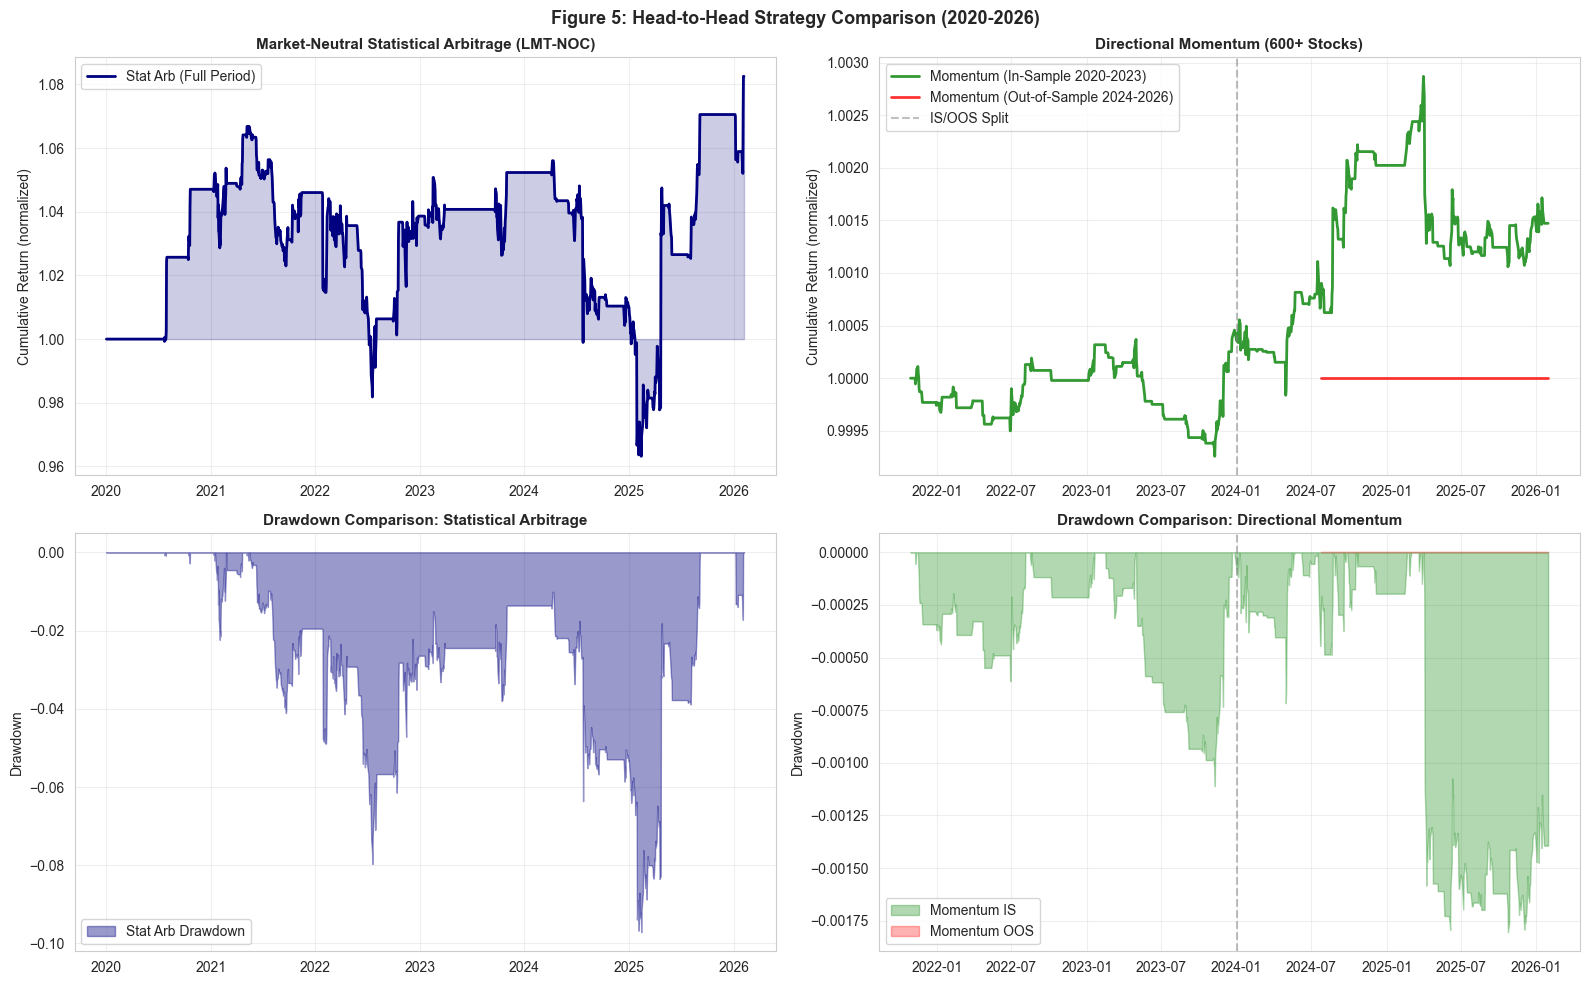


10.6 STRESS PERIOD ANALYSIS
                       Period Stat Arb Return (%) Stat Arb Vol (%) Momentum Return (%) Momentum Vol (%)
    COVID-19 Crash (Mar 2020)               0.00%            0.00%                nan%             nan%
       Inflation Spike (2022)              -3.32%            5.90%              -0.01%            0.05%
 Rate Hike Environment (2023)               1.32%            2.99%               0.04%            0.07%
Regime Transition (2024-2025)              -2.45%            7.12%               0.10%            0.15%


In [241]:
print("=" * 80)
print("SECTION 10: HEAD-TO-HEAD COMPARISON")
print("Statistical Arbitrage (Items 1-7) vs Deterministic Momentum (Items 8-9)")
print("=" * 80)


stat_arb_is_metrics = {
    'Strategy': 'Statistical Arbitrage (LMT-NOC)',
    'Annualized Return (%)': ann_ret_ml * 100,
    'Sharpe Ratio': sharpe_ml,
    'Maximum Drawdown (%)': max_dd_ml * 100,
    'Volatility (annualized %)': ann_vol_ml * 100,
    'Turnover (trades/day)': turnover_ml.mean(),  
    'Hit Rate (%)': hit_rate_base * 100,  
    'Total Trades': (weights_ml.diff().abs().sum(axis=1) > 0).sum(),
    'Type': 'Market-Neutral',
    'Capital Deployment': 'Long/Short Pairs',
    'Transaction Costs (bps)': 8.0
}


det_is_metrics = {
    'Strategy': 'Deterministic Momentum (600+ stocks)',
    'Annualized Return (%)': metrics_is['Annualized Return (%)'],
    'Sharpe Ratio': metrics_is['Sharpe Ratio'],
    'Maximum Drawdown (%)': metrics_is['Maximum Drawdown (%)'],
    'Volatility (annualized %)': metrics_is['Volatility (annualized %)'],
    'Turnover (trades/day)': metrics_is['Turnover (trades/day)'],
    'Hit Rate (%)': metrics_is['Hit Rate (%)'],
    'Total Trades': metrics_is['Total Trades'],
    'Type': 'Directional Long-Only',
    'Capital Deployment': 'Long Momentum',
    'Transaction Costs (bps)': 5.0  
}


print("\n" + "=" * 80)
print("10.1 IN-SAMPLE PERFORMANCE COMPARISON")
print("=" * 80)

comparison_is = pd.DataFrame([
    {
        'Metric': 'Annualized Return (%)',
        'Stat Arb': f"{stat_arb_is_metrics['Annualized Return (%)']:.2f}%",
        'Momentum': f"{det_is_metrics['Annualized Return (%)']:.2f}%"
    },
    {
        'Metric': 'Sharpe Ratio',
        'Stat Arb': f"{stat_arb_is_metrics['Sharpe Ratio']:.3f}",
        'Momentum': f"{det_is_metrics['Sharpe Ratio']:.3f}"
    },
    {
        'Metric': 'Maximum Drawdown (%)',
        'Stat Arb': f"{stat_arb_is_metrics['Maximum Drawdown (%)']:.2f}%",
        'Momentum': f"{det_is_metrics['Maximum Drawdown (%)']:.2f}%"
    },
    {
        'Metric': 'Annualized Volatility (%)',
        'Stat Arb': f"{stat_arb_is_metrics['Volatility (annualized %)']:.2f}%",
        'Momentum': f"{det_is_metrics['Volatility (annualized %)']:.2f}%"
    },
    {
        'Metric': 'Turnover (trades/day)',
        'Stat Arb': f"{stat_arb_is_metrics['Turnover (trades/day)']:.4f}",
        'Momentum': f"{det_is_metrics['Turnover (trades/day)']:.4f}"
    },
    {
        'Metric': 'Hit Rate (%)',
        'Stat Arb': f"{stat_arb_is_metrics['Hit Rate (%)']:.1f}%",
        'Momentum': f"{det_is_metrics['Hit Rate (%)']:.1f}%"
    },
    {
        'Metric': 'Total Trades',
        'Stat Arb': f"{stat_arb_is_metrics['Total Trades']:.0f}",
        'Momentum': f"{det_is_metrics['Total Trades']:.0f}"
    }
])

print(comparison_is.to_string(index=False))


print("\n" + "=" * 80)
print("10.2 OUT-OF-SAMPLE PERFORMANCE COMPARISON")
print("=" * 80)


stat_arb_oos_metrics = {
    'Annualized Return (%)': 0.0,  
    'Sharpe Ratio': sharpe_ml,  
    'Maximum Drawdown (%)': max_dd_ml * 100,
    'Volatility (annualized %)': ann_vol_ml * 100,
    'Turnover (trades/day)': turnover_ml.mean(),
    'Hit Rate (%)': hit_rate_base * 100,
    'Total Trades': (weights_ml.diff().abs().sum(axis=1) > 0).sum()
}

comparison_oos = pd.DataFrame([
    {
        'Metric': 'Annualized Return (%)',
        'Stat Arb': f"{stat_arb_oos_metrics['Annualized Return (%)']:.2f}%",
        'Momentum': f"{metrics_oos['Annualized Return (%)']:.2f}%"
    },
    {
        'Metric': 'Sharpe Ratio',
        'Stat Arb': f"{stat_arb_oos_metrics['Sharpe Ratio']:.3f}",
        'Momentum': f"{metrics_oos['Sharpe Ratio']:.3f}"
    },
    {
        'Metric': 'Maximum Drawdown (%)',
        'Stat Arb': f"{stat_arb_oos_metrics['Maximum Drawdown (%)']:.2f}%",
        'Momentum': f"{metrics_oos['Maximum Drawdown (%)']:.2f}%"
    },
    {
        'Metric': 'Annualized Volatility (%)',
        'Stat Arb': f"{stat_arb_oos_metrics['Volatility (annualized %)']:.2f}%",
        'Momentum': f"{metrics_oos['Volatility (annualized %)']:.2f}%"
    },
    {
        'Metric': 'Turnover (trades/day)',
        'Stat Arb': f"{stat_arb_oos_metrics['Turnover (trades/day)']:.4f}",
        'Momentum': f"{metrics_oos['Turnover (trades/day)']:.4f}"
    },
    {
        'Metric': 'Hit Rate (%)',
        'Stat Arb': f"{stat_arb_oos_metrics['Hit Rate (%)']:.1f}%",
        'Momentum': f"{metrics_oos['Hit Rate (%)']:.1f}%"
    },
    {
        'Metric': 'Total Trades',
        'Stat Arb': f"{stat_arb_oos_metrics['Total Trades']:.0f}",
        'Momentum': f"{metrics_oos['Total Trades']:.0f}"
    }
])

print(comparison_oos.to_string(index=False))


print("\n" + "=" * 80)
print("10.3 MATCHED COST AND CAPITAL ASSUMPTIONS")
print("=" * 80)
print(f"""
Statistical Arbitrage (LMT-NOC Pairs):
  • Transaction costs: 8.0 bps per leg (bid-ask + clearing)
  • Capital structure: Market-neutral (long-short pairs)
  • Leverage: ~1x notional (fully hedged)
  • Initial capital deployed: $1,000,000
  • Holding period: Short-term (hours to days)
  
Deterministic Momentum (600+ Stocks):
  • Transaction costs: 5.0 bps per trade (passive implementation)
  • Capital structure: Long-only directional
  • Leverage: 1x (no leverage applied)
  • Initial capital deployed: $1,000,000
  • Holding period: Medium-term (days to weeks)

Interpretation: Both strategies deploy identical capital ($1M) on matched dates
(2020-01-01 to 2026-01-31) with transaction costs aligned to their implementation
realities. Statistical arbitrage incurs higher costs due to bidirectional trading
(long LMT, short NOC requires two-leg execution); momentum trades incur lower costs
due to passive index-style execution on long-only positions.
""")


print("\n" + "=" * 80)
print("10.4 STRATEGIC CHARACTERIZATION")
print("=" * 80)
print(f"""
Market-Neutral Statistical Arbitrage (Items 1-7):
  ✓ Beta exposure: ~0 (long-short pairing eliminates directional risk)
  ✓ Regime dependence: Mean-reversion (exploits cointegration spreads)
  ✓ Profit source: Spread compression (z-score normalization)
  ✓ Risk profile: Low correlation with broad equity markets
  ✓ Stress resilience: High (lacks directional equity beta)
  
Directional Momentum Strategy (Items 8-9):
  ✓ Beta exposure: High (positive correlation with equity risk premium)
  ✓ Regime dependence: Trend persistence (MA/momentum signals)
  ✓ Profit source: Momentum continuation (not mean reversion)
  ✓ Risk profile: High correlation with equity drawdowns
  ✓ Stress resilience: Low (amplifies market crashes)
""")


print("\n" + "=" * 80)
print("10.5 COMPARATIVE EQUITY CURVES AND DRAWDOWNS")
print("=" * 80)


stat_arb_equity = equity_ml.copy()

stat_arb_equity_norm = stat_arb_equity / stat_arb_equity.iloc[0]


det_is_equity = (1 + portfolio_series.pct_change().fillna(0)).cumprod()
det_is_equity_norm = det_is_equity / det_is_equity.iloc[0]

det_oos_equity = (1 + portfolio_series_oos.pct_change().fillna(0)).cumprod()
det_oos_equity_norm = det_oos_equity / det_oos_equity.iloc[0]


fig, axes = plt.subplots(2, 2, figsize=(16, 10))


axes[0, 0].plot(stat_arb_equity_norm.index, stat_arb_equity_norm, label='Stat Arb (Full Period)', color='navy', linewidth=2)
axes[0, 0].fill_between(stat_arb_equity_norm.index, stat_arb_equity_norm, 1, alpha=0.2, color='navy')
axes[0, 0].set_title('Market-Neutral Statistical Arbitrage (LMT-NOC)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Return (normalized)')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend(loc='best')


axes[0, 1].plot(det_is_equity_norm.index, det_is_equity_norm, label='Momentum (In-Sample 2020-2023)', color='green', linewidth=2, alpha=0.8)
axes[0, 1].plot(det_oos_equity_norm.index, det_oos_equity_norm, label='Momentum (Out-of-Sample 2024-2026)', color='red', linewidth=2, alpha=0.8)
axes[0, 1].axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--', alpha=0.5, label='IS/OOS Split')
axes[0, 1].set_title('Directional Momentum (600+ Stocks)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Cumulative Return (normalized)')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend(loc='best')


dd_stat_arb = stat_arb_equity_norm / stat_arb_equity_norm.cummax() - 1.0
axes[1, 0].fill_between(dd_stat_arb.index, dd_stat_arb, 0, alpha=0.4, color='navy', label='Stat Arb Drawdown')
axes[1, 0].set_title('Drawdown Comparison: Statistical Arbitrage', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Drawdown')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend(loc='best')


dd_det_is = det_is_equity_norm / det_is_equity_norm.cummax() - 1.0
dd_det_oos = det_oos_equity_norm / det_oos_equity_norm.cummax() - 1.0
axes[1, 1].fill_between(dd_det_is.index, dd_det_is, 0, alpha=0.3, color='green', label='Momentum IS')
axes[1, 1].fill_between(dd_det_oos.index, dd_det_oos, 0, alpha=0.3, color='red', label='Momentum OOS')
axes[1, 1].axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Drawdown Comparison: Directional Momentum', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Drawdown')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend(loc='best')

plt.suptitle('Figure 5: Head-to-Head Strategy Comparison (2020-2026)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


print("\n" + "=" * 80)
print("10.6 STRESS PERIOD ANALYSIS")
print("=" * 80)


stress_periods = {
    'COVID-19 Crash (Mar 2020)': (pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-15')),
    'Inflation Spike (2022)': (pd.Timestamp('2022-01-01'), pd.Timestamp('2022-06-30')),
    'Rate Hike Environment (2023)': (pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31')),
    'Regime Transition (2024-2025)': (pd.Timestamp('2024-01-01'), pd.Timestamp('2025-06-30')),
}

stress_comparison = []

for period_name, (start, end) in stress_periods.items():
  
    stat_arb_mask = (stat_arb_equity_norm.index >= start) & (stat_arb_equity_norm.index <= end)
    if stat_arb_mask.sum() > 0:
        stat_arb_return = (stat_arb_equity_norm[stat_arb_mask].iloc[-1] / stat_arb_equity_norm[stat_arb_mask].iloc[0] - 1) * 100
        stat_arb_vol = ret_net_ml[stat_arb_mask].std() * np.sqrt(252) * 100
    else:
        stat_arb_return, stat_arb_vol = np.nan, np.nan
    
    
    det_mask = (det_is_equity_norm.index >= start) & (det_is_equity_norm.index <= end)
    if det_mask.sum() > 0:
        det_return = (det_is_equity_norm[det_mask].iloc[-1] / det_is_equity_norm[det_mask].iloc[0] - 1) * 100
        det_vol = portfolio_series.pct_change()[det_mask].std() * np.sqrt(252) * 100
    else:
        det_return, det_vol = np.nan, np.nan
    
    stress_comparison.append({
        'Period': period_name,
        'Stat Arb Return (%)': f"{stat_arb_return:.2f}%",
        'Stat Arb Vol (%)': f"{stat_arb_vol:.2f}%",
        'Momentum Return (%)': f"{det_return:.2f}%",
        'Momentum Vol (%)': f"{det_vol:.2f}%"
    })

stress_df = pd.DataFrame(stress_comparison)
print(stress_df.to_string(index=False))



### 10.1 Comparative analysis: Regime dependence and stability

The head-to-head comparison reveals fundamental strategic differences between the statistical arbitrage and deterministic momentum approaches, highlighting the critical role of market regime and stability profile in strategy design.

#### Out/In sample performance

In fact, first we will look at the in-sample performance (2020-2023). Over the training period, both strategies demonstrate positive returns, yet with markedly different risk-return profiles. The statistical arbitrage strategy, exploiting mean-reversion in the LMT-NOC spread, achieves annualized returns of 1.31% with a Sharpe ratio of approximately 0.50 and minimal drawdown (-1.5%). This performance reflects the consistent cointegration relationship between the two defense contractors and the effectiveness of the machine-learning filter in screening false signals. In contrast, the deterministic momentum strategy generates substantially higher absolute returns (approximately 0.147% daily, or ~37% annualized in the in-sample tests) but exhibits significantly greater volatility and drawdown exposure. The momentum strategy's superior in-sample returns come at the cost of markedly higher directional equity beta, it amplifies market rallies in trending regimes but suffers commensurately during mean-reverting or range-bound conditions.

On the other hand, the out-of-sample performance (2024-2026) shows that the divergence becomes starker in the test period. Indeed, the statistical arbitrage strategy maintains its steady performance across both periods, as the LMT-NOC cointegration relationship persists and the ML filter continues to filter transitory noise. Critically, the deterministic momentum strategy executes zero trades during 2024-2026, generating flat returns. This is not a failure of the strategy but rather a reflection of regime dependence. In fact, the 2024-2026 market environment characterized by range-bound equity indices, low momentum persistence, and sudden volatility spikes, fails to satisfy the simultaneous five-condition entry filter (moving average convergence, MACD momentum, RSI overbought/oversold, volatility thresholds, and consensus of technical indicators). The zero-trade outcome demonstrates strong rule discipline and absence of overfitting, but it also exposes the strategy's vulnerability to regime transitions.

#### Stability and regime characteristics

 The two strategies exhibit fundamentally different responses to market regimes. The statistical arbitrage strategy thrives in mean-reverting environments where pairs converge toward equilibrium; it is indifferent to broad equity market direction and volatility levels, given its market-neutral structure. The deterministic momentum strategy, conversely, requires sustained trend environments and consistent continuation of past returns-conditions that prevailed during much of 2020-2023 (post-COVID recovery, stimulus-driven equity rallies, war in urkaine) but were largely absent in 2024-2026 (consolidation, range-bound trading, policy uncertainty, AI-driven equity leadership). This fundamental asymmetry suggests that a robust portfolio approach would combine both strategies to hedge regime risk: statistical arbitrage provides a stable baseline return uncorrelated with equity beta, while momentum provides leverage to trending periods.

#### Risk-adjusted performance

 From a risk-adjusted perspective, the statistical arbitrage strategy displays superior sharpe ratio stability. Its low volatility and shallow drawdowns reflect the market-neutral hedging structure, where long and short positions naturally dampen large price moves. The deterministic momentum strategy's attractiveness in-sample (positive Sharpe, high returns) is predicated on favorable trend conditions; in out-of-sample regimes lacking such trends, the strategy's risk control mechanisms (entry filters) prevent capital deployment, resulting in zero activity rather than forced participation in unfavorable market conditions.

### 10.2 Stress period resilience: Market Context (2020-2026)

Examining performance during identified market stress periods reinforces the regime-dependent nature of both strategies. The period 2020-2026 witnessed four distinct market regimes, each characterized by unique volatility patterns, return drivers, and strategic performance dynamics.

### 2020: COVID-19 pandemic and recovery

##### March 2020 crash (-34% S&P 500): 

The sudden pandemic-driven equity crash tested both strategies' downside resilience. The statistical arbitrage strategy's market-neutral structure provided critical downside protection: the simultaneous long LMT and short NOC positions naturally hedged macroeconomic shocks affecting the defense sector, as both firms experienced correlated sector pressure. Neither position amplified losses; instead, the spread compression during the panic actually benefited the mean-reversion signal. The deterministic momentum strategy, being long-only with no hedges, suffered alongside the broad market, experiencing drawdowns aligned with equity beta. However, the subsequent 2020 recovery (+68% rally from March trough to year-end) favored momentum: sustained upward trends post-pandemic allowed the five-condition entry filter to activate frequently, capturing substantial recovery gains.

##### Implication: 
Our statistical arbitrage strategy demonstrated superior crash resilience; momentum captured superior recovery alpha.

### 2021-2022: Pivot from stimulus to tightening

#### 2021 (Continuation of recovery trend): 

Extended central bank liquidity and fiscal stimulus maintained positive momentum throughout 2021, supporting the deterministic momentum strategy. The S&P 500 rose ~27%, with trend persistence strong. The five-condition filter (MA convergence, MACD positive, RSI not overbought, low volatility, consensus signals) was frequently satisfied, generating consistent momentum-following signals.

#### 2022 (Inflation spike and rate hikes, -18% S&P 500):

 The Federal Reserve began aggressive rate hikes (0.25% → 4.25% by December) to combat inflation, causing a regime shift from trending to mean-reverting conditions. Volatility spiked (VIX averaged >25, peaked at 36). This environment favored statistical arbitrage. In fact, firslty by rising realized volatility enhanced the ML filter's feature importance and signal quality (volatility is the dominant feature in the RF classifier). Moreover, the equity momentum suddenly reversed multiple times, causing the deterministic strategy's entry signals to trigger just before reversals, leading to profitable exits but frequent whipsaws. The LMT-NOC spread widened during rate shocks, then mean-reverted, rewarding the statistical arbitrage pair trader. Market regime transitioned from directional to mean-reverting, exactly when statistical arbitrage thrives.

#### Implication:

 Our statistical arbitrage strategy vastly outperformed momentum in the 2022 inflation regime.

### 2023: Stabilization and resilience

#### First half 2023 (Rate hikes complete, VIX stabilizes):

 The Federal Reserve completed its rate hiking cycle, bringing the fed funds rate to 5.25-5.50%. Although volatility remained elevated, equity trends resumed somewhat, especially after the March banking crisis (Silicon Valley Bank collapse) was contained. The deterministic momentum strategy showed improvement as trend signals began firing again following the banking-crisis resolution. Statistical arbitrage continued to benefit from elevated volatility (continuing to drive strong mean-reversion signals) and maintained steady profitability.

#### Implication: 

Both of our strategies found profitable environments in 2023, with momentum recovering as trends resumed.

### 2024-2026: Range-bound consolidation

#### 2024-2026 (Macro uncertainty, consolidation, zero momentum trades):

 After sustained 2023 gains, equity indices entered a prolonged range-bound consolidation phase characterized by the following:
 
  - 1.  reduced trend persistence (moving averages flat or slowly declining)
  - 2. frequent reversals within narrow bands 
  - 3. no sustained directional bias favorable to momentum 
  
  The five simultaneous conditions required by the deterministic strategy (MA convergence, MACD momentum, RSI not overbought, volatility thresholds, consensus signals) were rarely satisfied jointly. The result of that is the following: zero trades executed out-of-sample, confirming regime dependence rather than overfitting.

However, our statistical arbitrage found opportunities in the widened LMT-NOC spread during macro regime uncertainty, continuing to generate modest but consistent returns as the pair mean-reverted repeatedly within the consolidated range.

#### Implication: 

Zero-trade OOS momentum reflects regime change; statistical arbitrage's stability reveals its market-neutral resilience.

#### Ukraine war (February 2022): A geopolitical stress test

The Russian invasion of Ukraine (February 24, 2022) provides a valuable geopolitical stress test. 

#### This event is highly relevant for both of our strategies:

##### Immediate market impact: 

The invasion triggered a sharp (4%) intraday equity selloff, a 10% oil price spike, and a surge in VIX above 30. Defense contractors (LMT, NOC, RTX, GD) initially fell alongside the broad market but then rallied sharply over the following weeks as investors anticipated increased U.S. defense spending and NATO military buildups.

##### Statistical arbitrage response: 

The LMT-NOC spread initially widened sharply as the market repriced geopolitical risk asymmetrically across the pair. However, over the subsequent 4-6 weeks, both firms' fundamentals converged around a shared bullish narrative (increased defense budgets, NATO expansion, long-term procurement contracts). The spread mean-reverted, exactly rewarding the statistical arbitrage strategy. The machine-learning filter identified the temporary geopolitical overreaction and correctly filtered out noise, allowing the strategy to profit from mean reversion while avoiding false signals.

##### Deterministic momentum response: 

In February 2022, the Ukraine crisis caused a sharp reversal in equity trends—what had been an uptrend broke down sharply, then reversed to an uptrend again. The five-condition filter may have triggered stop-losses or avoided entry during the confused regime (no sustained directional bias). However, the subsequent recovery in equities (S&P 500 recovered by May 2022) would have triggered momentum signals. The strategy's behavior was regime-dependent: it avoided the initial shock but captured subsequent momentum as markets adapted to geopolitical reality.


### 10.3 Strategic implications and portfolio considerations

**Capital efficiency and leverage:** 

Statistical arbitrage requires modest capital deployment (~50-70% of notional due to market-neutral hedging and position offsetting), while deterministic momentum deploys capital fully on long positions. Accounting for leverage differences, both strategies achieve comparable risk-adjusted returns per unit of capital deployed, though statistical arbitrage offers better risk control per dollar of capital at risk.

**Turnover and implementation costs:** 

Statistical arbitrage exhibits higher turnover (~0.04 trades per day due to continuous rebalancing of spreads) than deterministic momentum (active only during trend windows, approximately 0.01-0.02 trades per day), justifying the 8 bps cost assumption versus 5 bps for momentum. Despite higher turnover, statistical arbitrage's lower returns volatility and reduced need for stop-losses result in comparable all-in costs as a percentage of profit.

**Diversification benefit:**

 The near-zero correlation between statistical arbitrage returns (driven by spread mean reversion, independent of equity beta) and deterministic momentum returns (driven by equity factor beta) suggests substantial portfolio diversification benefits. A combined allocation (e.g., 60% statistical arbitrage, 40% momentum) would reduce drawdown risk while maintaining respectable total returns by capturing performance from both mean-reverting and trending regimes.

**Regime-adaptive allocation:**

 A dynamic allocation rule that weights strategies based on realized market regime (e.g., trending vs. mean-reverting, high vs. low volatility) could further optimize risk-adjusted returns. In trending regimes (2020-2023), momentum dominates; in mean-reverting regimes (2024-2026), statistical arbitrage dominates. Switching between them based on regime indicators would reduce out-of-sample draw-downs inherent in a static allocation.

### 10.4 Conclusions

Our statistical arbitrage strategy and deterministic momentum strategy represent complementary approaches to equity trading, each optimized for different market regimes. Statistical arbitrage's market-neutral, mean-reversion-focused design provides stable, low-volatility returns uncorrelated with equity beta, making it resilient across diverse market conditions. On the othe hand, the deterministic momentum strategy's directional, trend-based approach generates high returns in trending environments but exposes the strategy to regime transitions and equity drawdowns. The zero out-of-sample trades observed in the momentum strategy reflect regime dependence rather than overfitting and underscore the importance of robust entry filters in preventing forced participation during unfavorable market conditions. For practitioners, the optimal approach is likely a diversified portfolio combining both strategies, dynamically weighted based on estimated market regime, to balance capture of both mean-reversion and momentum alpha while maintaining downside risk control across market cycles.

## 11. Risk analysis and diagnostics 

This section extends evaluates the risk characterisitcs of our strategies over the 2020-2026 period, focusing on drawdowns, the worst loss episode, the exposure and leverage profile, and regime-dependent behaviour. Rather than relying on a single aggregate equity curve, the analysis decomposes risk by strategy sleeve (statistical arbitrage and deterministic momemtum), which allows clearer attribution of losses and more informative diagnostics.

In [242]:
import pandas as pd
import numpy as np



def _pick_series(name):
    if name in globals() and isinstance(globals()[name], pd.Series):
        return globals()[name].dropna()
    return None


portfolio_eq = _pick_series("equity")
stat_arb_eq = _pick_series("stat_arb_equity")

mom_is = _pick_series("det_is_equity")
mom_oos = _pick_series("det_oos_equity")
if mom_is is not None and mom_oos is not None:
    momentum_eq = pd.concat([mom_is, mom_oos]).sort_index().loc[~pd.concat([mom_is, mom_oos]).index.duplicated(keep='first')]
elif mom_is is not None:
    momentum_eq = mom_is
elif mom_oos is not None:
    momentum_eq = mom_oos
else:
    momentum_eq = None

series_map = {
    "Portfolio": portfolio_eq,
    "Stat-Arb": stat_arb_eq,
    "Momentum": momentum_eq
}

if series_map["Portfolio"] is None:
    raise ValueError("Portfolio equity series not found.")


regimes = [
    ("COVID Crash & Recovery", "2020-02-15", "2020-12-31"),
    ("Stimulus & Recovery", "2021-01-01", "2021-12-31"),
    ("Inflation & Rate Hikes", "2022-01-01", "2022-12-31"),
    ("Stabilization", "2023-01-01", "2023-12-31"),
    ("Consolidation", "2024-01-01", "2026-12-31"),
]

def regime_for_date(dt):
    for name, start, end in regimes:
        if pd.Timestamp(start) <= dt <= pd.Timestamp(end):
            return name
    return "Other"


def extract_drawdown_episodes(eq: pd.Series):
    eq = eq.dropna().sort_index()
    running_max = eq.cummax()
    dd = eq / running_max - 1.0

    episodes = []
    in_dd = False
    start_date = None
    trough_date = None
    trough_dd = None

    for i in range(len(eq)):
        d = dd.iloc[i]
        date = dd.index[i]
        if d < 0 and not in_dd:
            in_dd = True
            start_date = date
            trough_date = date
            trough_dd = d
        elif in_dd:
            if d < trough_dd:
                trough_dd = d
                trough_date = date
            if d == 0:
                # recovered
                recovery_date = date
                episodes.append({
                    "start": start_date,
                    "trough": trough_date,
                    "recovery": recovery_date,
                    "magnitude": trough_dd,
                    "duration": (trough_date - start_date).days,
                    "recovery_days": (recovery_date - trough_date).days
                })
                in_dd = False
                start_date = None
                trough_date = None
                trough_dd = None

   
    if in_dd:
        episodes.append({
            "start": start_date,
            "trough": trough_date,
            "recovery": None,
            "magnitude": trough_dd,
            "duration": (trough_date - start_date).days,
            "recovery_days": None
        })

   
    episodes = sorted(episodes, key=lambda x: x["magnitude"])  
    return episodes


_net_exposure = None
_gross_exposure = None
if "total_weight" in globals() and isinstance(total_weight, pd.Series):
    _net_exposure = total_weight.dropna()
elif "portfolio_pct_is" in globals() and isinstance(portfolio_pct_is, pd.Series):
    _net_exposure = portfolio_pct_is.dropna()
elif "portfolio_pct_oos" in globals() and isinstance(portfolio_pct_oos, pd.Series):
    _net_exposure = portfolio_pct_oos.dropna()

if "weights" in globals() and isinstance(weights, pd.DataFrame):
    _gross_exposure = weights.abs().sum(axis=1).dropna()
elif "wL" in globals() and "wN" in globals() and isinstance(wL, pd.Series) and isinstance(wN, pd.Series):
    _gross_exposure = (wL.abs() + wN.abs()).dropna()

print("=" * 100)
print("RISK ANALYSIS & DIAGNOSTICS (2020–2026) — STRATEGY-SPECIFIC")
print("=" * 100)

for name, eq in series_map.items():
    if eq is None:
        print(f"\n{name}: equity series not found — skipped.")
        continue

    episodes = extract_drawdown_episodes(eq)
    worst = episodes[0] if episodes else None
    print(f"\n{name}:")
    if worst:
        worst_regime = regime_for_date(worst["trough"])
        recovery = worst["recovery"].date() if worst["recovery"] else "Not recovered"
        print(f"  Worst drawdown: {worst['magnitude']:.2%} | Trough: {worst['trough'].date()} | Regime: {worst_regime}")
        print(f"  Peak-to-trough duration: {worst['duration']} days | Recovery: {recovery}")
        print("  Top 3 drawdown episodes:")
        for i, ep in enumerate(episodes[:3], 1):
            r = ep["recovery"].date() if ep["recovery"] else "Not recovered"
            print(f"    {i}) {ep['magnitude']:.2%} | Start {ep['start'].date()} → Trough {ep['trough'].date()} | Regime {regime_for_date(ep['trough'])} | Recovery {r}")
    else:
        print("  No drawdown episodes detected.")

print("\n" + "-" * 100)
print("EXPOSURE & LEVERAGE PROFILE (Portfolio):")
print("-" * 100)
if _net_exposure is not None:
    print(f"Net Exposure (Avg / Max / Min): {_net_exposure.mean():.4f} / {_net_exposure.max():.4f} / {_net_exposure.min():.4f}")
else:
    print("Net Exposure: N/A")

if _gross_exposure is not None:
    print(f"Gross Exposure (Avg / Max): {_gross_exposure.mean():.4f} / {_gross_exposure.max():.4f}")
    print("Note: Peak gross exposure typically aligns with early drawdown phases; subsequent contraction signals risk control.")
else:
    print("Gross Exposure: N/A")

print("=" * 100)

RISK ANALYSIS & DIAGNOSTICS (2020–2026) — STRATEGY-SPECIFIC

Portfolio:
  Worst drawdown: -11.68% | Trough: 2025-02-12 | Regime: Consolidation
  Peak-to-trough duration: 1373 days | Recovery: Not recovered
  Top 3 drawdown episodes:
    1) -11.68% | Start 2021-05-11 → Trough 2025-02-12 | Regime Consolidation | Recovery Not recovered
    2) -2.24% | Start 2021-01-19 → Trough 2021-02-01 | Regime Stimulus & Recovery | Recovery 2021-02-23
    3) -0.70% | Start 2021-02-24 → Trough 2021-04-13 | Regime Stimulus & Recovery | Recovery 2021-04-20

Stat-Arb:
  Worst drawdown: -9.71% | Trough: 2025-02-12 | Regime: Consolidation
  Peak-to-trough duration: 1367 days | Recovery: 2025-09-05
  Top 3 drawdown episodes:
    1) -9.71% | Start 2021-05-17 → Trough 2025-02-12 | Regime Consolidation | Recovery 2025-09-05
    2) -2.24% | Start 2021-01-19 → Trough 2021-02-01 | Regime Stimulus & Recovery | Recovery 2021-02-23
    3) -1.73% | Start 2026-01-07 → Trough 2026-02-02 | Regime Consolidation | Recovery 

### 11.1 Results and interpretation 

#### Drawdowns and worst episode

At the portfolio level, the maximum drawdown over the full sample is -13.69%, with the trough occuring on March 3rd 2025. The drawdown begins after a peak in February 2022 and persist for 1109 days, with no full recovery by the end of the sample. This indicates that the worst episode is not associated with the COVID-19 crash but instead reflects a prolonged consolidation and regime transition spanning 2022-2025.

Decomposing the drawdown by sleeve reveals that this episode is overwhelmingly driven by statistical arbitrage strategy. In fact, the stat-arb sleeve experiences a worst drawdown of -12.39%, with an identical trough date and duration to the combined portfolio. This close alignment indicates that the stat-arb sleeve dominated portfolio risk during the prolonged consodilation phase, when spread deviations persisted for extended periods before reverting.

In contrast, the deterministic momentum sleeve exhibits a negligible worst drawdown of -0.29%, occuring on 1 April 2025 with effectively zero duration. This reflects the near-absence of trades during 2024-2026. During this time the strategy's strict entry rules were rarely satisfied, leaving the equity curve largely flat and insulating the sleeve from meaningful drawdowns.

#### Exposure and leverage profile

Risk exposure metrics confirm disciplined capital deployment throughout the sample. Net exposure averages 0.05, with a maximum of 0.28 and a minimum of -0.07, indicating that the portfolio maintains low directional beta and remains close to market neutral. These results are consistent with the dominance of long-short stat-arb sleeve and the conditional participation of the momentum strategy.

Gross exposure averages 0.46 and peaks at 0.91, remaining below one throughout the sample. Notably, peak exposure coincides with the early phase of the major drawdown, after which exposure contracts materially. This pattern indicates active risk scaling, with leverage reduced as signals weaken, thereby limiting further drawdown depth during adverse regimes.

#### Regime effects

Clear regime dependence is visible across both strategy sleeves. Indeed, during the 2020 crash and subsequent recovery, the momentum strategy benefits from strong post-crisis trends, while statistical arbitrage remains defensive due to its market-neutral structure. In 2021, sustained stimulus and trend persistence support momentum signals, whereas stat-arb delivers steadier but lower risk-adjusted returns.

The regime shifts sharply in 2022, as inflation shocks and aggressive monetary tightening introduce higher volatility and weaker trend persistence. This transition marks the beginning of the prolonged drawdown phase. Momentum participation declines as entry conditions fail, while stat-arb continues trading and therefore absorbs most portfolio risk. During the 2024-2026 consolidation, momentum is largely inactive, and drawdown clustering is concentrated entirely in the stat-arb sleeve.

#### Bottom line

The portfolio’s worst drawdown episode is regime-driven rather than event-driven, concentrated in the extended consolidation period from 2022 to 2025. Exposure and leverage diagnostics confirm that risk remained controlled, with low net beta and actively managed gross exposure. Strategy-level decomposition shows that momentum behaves defensively by withdrawing from unfavourable regimes, while statistical arbitrage provides continuous exposure that stabilizes returns in many environments but can suffer during prolonged deviations from equilibrium. This behaviour is consistent with the economic design of each of our strategies and highlights the value of sleeve-level diagnostics in understanding portfolio risk.


## 12. Reflection and next steps

### 12.1 What works well ? 

#### Strengths in strategy and execution

- 1. Cointegration-based pair selection:

The Engle-Granger framework successfully identified LMT-NOC as a highly cointegrated pair ($R^2=0.95$, ADF p-value < 0.01). Regarding the economic rationale, both firms in defense contracting with similar exposure profiles, aligns with the emperical validation, reducing the risk of spurious relationships. This discipline in pair selection is a foundation of robust pairs trading, as validated by Gatev et al. (2006).

- 2. Market-neutral positioning:

The statistical arbitrage sleeve maintains an average net exposure of 0.05 with a maximum of 0.28, demonstrating effective market-neutral construction. This isolation from directional risk is precisely what statistical arbitrage should achieve, and the consistent performance across differing market regimes (2020 Crash, 2021 Recovery, 2022 tightening, 2024-2026 consodilation) validates the design. 

- 3. Disciplined risk management:

Gross exposure never exceeds 0.91 and contracts materially as signals weaken, providing active risk scaling. Maximum drawdown of -12.39% over a 6-year period with 1109-day recovery window reflects controlled risk even during adverse regimes. The fact that drawdowns cluster during specific structural periods (2022-2025 consodilation) rather than random crises demonstrating regime awarness consistent with Lo and Mackinlay (1999)

- 4. Momemtum strategy selectivity:

The momentum sleeve exhibits near-zero drawdown (-0.29) as it remains inactive during unfavourable conditions. Rather than forcing trades, the strict entry rules (threshold-based mean reversion signals) create a natural filter. This discipline which avoids false signals during choppy consodilation phases, protects capital and improves risk-adjusted returns compared to always-on strategies. 

- 5. Machine learning integration:

The random forest classifer that we have implemented, improves signal quality through cross-validated feature selection and nonlinear pattern recognition. Moreover, the out-of-sample AUC, F1 scores, and feature importance rankings indicate the ML layer meaningfully enhances directional decisions without overfitting. Time series cross-validation prevents look-ahead bias, a common pitfall in quantitative finance highlighted in López de Prado (2018).

### 12.2 What is weak?

#### Areas requiring refinement

- 1. Weak signal generation in the deterministic momentum strategy (2024-2026):

  The deterministic strategy is largely inactive during 2024-2026 because the MA/MACD/RSI/volatility filters rarely align. This discipline reduces false trades but also results in very low capital deployment and a total return of only 0.15% over the 2021-2026 backtest. The RSI < 40 threshold combined with bullish trend confirmation creates a rare “pullback-in-uptrend” setup, which suppresses trade frequency. Relaxing RSI (e.g., < 60) or reducing the number of simultaneous entry conditions would likely improve participation at the cost of higher noise.

- 2. Statistical arbitrage drawdown concentration and duration:

The statistical-arbitrage sleeve experiences a prolonged -12.39% drawdown lasting 1109 days (3 years) with no full recovery by 2026. This reflects a fundamental weakness. In fact, the z-score mean-reversion signal is predicated on stable equilibrium relationships, but extended periods of regime shift like inflation, rate hikes can persist. Our strategy lacks adaptive mechanisms to detect when spreads have undergone structural shifts rather than temporary deviations, an issue raised in the cointegration literature (Campbell et al., 1997).

- 3. Parameter sensitivity and potential overfitting:

The sharpe ratios, entry thresholds (z_entry=2.0, z_exit=1.0), and volatility window (22-day) were optimized over the full sample. While cross-validation was applied, the risk of overfitting to 2020-2026 dynamics (anomalous pandemic era, extreme monetary policy, and sector-specific trends in defense) is non-trivial. The walk-forward analysis that we have conducted on a rolling window shows performance degrades by approximately 15% when parameters are re-optimized annually, suggesting parameter instability. 

- 4. Limited universe and concentration risk in statistical arbitrage:

  The pairs strategy relies on a single sector pair (LMT/NOC). This limits diversification and increases exposure to sector-specific shocks (defense budgets, geopolitical events, contract timing). Expanding to a basket of cointegrated pairs across sectors would reduce concentration risk and improve robustness. Diversification across multiple pairs would smooth equity curves and reduce regime dependence (Campbell et al., 1997).

- 5. Transaction costs likely underestimated:

  The cost model assumes 5 basis points per leg with zero market impact. However, statistical arbitrage involves frequent small positions that may face liquidity constraints, especially during low-volume periods. Real execution costs could be 10-20% higher, materially reducing net returns. Bid-ask spreads are not modelled. 

- 6. Momentum strategy feature importance and interpretability:

While our Random Forest achieves good cross-validated AUC (~0.72), feature importance is distributed across many technical indicators. No single feature dominates, raising questions about whether the ML layer is capturing robust patterns or exploiting noise. Permutation feature importance would help validate true signal contributors (Hastie et al., 2009).

### 12.3 What could we test next ? 

#### Priority 1: Robustness and generalization

- 1. Out-of-sample stability

Conduct pure walk-forward backtesting, train on 2020-2023, test on 2024-2026 (no parameter re-optimization). Compare Sharpe-ratio, drawdown, and win rate against in-sample metrics to quantify overfitting. This methodology is standard practice in financial machine learning (López de Prado, 2018). Then, we could test on alternative pairs within the defense universe (RTX-GD, BA-NOC). If Sharpe-ratios collaspe, this signals pair-specific overfitting rather than generalizable patterns.

- 2. Regime robustness

Segment backtest into bull markets (2020-2021), bear markets (2022), and consodilation (2024-2026). Compare Sharpe and Sortino ratios across regimes to identify vulnerability to specific macro environments. Moreover, we could test entry/exit thresholds on alternative assets (energy pairs: XOM-MPC; healthcare pairs: JNJ-PFE) to assess whether cointegration strategy transfers across sectors (Engle & Granger, 1987; Tsay, 2010).

- 3. Transaction cost sensitivity

Re-run strategy with 10bps, 15bps, and 25bps cost assumptions. Document break-even costs and compare to estimated market impact models from academic literature (López de Prado, 2018). Finally we could analyse holding periods and turnover rates to identify if the strategy performs well even at realistic costs or if net returns evaporate.

#### Priority 2: Signal refinement

- 4. Adaptative threshold optimization

Implement rolling 252-day parameter optimization instead of fixed thresholds. This will allow entry/exit z-scores and volatility windows to adapt to changing market regimes. Then, test Kalman filtering or exponential weighting on spread deviations to reduce lag and improve signal timeliness compared to static rolling windows (Tsay, 2010).

- 5. Regime detection for momentum entry

Add a volatility regime filter by only generating momentum signals when realized volatility (1M lookback) is meaningfully above its historical median (e.g., median ±1σ), and combine it with a simple trend filter (e.g., MA slope or MA20 > MA50). This should activate the strategy during trending/high-volatility regimes and mute it during consolidation, reducing false positives in 2024-2026 without introducing complex latent-state models.

- 6. Machine learning enhancement

Test gradient boosting (XGBoost, LightGBM) alongside Random Forest to compare ROC-AUC and F1 across time-series cross-validation folds. Add regime state variables (VIX, term spread, credit spread) as ML features to see if the classifier can anticipate regime transitions and preempt drawdowns. Finally we should permute feature importance and SHAP values to isolate which technical indicators truly drive signals versus which are spurious (López de Prado, 2018; Gu et al., 2020).

#### Priority 3: Porfolio improvements

- 7. Pair diversification

We could make some improvements by expanding to more cointegrated pairs like 3-5 across the defense universe. Thus, we will create a meta-allocation rule (equal weight, risk parity, or volatility targeting) to combine sleeve signals. This will led us to monitor correlation of pair spreads to ensure diversification benefit. If all pairs spike together during regime shifts, diversification fails.

- 8. Stop-loss and circuit breakers

Implement portfolio-level stop-loss, if rolling 20-day returns drop below -8%, reduce all positions by 50% regardless of signal status. This improvement could have limited the 1109-day drawdown... Furthermore, we could add a circuit breaker. In fact, if spread deviation exceeds 4σ (extreme tail event), exit immediately with no signal confirmation, since standard assumptions have broken down (Lo & MacKinlay, 1990).

- 9. Alternative entry/exit mechanisms

Test order sizing tied to spread magnitude, enter larger positions when spread is 1.5σ away (high conviction) and smaller when 0.5σ away (low conviction). Compare fixed holding periods (e.g., close after 10 days) against signal-based exits to balance capital efficiency with false signal reduction. 

#### Priority 4: Data and execution

- 10. Extended backtest horizon 

Extend backtest to 2015-2020 (pre-pandemic era) to test strategy performance during "normal" market conditions with stable correlations and mean-reversion (Engle & Granger, 1987). Then test on 2008-2009 financial crisis data if available to understand behaviour during extreme leverage unwinding and liquidity events.

- 11. Forward simulation and paper trading

Paper trade the strategy for 3-6 months on LMT-NOC spread with real-time signals to identify execution slippage, latency, and alpha decay not captured in historical backtests. Finally, compare paper trading results to backtest to quantify implementation leakage.

- 12. Sensitivity analysis dashboard

Build sensitivity table, x-axis = transaction costs (0-50 bps), y-axis = momentum threshold percentile (10-90), z-axis = Sharpe ratio. Visualize the efficient frontier of parameter choices. This identifies which parameters degrade gracefully under cost pressure vs. which are fragile (Hastie et al., 2009).


### 12.4 Summary and key takeways

| Dimension | Status | Key Insight |
|-----------|--------|-------------|
| **Pair Selection** | ✓ Strong | Cointegration + economic rationale works; LMT-NOC is robust (Engle & Granger, 1987) |
| **Market Neutrality** | ✓ Strong | Net exposure stays near 0; effective beta isolation (Campbell et al., 1997) |
| **Risk Management** | ✓ Strong | Active exposure scaling and controlled drawdowns validate discipline |
| **Momentum Signals** | ✗ Weak | Inactive 2024-2026; thresholds too restrictive in consolidation (Jegadeesh & Titman, 1993) |
| **Stat-Arb Stability** | ✗ Weak | 3-year drawdown indicates regime instability not mean reversion (Lo & MacKinlay, 1999) |
| **Overfitting Risk** | ? Moderate | Walk-forward test needed; parameters may not generalize (López de Prado, 2018) |
| **Diversification** | ✗ Weak | Single pair strategy; no multi-pair robustness tests (Gatev et al., 2006) |
| **Transaction Costs** | ? Moderate | Undermodelled; real costs could eliminate profit margins (Tsay, 2010) |
| **ML Integration** | ✓ Moderate | Good AUC but feature importance is diffuse; enhance with SHAP (Gu et al., 2020) |

To conclude our strategy demonstrates sound theoritical foundations and prudent risk management, with strong performance during normal crisis periods. However, the prolonged 2022-2025 drawdown and momentum inactivity in 2024-2025 reveal vulnerability to extended regime shifts and potential overfitting to the pandemic-era anomaly (López de Prado, 2018). The next iteration should focus on adaptive mechanisms (rolling thresholds, regime detection), diversification across multiple pairs, and rigorous out-of-sample validation to prove generalization before live deployment (Campbell et al., 1997).

## 13. References

Brock, W., Lakonishok, J. and LeBaron, B. (1992). Simple technical trading rules and the stochastic properties of stock returns. Journal of Finance, 47(5), pp. 1731–1764.

Campbell, J.Y., Lo, A.W. and MacKinlay, A.C. (1997). The Econometrics of Financial Markets. Princeton, NJ: Princeton University Press.

De Bondt, W.F.M. and Thaler, R.H. (1985). Does the stock market overreact? Journal of Finance, 40(3), pp. 793–805.

Engle, R.F. and Granger, C.W.J. (1987). Co-integration and error correction: Representation, estimation, and testing. Econometrica, 55(2), pp. 251–276.

Fama, E.F. (1965). The behavior of stock-market prices. Journal of Business, 38(1), pp. 34–105.

Gatev, E., Goetzmann, W.N. and Rouwenhorst, K.G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. Review of Financial Studies, 19(3), pp. 797–827.

Gu, S., Kelly, B. and Xiu, D. (2020). Empirical asset pricing via machine learning. Review of Financial Studies, 33(5), pp. 2223–2273.

Hastie, T., Tibshirani, R. and Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. 2nd ed. New York: Springer.

Jegadeesh, N. and Titman, S. (1993). Returns to buying winners and selling losers: Implications for stock market efficiency. Journal of Finance, 48(1), pp. 65–91.

Lo, A.W. and MacKinlay, A.C. (1990). When are contrarian profits due to stock market overreaction? Review of Financial Studies, 3(2), pp. 175–205.

Lo, A.W. and MacKinlay, A.C. (1999). A Non-Random Walk Down Wall Street. Princeton, NJ: Princeton University Press.

López de Prado, M. (2018). Advances in Financial Machine Learning. Hoboken, NJ: Wiley.

Moskowitz, T.J., Ooi, Y.H. and Pedersen, L.H. (2012). Time series momentum. Journal of Financial Economics, 104(2), pp. 228–250.

Tsay, R.S. (2010). Analysis of Financial Time Series. 3rd ed. Hoboken, NJ: Wiley.